### Validation schema

In [2]:
# linear algebra
import numpy as np

#working with data in table structers
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt


# working with files
import sys
import os
from pathlib import Path

# to off warnings
import warnings
warnings.filterwarnings('ignore')

# validation schema 
import time
from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit
from collections import defaultdict
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform

# advanced modeling
import optuna
import shap
shap.initjs()
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# models
import random
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor
import catboost as cb

### Read data

In [ ]:
%%time

# set the data path
train_test_data_path = Path('C:\Repository\DS-Intership-data') / 'train_test_data'
print(type(path))

# initiate dict for data
data = {}

# load data to dict
for file_path in train_test_data_path.iterdir():
    if file_path.is_file():
        data[file_path.stem] = pd.read_csv(file_path, index_col=0)
        print(file_path.stem)

### Validation schema

In [6]:
"""
    The following indexes will be used:
        
        from train_data:
          date_block_num
          shop_id
          item_category_id
          item_id
          item_cnt_month
        
        from test_data:
            shop_id',
            'item_id',
            'ID'

    Concept:
        Apply expanding window validation (except last month - target of competition)
        Monthly predictions
"""

class Validation:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 n_splits=5,
                 model=DecisionTreeRegressor(max_depth=1, random_state=42),
                 check_nans = True,
                 dropna = False,
                 check_infs = True, 
                 plot=True,
                 test_size=0.2
                ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.n_splits = n_splits
        self.model = model
        self.plot = plot
        self.test_size = test_size

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"
        
        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
            
        # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
        # Validation process visualisation
        if self.plot and n_splits > 1:
            split_history = {
                'Step': ["Step"+str(i) for i in range(1, self.n_splits+1)],
                'Train Data': [], 
                'Validation Data': []
            }
            self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
            for train, val in self.tscv.split(self.train_data[['item_id', 'shop_id', 'item_cnt_month']]):    
                split_history['Train Data'].append(train.max()-train.min())
                split_history['Validation Data'].append(val.max()-val.min())
            df = pd.DataFrame(split_history)
            print(df)
            sns.set(style="whitegrid")
            plt.figure(figsize=(6, 5))
            sns.barplot(x='Step', y='Train Data', data=df, color='skyblue', label='Train Data')
            sns.barplot(x='Step', y='Validation Data', data=df, color='salmon', label='Validation Data', bottom=df['Train Data'])
            plt.title('Distribution of data for training and validation')
            plt.xlabel('Validation step')
            plt.ylabel('Data quantity')
            plt.legend(loc='upper right')
            plt.tight_layout()
            plt.show()
    
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, predictions_by_ID = True):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        model = self.model
        
        model.fit(X_train, y_train)
        if predictions_by_ID:
            result = X_test.join(pd.DataFrame(index=X_test.index, data=model.predict(X_test.values),\
                                           columns=['item_cnt_month']))\
                                                [['item_id', 'shop_id', 'item_cnt_month']].\
                                merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                    .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
            result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
            return result
        else:
            return model.predict(X_val) 
    
    def validate(self, predictions_by_ID = True, type="score"):
        if self.n_splits > 1:
            score = []
            eval_report = {}

            # Evaluation loop
            step = 0
            self.tscv = TimeSeriesSplit(n_splits=self.n_splits)
            for train, val in self.tscv.split(self.y):

                # Initialize steps and timer
                step += 1
                ts = time.time()

                # Split data step
                y_tr, y_val = self.y.iloc[train], self.y.iloc[val]
                X_tr, X_val = self.X.iloc[train], self.X.iloc[val]

                # Train step
                rng = np.random.RandomState(42)
                model = self.model
                model.fit(X_tr.values, y_tr.item_cnt_month.values)

                # Evaluation step
                y_tr_pr = pd.DataFrame(index=X_tr.index, data=model.predict(X_tr.values), columns=['item_cnt_month'])
                y_val_pr = pd.DataFrame(index=X_val.index, data=model.predict(X_val.values), columns=['item_cnt_month'])

                # Extract step (predictions by ID)
                if predictions_by_ID:
                    nan_report = {}
                    y_tr = y_tr.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                    nan_report['y_train'] = f"{y_tr.item_cnt_month.isna().sum() / y_tr.shape[0] * 100} %"
                    y_tr = y_tr.fillna(0)
                    y_val = y_val.merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                    nan_report['y_val'] = f"{y_val.item_cnt_month.isna().sum() / y_val.shape[0] * 100} %"
                    y_val = y_val.fillna(0)
                    y_tr_pr = X_tr.join(y_tr_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                                merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                    nan_report['y_train_pred'] = f"{y_tr_pr.item_cnt_month.isna().sum() / y_tr_pr.shape[0] * 100} %"
                    y_tr_pr = y_tr_pr.fillna(0)
                    y_val_pr = X_val.join(y_val_pr)[['item_id', 'shop_id', 'item_cnt_month']].\
                                                merge(self.test_data, on=['shop_id', 'item_id'], how='right')
                    nan_report['y_val_pred'] = f"{y_val_pr.item_cnt_month.isna().sum() / y_val_pr.shape[0] * 100} %"
                    y_val_pr = y_val_pr.fillna(0)

                # Calculate time required for step
                time_info = time.time() - ts

                # Metrics calucaltion step
                eval_report["step"+str(step)] = {
                    "Train/Validation limits" : f"TRAIN: from {train.min()} to  {train.max()}  (size: {train.max() - train.min()} ) " +
                                          f"VALIDATION: from {val.min()} to  {val.max()}  (size: {val.max() - val.min()} )",
                    "Train/Validation error" : [self.calculate_metrics(y_tr_pr.item_cnt_month, y_tr.item_cnt_month),
                               self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month)],
                    "Feature_importance" : model.feature_importances_,
                    "Nan_report" : nan_report,
                    "Time for step" : f"{time_info} s",
                    "__________________" : "_________________________________________________________________________________"
                }
                # calculate score
                print(self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
                score.append(self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
        
        elif self.n_splits==1:
            # calculate score
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, shuffle=False)
            self.model.fit(X_train, y_train)
            score.append(self.calculate_metrics(y_val_pr.item_cnt_month, y_val.item_cnt_month))
        
        # Return result of validation        
        if type == "report":    
            return eval_report
        elif type=="score":
            return np.asarray(score).mean()

### Advanced modeling

In [7]:
class Pipeline:
    def __init__(self,
                 train_data,
                 test_data,
                 submission_example,
                 metrics=['rmse'],
                 model=cb.CatBoostRegressor(silent=True),
                 check_nans = True,
                 dropna = False,
                 check_infs = True,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 params = None,
                 optimizer="Grid",
                 explainability_layer=False,
                 error_analysis_layer=False,
                 ):
        self.train_data = train_data
        self.test_data = test_data
        self.submission_example = submission_example
        self.metrics = metrics
        self.model = model
        self.params = params
        self.optimizer = optimizer
        self.__feature_importance_layer__ = feature_importance_layer
        self.__hyperparametr_optimization_layer__=hyperparametr_optimization_layer
        self.__explainability_layer__=explainability_layer
        self.__error_analysis_layer__=error_analysis_layer

        # Check data for valid columns
        assert set([
                    'date_block_num',
                    'shop_id',
                    'item_category_id',
                    'item_id',
                    'item_cnt_month'
                   ]).issubset(train_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_category_id',
                    'item_id',
                   ]).issubset(test_data.columns),\
                "Invalid data"
        
        assert set([
                    'shop_id',
                    'item_id',
                    'ID'
                    ]).issubset(submission_example.columns),\
                "Invalid data"

        # Check for valid variables
        if dropna:
            self.train_data = self.train_data.dropna()
            self.test_data = self.test_data.dropna()
            
        if check_nans:
            assert self.train_data.isna().sum().sum() == 0, 'Train data have NaNs'
        if check_infs:
            assert np.isfinite(self.train_data).sum().sum() != 0, 'Train data have Infs'
        if check_nans:
            assert self.test_data.isna().sum().sum() == 0, 'Test data have NaNs'
        if check_infs:
            assert np.isfinite(self.test_data).sum().sum() != 0, 'Test data have Infs'
        
        # Сheck for sorting by timeseries data
        amount_of_unsorted_rows = len(self.train_data) - (self.train_data.date_block_num.diff().fillna(0) >= 0).sum()
        if amount_of_unsorted_rows != 0:
            print(f"Data is not sorted by time ({amount_of_unsorted_rows} rows), it will be further sorted automatically")
            self.train_data = self.train_data.sort_values(by=['date_block_num'])
        
         # Split to X and y
        self.X = self.train_data.drop(columns='item_cnt_month')
        self.y = self.train_data[['item_id', 'shop_id', 'item_cnt_month']]
        
    def calculate_metrics(self, y_pred, y_true):
        rmse = mse(y_true, y_pred, squared=True)
        return rmse
    
    # Predict sales for target month (November 2015)
    def predict_target(self, optimal_hyperparametres = None):
        """
            Return target predictions in accordance with submission example
        """
        X_train, y_train = self.train_data.drop(columns=['item_cnt_month']),\
                           self.train_data.item_cnt_month
        X_test = self.test_data
        X_test['date_block_num'] = 34
        if optimal_hyperparametres is not None:
            model = cb.CatBoostRegressor(**optimal_hyperparametres, iterations=1000, silent=True)
        else:
            model = self.model
        model.fit(X_train, y_train)
        result = X_test.join(pd.DataFrame(index=X_test.index, data=self.model.predict(X_test.values),\
                                       columns=['item_cnt_month']))\
                                            [['item_id', 'shop_id', 'item_cnt_month']].\
                            merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID')
        result.item_cnt_month = result.item_cnt_month.clip(0, 20).fillna(0) 
        return result

    def validate(self, n_splits=5):
        validation = Validation(
                 self.train_data,
                 self.test_data,
                 self.submission_example,
                 n_splits=n_splits,
                 model = self.model,
                 check_nans=False,
                 plot=False
                )
            
        return validation.validate()
    
    
    def feature_importance_layer(self, selector="Boruta", sample_size=100000):
        if sample_size is None:
            sample_size = self.train_data.shape[0]
        if selector=="Boruta":
            from boruta import BorutaPy
            
            # select sample of data
            X = self.train_data.dropna().drop(columns='item_cnt_month')[:sample_size]
            y = self.train_data.dropna()[:sample_size].item_cnt_month
            np.int = np.int_
            np.float = np.float_
            np.bool=np.bool_

            # init selector
            feat_selector = BorutaPy(RandomForestRegressor(max_depth=7, n_estimators=50), 
                                     n_estimators=20, 
                                     verbose=2, 
                                     max_iter=20,
                                     random_state=42,
                                 )

            # fit selector
            feat_selector.fit(X.values, y.values)

            # extract usefull features
            mask = np.array(feat_selector.support_).reshape(4,8)
            plt.imshow(mask);
            plt.title("Feature selection")
            plt.show()
            important_features = data['train_data'].drop(columns=['item_cnt_month']).iloc[:, feat_selector.support_]

            # save info about usefull/useless features
            feature_importance_report = {
                "important_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, feat_selector.support_].columns,
                "unimportant_columns": data['train_data'].drop(columns=['item_cnt_month'])\
                                                                       .iloc[:, ~feat_selector.support_].columns,
                "sorted_features_by_importance" : feat_selector.ranking_
            }
            
            # Delete features marked as useless by Boruta
            self.train_data = self.train_data\
                                             .iloc[:, feat_selector.support_]
            self.X = self.X\
                            .iloc[:, feat_selector.support_]
            self.test_data = self.test_data\
                                           .iloc[:, feat_selector.support_]
            
            return feature_importance_report
        
    def hyperparametr_optimization_layer(self, optimizer="Grid"):
        assert self.params is None, "Parameter are not initialized"
        
        if optimizer=="Optuna":
            
            # Optimization fucntion
            def objective(trial):
                params = {
                    "iterations": 100,
                    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
                    "depth": trial.suggest_int("depth", 1, 10),
                    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
                    "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
                    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
                }

                model = Validation(
                                 self.train_data,
                                 self.test_data,
                                 self.submission_example,
                                 model = cb.CatBoostRegressor(**params),
                                 check_nans=False,
                                 plot=False
                                )
                rmse = model.validate()
                print(rmse)
                return rmse
            
            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials=50)
            
            print('Best hyperparameters:', study.best_params)
            print('Best RMSE:', study.best_value)
            
            return study.best_params
        
        if optimizer=="Hyperopt":
            
            # Optimization fucntion
            def objective(params):
            
                params['depth'] = int(params['depth'])

                # Model creation
                model = Validation(train_data=data['train_data'],
                           test_data=data['test_data'],
                           submission_example=data['submission_example'],
                           n_splits=5,
                           model = cb.CatBoostRegressor(iterations=5, **params, verbose=False),
                           check_nans=False,
                           plot=False
                          )

                # Calculate validation error
                return {'loss': model.validate(), 'status': STATUS_OK}

            # Define space for hyperparameters tuning
            space = {
                'depth': hp.quniform('depth', 2, 10, 1),
                'learning_rate': hp.loguniform('learning_rate', -3, 0),
                'l2_leaf_reg': hp.loguniform('l2_leaf_reg', -2, 2)
            }

            # Trials for recording optimization process
            trials = Trials()

            # TPE optimizer
            best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

            # print best parameters
            print("Наилучшие параметры:")
            print(best)

            # Получаем наилучшую модель с наилучшими параметрами
            best_params = {**space_eval(space, best)}
            
            return best_params
            
        
    def explainability_layer(self, ind_pred_to_expl=5, pred_with_high_sales=True):
        # calculate SHAP values for test_data
        explainer = shap.Explainer(self.model)
        shap_values = explainer(self.test_data)
        
        # collect SHAP values by item_id/shop_id combinations
        shap_info = {}
        for i in range(len(shap_values)):
            shap_info[tuple([int(float_num) for float_num in shap_values[i].data[1:3]])] = shap_values[i]

        # select shops/items combinations
        submission_examples = []
        for i in range(self.submission_example.shape[0]):
            submission_examples.append( tuple(self.submission_example.iloc[i][1:3]) )

        # create dict with ID <-> shop_id, item_id connection
        ID_by_shop_item = {'ID': [int(i) for i in self.submission_example.ID],
                'shop_id': [int(i) for i in self.submission_example.shop_id],
                'item_id': [int(i) for i in self.submission_example.item_id]}
        df = pd.DataFrame(ID_by_shop_item)
        ID_to_shop_item = dict(zip(df['ID'], zip(df['shop_id'], df['item_id'])))
        
        # select predictions with high sales
        preds = self.test_data.join(pd.DataFrame(index= self.test_data.index, data=model.predict(self.test_data.values),\
                                                   columns=['item_cnt_month']))\
                                                        [['item_id', 'shop_id', 'item_cnt_month']].\
                                        merge(self.submission_example, on=['shop_id', 'item_id'], how='right')\
                            .drop_duplicates(['item_id', 'shop_id'])[['ID', 'item_cnt_month']].sort_values(by='ID').fillna(0)
        predictions_with_high_sales = preds.sort_values(by=['item_cnt_month'], ascending=False)[:100]

        if pred_with_high_sales==True:
            # visualize SHAP values for random submission predictions with high sales
            counter = 0
            while counter < ind_pred_to_expl:
                random_ID_with_high_sales = ID_to_shop_item\
                                            [int(predictions_with_high_sales.iloc\
                                                 [random.randint(1, predictions_with_high_sales.shape[0])].ID)]
                if random_ID_with_high_sales in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])
        else:
            # visualize SHAP values for random submission predictions
            counter = 0
            while counter < ind_pred_to_expl:
                random_ID = ID_to_shop_item[int(preds.iloc[random.randint(1, preds.shape[0])].ID)]
                if random_ID in shap_info.keys():
                    counter +=1
                    shap.plots.waterfall(shap_info[random_ID_with_high_sales])
                    
        # visualize SHAP values aggregated by first 100 predictions
        shap.plots.force(shap_values[:100])
        
    def error_analysis_layer(self):
        error_analysis_report = []
        
        X = self.X
        y = self.y.item_cnt_month

        #split traind data 
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, shuffle=False) 

        # learn model on train
        model = self.model
        model.fit(X_train, y_train)

        # predict y_test
        y_pred = self.model.predict(X_test)
        
        #calculate error
        errors_info = pd.DataFrame({"y_pred": y_pred,
                                    "y_test": y_test, 
                                    "error": np.abs(y_pred-y_test),
                                    }).join(X_test)
        
        # adding 2 features for error analysis (one for small dynamic and another for big)
        errors_info['y_pred'] = round(errors_info.y_pred)
        errors_info[['y_pred', 'y_test']] = errors_info[['y_pred', 'y_test']].replace(0, 1)
        errors_info["error_type_1"] =  np.abs(errors_info.y_pred/errors_info.y_test)
        errors_info["error_type_2"] =  np.abs(errors_info.y_test/errors_info.y_pred)

        # k is the boundary separation coefficient based on the ratio of the predicted to the origin
        k = 10
        high_error_predictions = errors_info.sort_values(by=['error'], ascending=False).head(100)
        small_dynamic_is_poorly_predicted = errors_info[errors_info.error_type_1 > k].sort_values(by=['error_type_1'], ascending=False)
        big_target_is_poorly_predicted = errors_info[errors_info.error_type_2 > k].sort_values(by=['error_type_2'], ascending=False)
        percentage_of_big_small_poor_predictions = (errors_info[errors_info.error_type_1 > k].shape[0]\
                                                    + errors_info[errors_info.error_type_2 > k].shape[0])\
                                                    / X_test.shape[0] * 100
        items_most_often_errors_occur = {"small_dynamic": small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[small_dynamic_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index,
                                         "big_dynamic": big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count()[big_target_is_poorly_predicted.groupby('item_id')['error']\
                                             .count().sort_values(ascending=False) > 10].sort_values(ascending=False).index
                                        }

        error_analysis_report = {
            "high_error_predictions": high_error_predictions,
            "poorly_small_dynamic": small_dynamic_is_poorly_predicted,
            "poorly_high_dynamic": big_target_is_poorly_predicted, 
            "percentage_of_big_small_poor_predictions" : f"{percentage_of_big_small_poor_predictions} %",
            "items_most_often_errors_occur": items_most_often_errors_occur
        }

        
        return error_analysis_report

    
    
    def evaluate(self):
        if self.__feature_importance_layer__:
            feature_importance_report = self.feature_importance_layer()
        if self.__hyperparametr_optimization_layer__:
            optimal_hyperparametres = self.hyperparametr_optimization_layer(optimizer=self.optimizer)
            predictions = self.predict_target(optimal_hyperparametres)
        else:
            predictions = self.predict_target()
        
        if self.__explainability_layer__:
            self.explainability_layer(predictions)
            
        if self.__error_analysis_layer__:
            error_analysis_report = self.error_analysis_layer()
        
        if self.__feature_importance_layer__ and self.__error_analysis_layer__:
            return feature_importance_report, error_analysis_report, predictions
        elif self.__feature_importance_layer__:
            return feature_importance_report, predictions
        elif self.__error_analysis_layer__:
            return error_analysis_report, predictions
        else:
            return predictions

#### Feature selection layer test

In [7]:
%%time
CatBoostTestBoruta = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=1000, random_state=42, silent=True),
                 check_nans=False,
                 feature_importance_layer=True,
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 3.7 s
Wall time: 3.82 s


Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	7
Tentative: 	6
Rejected: 	19
Iteration: 	9 / 20
Confirmed: 	7
Tentative: 	6
Rejected: 	19
Iteration: 	10 / 20
Confirmed: 	7
Tentative: 	6
Rejected: 	19
Iteration: 	11 / 20
Confirmed: 	7
Tentative: 	6
Rejected: 	19
Iteration: 	12 / 20
Confirmed: 	7
Tentative: 	5
Rejected: 	20
Iteration: 	13 / 20
Confirmed: 	7
Tentative: 	5
Rejected: 	20
Iteration: 	14 / 20
Confirmed: 	7
Tentative: 	5
Rejected: 	20
Iteration: 	15 / 20
Confirmed: 	7
Tentative: 	5
Rejected: 	20
Iteration: 	16 / 20
Confirmed: 	9
Tentative: 	3
Rejected: 	20
Iteration: 	17 / 

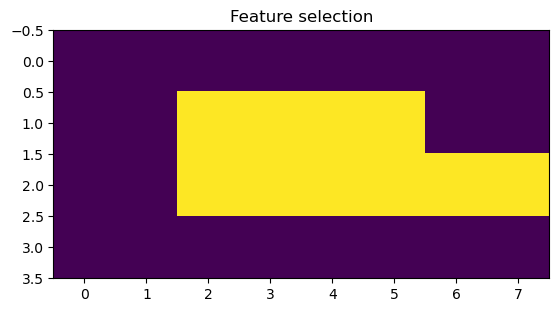

(100000, 32) (10902924, 32)
(100000, 32) (10902924, 10)
Learning rate set to 0.177874
0:	learn: 2.0596523	total: 672ms	remaining: 11m 11s
1:	learn: 1.9111136	total: 1.21s	remaining: 10m 3s
2:	learn: 1.7999854	total: 1.74s	remaining: 9m 38s
3:	learn: 1.7172307	total: 2.29s	remaining: 9m 29s
4:	learn: 1.6535825	total: 2.84s	remaining: 9m 24s
5:	learn: 1.6056988	total: 3.41s	remaining: 9m 24s
6:	learn: 1.5656920	total: 3.98s	remaining: 9m 24s
7:	learn: 1.5383809	total: 4.45s	remaining: 9m 12s
8:	learn: 1.5172590	total: 4.98s	remaining: 9m 8s
9:	learn: 1.5001407	total: 5.55s	remaining: 9m 9s
10:	learn: 1.4849423	total: 6.09s	remaining: 9m 7s
11:	learn: 1.4744981	total: 6.73s	remaining: 9m 14s
12:	learn: 1.4660011	total: 7.25s	remaining: 9m 10s
13:	learn: 1.4584582	total: 7.78s	remaining: 9m 7s
14:	learn: 1.4521498	total: 8.34s	remaining: 9m 7s
15:	learn: 1.4466177	total: 8.97s	remaining: 9m 11s
16:	learn: 1.4391351	total: 9.55s	remaining: 9m 12s
17:	learn: 1.4338862	total: 10.1s	remaining:

156:	learn: 1.2622054	total: 1m 28s	remaining: 7m 54s
157:	learn: 1.2618399	total: 1m 28s	remaining: 7m 53s
158:	learn: 1.2615028	total: 1m 29s	remaining: 7m 52s
159:	learn: 1.2610157	total: 1m 29s	remaining: 7m 51s
160:	learn: 1.2605193	total: 1m 30s	remaining: 7m 50s
161:	learn: 1.2598892	total: 1m 30s	remaining: 7m 49s
162:	learn: 1.2595093	total: 1m 31s	remaining: 7m 48s
163:	learn: 1.2593098	total: 1m 31s	remaining: 7m 47s
164:	learn: 1.2588211	total: 1m 32s	remaining: 7m 46s
165:	learn: 1.2583769	total: 1m 32s	remaining: 7m 45s
166:	learn: 1.2576447	total: 1m 33s	remaining: 7m 44s
167:	learn: 1.2573404	total: 1m 33s	remaining: 7m 43s
168:	learn: 1.2570868	total: 1m 33s	remaining: 7m 42s
169:	learn: 1.2568154	total: 1m 34s	remaining: 7m 41s
170:	learn: 1.2565179	total: 1m 34s	remaining: 7m 40s
171:	learn: 1.2561121	total: 1m 35s	remaining: 7m 39s
172:	learn: 1.2557568	total: 1m 35s	remaining: 7m 38s
173:	learn: 1.2548725	total: 1m 36s	remaining: 7m 37s
174:	learn: 1.2546195	total:

309:	learn: 1.2111902	total: 2m 44s	remaining: 6m 5s
310:	learn: 1.2110892	total: 2m 44s	remaining: 6m 4s
311:	learn: 1.2109855	total: 2m 44s	remaining: 6m 3s
312:	learn: 1.2106584	total: 2m 45s	remaining: 6m 3s
313:	learn: 1.2104290	total: 2m 46s	remaining: 6m 2s
314:	learn: 1.2100165	total: 2m 46s	remaining: 6m 2s
315:	learn: 1.2098445	total: 2m 47s	remaining: 6m 1s
316:	learn: 1.2096396	total: 2m 47s	remaining: 6m 1s
317:	learn: 1.2094366	total: 2m 48s	remaining: 6m
318:	learn: 1.2087953	total: 2m 48s	remaining: 5m 59s
319:	learn: 1.2086209	total: 2m 49s	remaining: 5m 59s
320:	learn: 1.2084809	total: 2m 49s	remaining: 5m 58s
321:	learn: 1.2083276	total: 2m 50s	remaining: 5m 58s
322:	learn: 1.2080814	total: 2m 50s	remaining: 5m 57s
323:	learn: 1.2079638	total: 2m 51s	remaining: 5m 57s
324:	learn: 1.2075419	total: 2m 51s	remaining: 5m 56s
325:	learn: 1.2070288	total: 2m 52s	remaining: 5m 56s
326:	learn: 1.2069193	total: 2m 52s	remaining: 5m 55s
327:	learn: 1.2068182	total: 2m 53s	rema

463:	learn: 1.1807952	total: 4m 2s	remaining: 4m 39s
464:	learn: 1.1806678	total: 4m 2s	remaining: 4m 39s
465:	learn: 1.1805385	total: 4m 3s	remaining: 4m 38s
466:	learn: 1.1802709	total: 4m 3s	remaining: 4m 38s
467:	learn: 1.1801506	total: 4m 4s	remaining: 4m 37s
468:	learn: 1.1800250	total: 4m 5s	remaining: 4m 37s
469:	learn: 1.1798992	total: 4m 5s	remaining: 4m 36s
470:	learn: 1.1791161	total: 4m 6s	remaining: 4m 36s
471:	learn: 1.1787228	total: 4m 6s	remaining: 4m 35s
472:	learn: 1.1786173	total: 4m 7s	remaining: 4m 35s
473:	learn: 1.1785205	total: 4m 7s	remaining: 4m 34s
474:	learn: 1.1784291	total: 4m 8s	remaining: 4m 34s
475:	learn: 1.1782546	total: 4m 8s	remaining: 4m 33s
476:	learn: 1.1777217	total: 4m 9s	remaining: 4m 33s
477:	learn: 1.1776230	total: 4m 9s	remaining: 4m 32s
478:	learn: 1.1775046	total: 4m 10s	remaining: 4m 32s
479:	learn: 1.1773670	total: 4m 10s	remaining: 4m 31s
480:	learn: 1.1763467	total: 4m 11s	remaining: 4m 31s
481:	learn: 1.1762349	total: 4m 11s	remaini

616:	learn: 1.1549102	total: 5m 24s	remaining: 3m 21s
617:	learn: 1.1546294	total: 5m 24s	remaining: 3m 20s
618:	learn: 1.1545885	total: 5m 25s	remaining: 3m 20s
619:	learn: 1.1544691	total: 5m 25s	remaining: 3m 19s
620:	learn: 1.1544046	total: 5m 26s	remaining: 3m 19s
621:	learn: 1.1543066	total: 5m 26s	remaining: 3m 18s
622:	learn: 1.1542388	total: 5m 27s	remaining: 3m 17s
623:	learn: 1.1541986	total: 5m 27s	remaining: 3m 17s
624:	learn: 1.1541205	total: 5m 28s	remaining: 3m 16s
625:	learn: 1.1540896	total: 5m 28s	remaining: 3m 16s
626:	learn: 1.1540380	total: 5m 29s	remaining: 3m 15s
627:	learn: 1.1538809	total: 5m 29s	remaining: 3m 15s
628:	learn: 1.1537854	total: 5m 29s	remaining: 3m 14s
629:	learn: 1.1537020	total: 5m 30s	remaining: 3m 14s
630:	learn: 1.1534346	total: 5m 31s	remaining: 3m 13s
631:	learn: 1.1533334	total: 5m 31s	remaining: 3m 13s
632:	learn: 1.1533079	total: 5m 32s	remaining: 3m 12s
633:	learn: 1.1532166	total: 5m 32s	remaining: 3m 11s
634:	learn: 1.1531475	total:

769:	learn: 1.1339315	total: 6m 45s	remaining: 2m 1s
770:	learn: 1.1338670	total: 6m 46s	remaining: 2m
771:	learn: 1.1337782	total: 6m 46s	remaining: 2m
772:	learn: 1.1337585	total: 6m 47s	remaining: 1m 59s
773:	learn: 1.1333458	total: 6m 48s	remaining: 1m 59s
774:	learn: 1.1323584	total: 6m 48s	remaining: 1m 58s
775:	learn: 1.1322809	total: 6m 49s	remaining: 1m 58s
776:	learn: 1.1322034	total: 6m 49s	remaining: 1m 57s
777:	learn: 1.1320273	total: 6m 50s	remaining: 1m 57s
778:	learn: 1.1319746	total: 6m 51s	remaining: 1m 56s
779:	learn: 1.1318728	total: 6m 51s	remaining: 1m 56s
780:	learn: 1.1316918	total: 6m 52s	remaining: 1m 55s
781:	learn: 1.1316276	total: 6m 52s	remaining: 1m 55s
782:	learn: 1.1315966	total: 6m 53s	remaining: 1m 54s
783:	learn: 1.1314980	total: 6m 53s	remaining: 1m 53s
784:	learn: 1.1314867	total: 6m 54s	remaining: 1m 53s
785:	learn: 1.1314338	total: 6m 54s	remaining: 1m 52s
786:	learn: 1.1313834	total: 6m 55s	remaining: 1m 52s
787:	learn: 1.1313270	total: 6m 55s	r

923:	learn: 1.1183061	total: 8m 6s	remaining: 40s
924:	learn: 1.1182470	total: 8m 7s	remaining: 39.5s
925:	learn: 1.1181890	total: 8m 7s	remaining: 39s
926:	learn: 1.1181171	total: 8m 8s	remaining: 38.4s
927:	learn: 1.1180536	total: 8m 8s	remaining: 37.9s
928:	learn: 1.1180159	total: 8m 9s	remaining: 37.4s
929:	learn: 1.1178728	total: 8m 9s	remaining: 36.9s
930:	learn: 1.1177980	total: 8m 10s	remaining: 36.3s
931:	learn: 1.1177649	total: 8m 10s	remaining: 35.8s
932:	learn: 1.1177197	total: 8m 11s	remaining: 35.3s
933:	learn: 1.1176747	total: 8m 11s	remaining: 34.7s
934:	learn: 1.1175933	total: 8m 12s	remaining: 34.2s
935:	learn: 1.1175326	total: 8m 12s	remaining: 33.7s
936:	learn: 1.1175118	total: 8m 13s	remaining: 33.2s
937:	learn: 1.1174190	total: 8m 13s	remaining: 32.6s
938:	learn: 1.1172328	total: 8m 14s	remaining: 32.1s
939:	learn: 1.1171834	total: 8m 14s	remaining: 31.6s
940:	learn: 1.1170866	total: 8m 15s	remaining: 31s
941:	learn: 1.1170651	total: 8m 15s	remaining: 30.5s
942:	l

In [8]:
%%time
feature_importance_report, boruta_test_submission = CatBoostTestBoruta.evaluate()

In [9]:
feature_importance_report

{'important_columns': Index(['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
        'item_cnt_month_lag_12', 'avg_by_month_item_id_item_cnt_lag_1',
        'avg_by_month_item_id_item_cnt_lag_2',
        'avg_by_month_item_id_item_cnt_lag_3',
        'avg_by_month_shop_item_cnt_lag_1', 'avg_by_month_shop_item_cnt_lag_2',
        'avg_by_month_shop_item_cnt_lag_3'],
       dtype='object'),
 'unimportant_columns': Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'type_code',
        'subtype_code', 'shop_city', 'shop_category', 'name2', 'name3',
        'avg_by_month_item_cnt_lag_1', 'avg_by_month_item_cnt_lag_2',
        'avg_by_month_item_cnt_lag_3', 'avg_by_month_item_cnt_lag_12',
        'avg_by_month_city_item_cnt_lag_1', 'avg_by_month_cat_item_cnt_lag_1',
        'delta_price_lag', 'category_cluster_id', 'item_price_cluster_id',
        'cluster_id', 'item_shop_first_sale', 'item_first_sale'],
       dtype='object'),
 'sorted_features_by_im

#### Hyperparameters optimization layer test

In [7]:
%%time
CatBoostTestOptuna = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=10, random_state=42, silent=True),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Optuna"
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 2.73 s
Wall time: 3.97 s


In [8]:
%%time
optuna_test_submission = CatBoostTestOptuna.evaluate()

[I 2023-09-29 11:43:34,392] A new study created in memory with name: no-name-9f837977-8b99-473e-8379-d3d7ea31d265


0:	learn: 1.7122226	total: 220ms	remaining: 21.8s
1:	learn: 1.7099951	total: 262ms	remaining: 12.8s
2:	learn: 1.7078229	total: 308ms	remaining: 9.96s
3:	learn: 1.7057049	total: 547ms	remaining: 13.1s
4:	learn: 1.7036396	total: 587ms	remaining: 11.1s
5:	learn: 1.7016091	total: 629ms	remaining: 9.85s
6:	learn: 1.6996395	total: 670ms	remaining: 8.9s
7:	learn: 1.6977029	total: 714ms	remaining: 8.21s
8:	learn: 1.6958042	total: 766ms	remaining: 7.75s
9:	learn: 1.6939567	total: 813ms	remaining: 7.32s
10:	learn: 1.6921555	total: 851ms	remaining: 6.88s
11:	learn: 1.6903651	total: 888ms	remaining: 6.51s
12:	learn: 1.6886260	total: 925ms	remaining: 6.19s
13:	learn: 1.6873847	total: 963ms	remaining: 5.91s
14:	learn: 1.6856924	total: 1s	remaining: 5.67s
15:	learn: 1.6840140	total: 1.04s	remaining: 5.45s
16:	learn: 1.6823778	total: 1.07s	remaining: 5.25s
17:	learn: 1.6807839	total: 1.11s	remaining: 5.07s
18:	learn: 1.6792159	total: 1.15s	remaining: 4.91s
19:	learn: 1.6776729	total: 1.19s	remaining: 

63:	learn: 1.9013831	total: 4.38s	remaining: 2.46s
64:	learn: 1.8989870	total: 4.44s	remaining: 2.39s
65:	learn: 1.8966341	total: 4.51s	remaining: 2.32s
66:	learn: 1.8944204	total: 4.58s	remaining: 2.25s
67:	learn: 1.8921007	total: 4.64s	remaining: 2.18s
68:	learn: 1.8898332	total: 4.71s	remaining: 2.12s
69:	learn: 1.8876858	total: 4.78s	remaining: 2.05s
70:	learn: 1.8854276	total: 4.85s	remaining: 1.98s
71:	learn: 1.8833305	total: 4.92s	remaining: 1.91s
72:	learn: 1.8811244	total: 4.98s	remaining: 1.84s
73:	learn: 1.8789478	total: 5.05s	remaining: 1.77s
74:	learn: 1.8767685	total: 5.12s	remaining: 1.71s
75:	learn: 1.8746305	total: 5.19s	remaining: 1.64s
76:	learn: 1.8725682	total: 5.25s	remaining: 1.57s
77:	learn: 1.8704616	total: 5.32s	remaining: 1.5s
78:	learn: 1.8684793	total: 5.39s	remaining: 1.43s
79:	learn: 1.8666585	total: 5.46s	remaining: 1.37s
80:	learn: 1.8648834	total: 5.54s	remaining: 1.3s
81:	learn: 1.8628696	total: 5.6s	remaining: 1.23s
82:	learn: 1.8608211	total: 5.67s	

26:	learn: 2.0314560	total: 4.18s	remaining: 11.3s
27:	learn: 2.0264159	total: 4.31s	remaining: 11.1s
28:	learn: 2.0214089	total: 4.45s	remaining: 10.9s
29:	learn: 2.0165461	total: 4.59s	remaining: 10.7s
30:	learn: 2.0117143	total: 4.72s	remaining: 10.5s
31:	learn: 2.0070258	total: 4.85s	remaining: 10.3s
32:	learn: 2.0023525	total: 4.99s	remaining: 10.1s
33:	learn: 1.9977887	total: 5.13s	remaining: 9.96s
34:	learn: 1.9933212	total: 5.27s	remaining: 9.79s
35:	learn: 1.9889003	total: 5.4s	remaining: 9.6s
36:	learn: 1.9845816	total: 5.53s	remaining: 9.42s
37:	learn: 1.9803208	total: 5.66s	remaining: 9.23s
38:	learn: 1.9764292	total: 5.79s	remaining: 9.05s
39:	learn: 1.9722901	total: 5.93s	remaining: 8.89s
40:	learn: 1.9682205	total: 6.07s	remaining: 8.73s
41:	learn: 1.9642209	total: 6.21s	remaining: 8.57s
42:	learn: 1.9602869	total: 6.34s	remaining: 8.41s
43:	learn: 1.9564318	total: 6.48s	remaining: 8.25s
44:	learn: 1.9526556	total: 6.62s	remaining: 8.1s
45:	learn: 1.9488880	total: 6.76s	

88:	learn: 1.8610223	total: 15.1s	remaining: 1.87s
89:	learn: 1.8585173	total: 15.3s	remaining: 1.7s
90:	learn: 1.8560787	total: 15.5s	remaining: 1.53s
91:	learn: 1.8535951	total: 15.6s	remaining: 1.36s
92:	learn: 1.8511792	total: 15.8s	remaining: 1.19s
93:	learn: 1.8487669	total: 15.9s	remaining: 1.02s
94:	learn: 1.8464113	total: 16.1s	remaining: 848ms
95:	learn: 1.8440155	total: 16.3s	remaining: 678ms
96:	learn: 1.8416661	total: 16.4s	remaining: 509ms
97:	learn: 1.8393681	total: 16.6s	remaining: 339ms
98:	learn: 1.8370290	total: 16.8s	remaining: 170ms
99:	learn: 1.8347492	total: 16.9s	remaining: 0us
4.611818742728022
8.541597092399403


[I 2023-09-29 11:45:06,105] Trial 0 finished with value: 8.541597092399403 and parameters: {'learning_rate': 0.013147058836269945, 'depth': 1, 'subsample': 0.3643149063889708, 'colsample_bylevel': 0.9026002356223926, 'min_data_in_leaf': 55}. Best is trial 0 with value: 8.541597092399403.


0:	learn: 1.7035141	total: 108ms	remaining: 10.7s
1:	learn: 1.6926583	total: 217ms	remaining: 10.6s
2:	learn: 1.6831564	total: 333ms	remaining: 10.8s
3:	learn: 1.6743272	total: 441ms	remaining: 10.6s
4:	learn: 1.6657518	total: 549ms	remaining: 10.4s
5:	learn: 1.6573277	total: 657ms	remaining: 10.3s
6:	learn: 1.6483877	total: 757ms	remaining: 10.1s
7:	learn: 1.6405167	total: 858ms	remaining: 9.86s
8:	learn: 1.6330016	total: 958ms	remaining: 9.69s
9:	learn: 1.6255168	total: 1.06s	remaining: 9.53s
10:	learn: 1.6181402	total: 1.17s	remaining: 9.48s
11:	learn: 1.6116618	total: 1.28s	remaining: 9.41s
12:	learn: 1.6051578	total: 1.39s	remaining: 9.33s
13:	learn: 1.5986793	total: 1.5s	remaining: 9.2s
14:	learn: 1.5929566	total: 1.6s	remaining: 9.05s
15:	learn: 1.5874999	total: 1.7s	remaining: 8.92s
16:	learn: 1.5820150	total: 1.8s	remaining: 8.77s
17:	learn: 1.5767105	total: 1.9s	remaining: 8.64s
18:	learn: 1.5718119	total: 2s	remaining: 8.51s
19:	learn: 1.5663517	total: 2.09s	remaining: 8.36s

62:	learn: 1.5106160	total: 13.7s	remaining: 8.05s
63:	learn: 1.5078184	total: 14s	remaining: 7.85s
64:	learn: 1.5051402	total: 14.2s	remaining: 7.64s
65:	learn: 1.5028241	total: 14.4s	remaining: 7.43s
66:	learn: 1.5001765	total: 14.6s	remaining: 7.2s
67:	learn: 1.4976276	total: 14.8s	remaining: 6.98s
68:	learn: 1.4953748	total: 15.1s	remaining: 6.76s
69:	learn: 1.4919168	total: 15.3s	remaining: 6.54s
70:	learn: 1.4897080	total: 15.5s	remaining: 6.33s
71:	learn: 1.4872813	total: 15.8s	remaining: 6.13s
72:	learn: 1.4851129	total: 16s	remaining: 5.92s
73:	learn: 1.4833379	total: 16.2s	remaining: 5.71s
74:	learn: 1.4812134	total: 16.4s	remaining: 5.48s
75:	learn: 1.4792609	total: 16.7s	remaining: 5.26s
76:	learn: 1.4771307	total: 16.9s	remaining: 5.03s
77:	learn: 1.4755510	total: 17.1s	remaining: 4.82s
78:	learn: 1.4740844	total: 17.3s	remaining: 4.6s
79:	learn: 1.4725689	total: 17.5s	remaining: 4.38s
80:	learn: 1.4712479	total: 17.7s	remaining: 4.16s
81:	learn: 1.4695258	total: 18s	remai

24:	learn: 1.6899982	total: 11.2s	remaining: 33.7s
25:	learn: 1.6783713	total: 11.6s	remaining: 33.1s
26:	learn: 1.6672223	total: 12.1s	remaining: 32.6s
27:	learn: 1.6561301	total: 12.5s	remaining: 32.1s
28:	learn: 1.6454205	total: 12.9s	remaining: 31.6s
29:	learn: 1.6354340	total: 13.4s	remaining: 31.2s
30:	learn: 1.6259216	total: 13.9s	remaining: 31s
31:	learn: 1.6161287	total: 14.4s	remaining: 30.5s
32:	learn: 1.6071071	total: 14.9s	remaining: 30.2s
33:	learn: 1.5984295	total: 15.3s	remaining: 29.8s
34:	learn: 1.5904982	total: 15.8s	remaining: 29.3s
35:	learn: 1.5825074	total: 16.3s	remaining: 28.9s
36:	learn: 1.5754427	total: 16.8s	remaining: 28.6s
37:	learn: 1.5679855	total: 17.3s	remaining: 28.2s
38:	learn: 1.5606561	total: 17.7s	remaining: 27.7s
39:	learn: 1.5538806	total: 18.1s	remaining: 27.2s
40:	learn: 1.5473452	total: 18.6s	remaining: 26.7s
41:	learn: 1.5410876	total: 19s	remaining: 26.3s
42:	learn: 1.5347609	total: 19.5s	remaining: 25.9s
43:	learn: 1.5290806	total: 19.9s	r

86:	learn: 1.4184497	total: 44.8s	remaining: 6.69s
87:	learn: 1.4161558	total: 45.3s	remaining: 6.18s
88:	learn: 1.4147683	total: 45.8s	remaining: 5.66s
89:	learn: 1.4127452	total: 46.3s	remaining: 5.14s
90:	learn: 1.4108986	total: 46.8s	remaining: 4.63s
91:	learn: 1.4095448	total: 47.3s	remaining: 4.11s
92:	learn: 1.4084475	total: 47.8s	remaining: 3.6s
93:	learn: 1.4073593	total: 48.3s	remaining: 3.08s
94:	learn: 1.4059070	total: 48.8s	remaining: 2.57s
95:	learn: 1.4042136	total: 49.3s	remaining: 2.05s
96:	learn: 1.4032750	total: 49.9s	remaining: 1.54s
97:	learn: 1.4021127	total: 50.4s	remaining: 1.03s
98:	learn: 1.4012214	total: 51s	remaining: 515ms
99:	learn: 1.4003300	total: 51.6s	remaining: 0us
2.8286303281325993
5.376541154135311


[I 2023-09-29 11:48:29,290] Trial 1 finished with value: 5.376541154135311 and parameters: {'learning_rate': 0.028210252488497983, 'depth': 10, 'subsample': 0.26847082241715237, 'colsample_bylevel': 0.666842921644152, 'min_data_in_leaf': 15}. Best is trial 1 with value: 5.376541154135311.


0:	learn: 1.7141799	total: 35.5ms	remaining: 3.52s
1:	learn: 1.7138542	total: 68ms	remaining: 3.33s
2:	learn: 1.7136455	total: 99.4ms	remaining: 3.21s
3:	learn: 1.7135326	total: 132ms	remaining: 3.16s
4:	learn: 1.7134733	total: 162ms	remaining: 3.07s
5:	learn: 1.7133608	total: 192ms	remaining: 3.01s
6:	learn: 1.7132484	total: 222ms	remaining: 2.94s
7:	learn: 1.7131730	total: 251ms	remaining: 2.88s
8:	learn: 1.7128496	total: 279ms	remaining: 2.82s
9:	learn: 1.7125274	total: 311ms	remaining: 2.79s
10:	learn: 1.7122084	total: 342ms	remaining: 2.77s
11:	learn: 1.7120001	total: 371ms	remaining: 2.72s
12:	learn: 1.7119413	total: 400ms	remaining: 2.68s
13:	learn: 1.7118305	total: 431ms	remaining: 2.65s
14:	learn: 1.7117720	total: 470ms	remaining: 2.66s
15:	learn: 1.7116616	total: 499ms	remaining: 2.62s
16:	learn: 1.7114563	total: 528ms	remaining: 2.58s
17:	learn: 1.7112518	total: 557ms	remaining: 2.54s
18:	learn: 1.7109335	total: 587ms	remaining: 2.5s
19:	learn: 1.7108753	total: 617ms	remaini

64:	learn: 2.0963388	total: 3.93s	remaining: 2.12s
65:	learn: 2.0961566	total: 4s	remaining: 2.06s
66:	learn: 2.0953779	total: 4.05s	remaining: 2s
67:	learn: 2.0948691	total: 4.12s	remaining: 1.94s
68:	learn: 2.0948498	total: 4.17s	remaining: 1.88s
69:	learn: 2.0945152	total: 4.23s	remaining: 1.81s
70:	learn: 2.0940085	total: 4.29s	remaining: 1.75s
71:	learn: 2.0935035	total: 4.35s	remaining: 1.69s
72:	learn: 2.0933229	total: 4.41s	remaining: 1.63s
73:	learn: 2.0929901	total: 4.47s	remaining: 1.57s
74:	learn: 2.0926585	total: 4.53s	remaining: 1.51s
75:	learn: 2.0925454	total: 4.59s	remaining: 1.45s
76:	learn: 2.0920430	total: 4.64s	remaining: 1.39s
77:	learn: 2.0912726	total: 4.71s	remaining: 1.33s
78:	learn: 2.0912335	total: 4.76s	remaining: 1.27s
79:	learn: 2.0904656	total: 4.83s	remaining: 1.21s
80:	learn: 2.0897003	total: 4.88s	remaining: 1.15s
81:	learn: 2.0895732	total: 4.95s	remaining: 1.09s
82:	learn: 2.0893948	total: 5.01s	remaining: 1.02s
83:	learn: 2.0892829	total: 5.07s	rem

26:	learn: 2.1848718	total: 4.41s	remaining: 11.9s
27:	learn: 2.1844530	total: 4.53s	remaining: 11.7s
28:	learn: 2.1833001	total: 4.66s	remaining: 11.4s
29:	learn: 2.1823373	total: 4.79s	remaining: 11.2s
30:	learn: 2.1819208	total: 4.91s	remaining: 10.9s
31:	learn: 2.1817016	total: 5.04s	remaining: 10.7s
32:	learn: 2.1816651	total: 5.16s	remaining: 10.5s
33:	learn: 2.1808482	total: 5.29s	remaining: 10.3s
34:	learn: 2.1806366	total: 5.41s	remaining: 10s
35:	learn: 2.1802221	total: 5.53s	remaining: 9.83s
36:	learn: 2.1790782	total: 5.65s	remaining: 9.63s
37:	learn: 2.1779371	total: 5.78s	remaining: 9.42s
38:	learn: 2.1769848	total: 5.9s	remaining: 9.23s
39:	learn: 2.1767023	total: 6.02s	remaining: 9.03s
40:	learn: 2.1757536	total: 6.15s	remaining: 8.84s
41:	learn: 2.1749504	total: 6.27s	remaining: 8.66s
42:	learn: 2.1746697	total: 6.39s	remaining: 8.47s
43:	learn: 2.1737263	total: 6.52s	remaining: 8.3s
44:	learn: 2.1725981	total: 6.65s	remaining: 8.13s
45:	learn: 2.1723193	total: 6.78s	r

88:	learn: 2.1958909	total: 13.6s	remaining: 1.69s
89:	learn: 2.1955315	total: 13.8s	remaining: 1.53s
90:	learn: 2.1945842	total: 14s	remaining: 1.38s
91:	learn: 2.1936415	total: 14.1s	remaining: 1.23s
92:	learn: 2.1928103	total: 14.3s	remaining: 1.07s
93:	learn: 2.1918711	total: 14.4s	remaining: 920ms
94:	learn: 2.1909363	total: 14.6s	remaining: 766ms
95:	learn: 2.1905106	total: 14.7s	remaining: 613ms
96:	learn: 2.1895793	total: 14.9s	remaining: 459ms
97:	learn: 2.1887571	total: 15s	remaining: 306ms
98:	learn: 2.1878291	total: 15.2s	remaining: 153ms
99:	learn: 2.1870115	total: 15.3s	remaining: 0us
6.554232466904047
11.86831020092338


[I 2023-09-29 11:49:52,902] Trial 2 finished with value: 11.86831020092338 and parameters: {'learning_rate': 0.0018717505206148864, 'depth': 1, 'subsample': 0.31403469931797573, 'colsample_bylevel': 0.3066014227755851, 'min_data_in_leaf': 11}. Best is trial 1 with value: 5.376541154135311.


0:	learn: 1.6961316	total: 125ms	remaining: 12.4s
1:	learn: 1.6814247	total: 246ms	remaining: 12s
2:	learn: 1.6668635	total: 376ms	remaining: 12.2s
3:	learn: 1.6531426	total: 511ms	remaining: 12.3s
4:	learn: 1.6388989	total: 650ms	remaining: 12.3s
5:	learn: 1.6267788	total: 787ms	remaining: 12.3s
6:	learn: 1.6166673	total: 914ms	remaining: 12.1s
7:	learn: 1.6052339	total: 1.03s	remaining: 11.9s
8:	learn: 1.5954108	total: 1.16s	remaining: 11.7s
9:	learn: 1.5864521	total: 1.28s	remaining: 11.6s
10:	learn: 1.5784967	total: 1.41s	remaining: 11.4s
11:	learn: 1.5697042	total: 1.54s	remaining: 11.3s
12:	learn: 1.5612097	total: 1.67s	remaining: 11.2s
13:	learn: 1.5552576	total: 1.79s	remaining: 11s
14:	learn: 1.5481376	total: 1.91s	remaining: 10.8s
15:	learn: 1.5427343	total: 2.03s	remaining: 10.7s
16:	learn: 1.5361642	total: 2.15s	remaining: 10.5s
17:	learn: 1.5311696	total: 2.29s	remaining: 10.4s
18:	learn: 1.5261052	total: 2.42s	remaining: 10.3s
19:	learn: 1.5209431	total: 2.54s	remaining: 

62:	learn: 1.4484234	total: 15.8s	remaining: 9.27s
63:	learn: 1.4472546	total: 16s	remaining: 9.01s
64:	learn: 1.4462376	total: 16.3s	remaining: 8.77s
65:	learn: 1.4447354	total: 16.6s	remaining: 8.53s
66:	learn: 1.4427611	total: 16.8s	remaining: 8.29s
67:	learn: 1.4416529	total: 17.1s	remaining: 8.04s
68:	learn: 1.4400403	total: 17.3s	remaining: 7.78s
69:	learn: 1.4362622	total: 17.6s	remaining: 7.54s
70:	learn: 1.4330950	total: 17.9s	remaining: 7.29s
71:	learn: 1.4312976	total: 18.1s	remaining: 7.04s
72:	learn: 1.4307252	total: 18.4s	remaining: 6.79s
73:	learn: 1.4294660	total: 18.6s	remaining: 6.54s
74:	learn: 1.4256842	total: 18.9s	remaining: 6.3s
75:	learn: 1.4247766	total: 19.2s	remaining: 6.05s
76:	learn: 1.4236884	total: 19.4s	remaining: 5.8s
77:	learn: 1.4226741	total: 19.7s	remaining: 5.55s
78:	learn: 1.4216700	total: 19.9s	remaining: 5.29s
79:	learn: 1.4210040	total: 20.2s	remaining: 5.05s
80:	learn: 1.4189880	total: 20.5s	remaining: 4.8s
81:	learn: 1.4180894	total: 20.7s	re

24:	learn: 1.5390180	total: 13.2s	remaining: 39.5s
25:	learn: 1.5297667	total: 13.7s	remaining: 38.9s
26:	learn: 1.5217697	total: 14.1s	remaining: 38.2s
27:	learn: 1.5135803	total: 14.7s	remaining: 37.8s
28:	learn: 1.5056069	total: 15.2s	remaining: 37.2s
29:	learn: 1.4986507	total: 15.7s	remaining: 36.7s
30:	learn: 1.4913935	total: 16.2s	remaining: 36.1s
31:	learn: 1.4849407	total: 16.7s	remaining: 35.5s
32:	learn: 1.4792633	total: 17.2s	remaining: 35s
33:	learn: 1.4730238	total: 17.7s	remaining: 34.4s
34:	learn: 1.4670945	total: 18.2s	remaining: 33.8s
35:	learn: 1.4618220	total: 18.7s	remaining: 33.3s
36:	learn: 1.4575251	total: 19.2s	remaining: 32.6s
37:	learn: 1.4535367	total: 19.6s	remaining: 32.1s
38:	learn: 1.4495854	total: 20.1s	remaining: 31.5s
39:	learn: 1.4457118	total: 20.6s	remaining: 30.9s
40:	learn: 1.4426569	total: 21.1s	remaining: 30.3s
41:	learn: 1.4396974	total: 21.5s	remaining: 29.7s
42:	learn: 1.4370068	total: 22s	remaining: 29.2s
43:	learn: 1.4330621	total: 22.5s	r

86:	learn: 1.3769255	total: 53.9s	remaining: 8.06s
87:	learn: 1.3763616	total: 54.6s	remaining: 7.44s
88:	learn: 1.3759924	total: 55.3s	remaining: 6.83s
89:	learn: 1.3749374	total: 55.9s	remaining: 6.22s
90:	learn: 1.3743634	total: 56.6s	remaining: 5.59s
91:	learn: 1.3736756	total: 57.3s	remaining: 4.98s
92:	learn: 1.3728390	total: 58.1s	remaining: 4.37s
93:	learn: 1.3722844	total: 59s	remaining: 3.76s
94:	learn: 1.3715318	total: 59.7s	remaining: 3.14s
95:	learn: 1.3704033	total: 1m	remaining: 2.52s
96:	learn: 1.3698640	total: 1m 1s	remaining: 1.89s
97:	learn: 1.3686590	total: 1m 1s	remaining: 1.26s
98:	learn: 1.3680327	total: 1m 2s	remaining: 631ms
99:	learn: 1.3671169	total: 1m 3s	remaining: 0us
2.624398759849601
5.226406872871696


[I 2023-09-29 11:53:43,721] Trial 3 finished with value: 5.226406872871696 and parameters: {'learning_rate': 0.04925399885606955, 'depth': 9, 'subsample': 0.6773664925035998, 'colsample_bylevel': 0.461771754982463, 'min_data_in_leaf': 18}. Best is trial 3 with value: 5.226406872871696.


0:	learn: 1.7141372	total: 50.8ms	remaining: 5.03s
1:	learn: 1.7133956	total: 112ms	remaining: 5.49s
2:	learn: 1.7129765	total: 163ms	remaining: 5.27s
3:	learn: 1.7129765	total: 196ms	remaining: 4.7s
4:	learn: 1.7115408	total: 258ms	remaining: 4.89s
5:	learn: 1.7107448	total: 314ms	remaining: 4.92s
6:	learn: 1.7107448	total: 346ms	remaining: 4.59s
7:	learn: 1.7093961	total: 394ms	remaining: 4.54s
8:	learn: 1.7079847	total: 457ms	remaining: 4.63s
9:	learn: 1.7077270	total: 509ms	remaining: 4.58s
10:	learn: 1.7064431	total: 571ms	remaining: 4.62s
11:	learn: 1.7062351	total: 626ms	remaining: 4.59s
12:	learn: 1.7057378	total: 709ms	remaining: 4.74s
13:	learn: 1.7056898	total: 751ms	remaining: 4.62s
14:	learn: 1.7051821	total: 818ms	remaining: 4.63s
15:	learn: 1.7032486	total: 879ms	remaining: 4.61s
16:	learn: 1.7028927	total: 942ms	remaining: 4.6s
17:	learn: 1.7028927	total: 975ms	remaining: 4.44s
18:	learn: 1.7025641	total: 1.04s	remaining: 4.45s
19:	learn: 1.7023385	total: 1.13s	remainin

64:	learn: 1.9830223	total: 5.61s	remaining: 3.02s
65:	learn: 1.9829055	total: 5.71s	remaining: 2.94s
66:	learn: 1.9815807	total: 5.79s	remaining: 2.85s
67:	learn: 1.9779566	total: 5.88s	remaining: 2.77s
68:	learn: 1.9777722	total: 5.97s	remaining: 2.68s
69:	learn: 1.9776573	total: 6.06s	remaining: 2.6s
70:	learn: 1.9770032	total: 6.16s	remaining: 2.52s
71:	learn: 1.9753790	total: 6.26s	remaining: 2.43s
72:	learn: 1.9747628	total: 6.34s	remaining: 2.35s
73:	learn: 1.9745749	total: 6.43s	remaining: 2.26s
74:	learn: 1.9735857	total: 6.52s	remaining: 2.17s
75:	learn: 1.9725768	total: 6.6s	remaining: 2.08s
76:	learn: 1.9689909	total: 6.69s	remaining: 2s
77:	learn: 1.9672001	total: 6.77s	remaining: 1.91s
78:	learn: 1.9639091	total: 6.86s	remaining: 1.82s
79:	learn: 1.9636781	total: 6.95s	remaining: 1.74s
80:	learn: 1.9614469	total: 7.05s	remaining: 1.65s
81:	learn: 1.9582122	total: 7.14s	remaining: 1.57s
82:	learn: 1.9550389	total: 7.23s	remaining: 1.48s
83:	learn: 1.9530191	total: 7.32s	re

27:	learn: 2.1069782	total: 6.23s	remaining: 16s
28:	learn: 2.1068693	total: 6.45s	remaining: 15.8s
29:	learn: 2.1014986	total: 6.66s	remaining: 15.5s
30:	learn: 2.1014721	total: 6.83s	remaining: 15.2s
31:	learn: 2.0968227	total: 7.1s	remaining: 15.1s
32:	learn: 2.0901598	total: 7.33s	remaining: 14.9s
33:	learn: 2.0886849	total: 7.53s	remaining: 14.6s
34:	learn: 2.0886849	total: 7.68s	remaining: 14.3s
35:	learn: 2.0873719	total: 7.97s	remaining: 14.2s
36:	learn: 2.0872651	total: 8.26s	remaining: 14.1s
37:	learn: 2.0866908	total: 8.44s	remaining: 13.8s
38:	learn: 2.0809550	total: 8.66s	remaining: 13.6s
39:	learn: 2.0761678	total: 8.86s	remaining: 13.3s
40:	learn: 2.0744946	total: 9.06s	remaining: 13s
41:	learn: 2.0683090	total: 9.23s	remaining: 12.8s
42:	learn: 2.0682139	total: 9.43s	remaining: 12.5s
43:	learn: 2.0621739	total: 9.63s	remaining: 12.3s
44:	learn: 2.0621739	total: 9.75s	remaining: 11.9s
45:	learn: 2.0621739	total: 9.87s	remaining: 11.6s
46:	learn: 2.0576711	total: 10.1s	re

89:	learn: 1.9989182	total: 20s	remaining: 2.22s
90:	learn: 1.9987327	total: 20.2s	remaining: 2s
91:	learn: 1.9985342	total: 20.5s	remaining: 1.78s
92:	learn: 1.9947214	total: 20.7s	remaining: 1.56s
93:	learn: 1.9928309	total: 20.9s	remaining: 1.33s
94:	learn: 1.9926292	total: 21.1s	remaining: 1.11s
95:	learn: 1.9879969	total: 21.3s	remaining: 888ms
96:	learn: 1.9848132	total: 21.5s	remaining: 666ms
97:	learn: 1.9848132	total: 21.7s	remaining: 444ms
98:	learn: 1.9814994	total: 21.9s	remaining: 221ms
99:	learn: 1.9793358	total: 22.1s	remaining: 0us
5.1834899496085
9.659721325506293


[I 2023-09-29 11:55:30,593] Trial 4 finished with value: 9.659721325506293 and parameters: {'learning_rate': 0.011515337226288943, 'depth': 2, 'subsample': 0.8634080748605826, 'colsample_bylevel': 0.07043847513874249, 'min_data_in_leaf': 2}. Best is trial 3 with value: 5.226406872871696.


0:	learn: 1.7124364	total: 132ms	remaining: 13s
1:	learn: 1.7103808	total: 261ms	remaining: 12.8s
2:	learn: 1.7086197	total: 399ms	remaining: 12.9s
3:	learn: 1.7065260	total: 550ms	remaining: 13.2s
4:	learn: 1.7045328	total: 702ms	remaining: 13.3s
5:	learn: 1.7025317	total: 831ms	remaining: 13s
6:	learn: 1.7005583	total: 965ms	remaining: 12.8s
7:	learn: 1.6986188	total: 1.1s	remaining: 12.6s
8:	learn: 1.6966498	total: 1.23s	remaining: 12.4s
9:	learn: 1.6950079	total: 1.36s	remaining: 12.2s
10:	learn: 1.6930611	total: 1.51s	remaining: 12.2s
11:	learn: 1.6911630	total: 1.65s	remaining: 12.1s
12:	learn: 1.6892307	total: 1.79s	remaining: 12s
13:	learn: 1.6873627	total: 1.94s	remaining: 11.9s
14:	learn: 1.6854760	total: 2.07s	remaining: 11.8s
15:	learn: 1.6837044	total: 2.2s	remaining: 11.6s
16:	learn: 1.6818956	total: 2.34s	remaining: 11.4s
17:	learn: 1.6801432	total: 2.48s	remaining: 11.3s
18:	learn: 1.6783462	total: 2.62s	remaining: 11.2s
19:	learn: 1.6766373	total: 2.75s	remaining: 11s


62:	learn: 1.8769686	total: 17.3s	remaining: 10.2s
63:	learn: 1.8739472	total: 17.6s	remaining: 9.87s
64:	learn: 1.8708677	total: 17.8s	remaining: 9.59s
65:	learn: 1.8678101	total: 18.1s	remaining: 9.31s
66:	learn: 1.8648142	total: 18.3s	remaining: 9.02s
67:	learn: 1.8618175	total: 18.6s	remaining: 8.74s
68:	learn: 1.8588736	total: 18.8s	remaining: 8.46s
69:	learn: 1.8558131	total: 19.1s	remaining: 8.18s
70:	learn: 1.8528378	total: 19.4s	remaining: 7.91s
71:	learn: 1.8499859	total: 19.6s	remaining: 7.64s
72:	learn: 1.8470708	total: 19.9s	remaining: 7.36s
73:	learn: 1.8442885	total: 20.2s	remaining: 7.09s
74:	learn: 1.8414428	total: 20.4s	remaining: 6.8s
75:	learn: 1.8386249	total: 20.7s	remaining: 6.53s
76:	learn: 1.8358678	total: 20.9s	remaining: 6.26s
77:	learn: 1.8330568	total: 21.2s	remaining: 5.98s
78:	learn: 1.8303240	total: 21.4s	remaining: 5.7s
79:	learn: 1.8275461	total: 21.7s	remaining: 5.42s
80:	learn: 1.8248023	total: 21.9s	remaining: 5.14s
81:	learn: 1.8221422	total: 22.2s

24:	learn: 2.0622128	total: 15.3s	remaining: 45.8s
25:	learn: 2.0570027	total: 15.8s	remaining: 44.9s
26:	learn: 2.0518788	total: 16.3s	remaining: 44.1s
27:	learn: 2.0467522	total: 16.8s	remaining: 43.3s
28:	learn: 2.0416703	total: 17.3s	remaining: 42.4s
29:	learn: 2.0365513	total: 17.9s	remaining: 41.7s
30:	learn: 2.0315213	total: 18.4s	remaining: 41s
31:	learn: 2.0264732	total: 19s	remaining: 40.3s
32:	learn: 2.0215375	total: 19.5s	remaining: 39.5s
33:	learn: 2.0165766	total: 20s	remaining: 38.8s
34:	learn: 2.0118220	total: 20.5s	remaining: 38s
35:	learn: 2.0069956	total: 21s	remaining: 37.3s
36:	learn: 2.0022516	total: 21.5s	remaining: 36.6s
37:	learn: 1.9975578	total: 22s	remaining: 36s
38:	learn: 1.9929178	total: 22.6s	remaining: 35.3s
39:	learn: 1.9881800	total: 23.1s	remaining: 34.7s
40:	learn: 1.9835795	total: 23.6s	remaining: 34s
41:	learn: 1.9788968	total: 24.1s	remaining: 33.3s
42:	learn: 1.9742613	total: 24.6s	remaining: 32.6s
43:	learn: 1.9696734	total: 25.1s	remaining: 32

86:	learn: 1.8482520	total: 52.8s	remaining: 7.89s
87:	learn: 1.8448491	total: 53.5s	remaining: 7.29s
88:	learn: 1.8415187	total: 54.2s	remaining: 6.69s
89:	learn: 1.8382163	total: 54.8s	remaining: 6.09s
90:	learn: 1.8348412	total: 55.4s	remaining: 5.48s
91:	learn: 1.8316244	total: 56s	remaining: 4.87s
92:	learn: 1.8283213	total: 56.6s	remaining: 4.26s
93:	learn: 1.8251169	total: 57.2s	remaining: 3.65s
94:	learn: 1.8219587	total: 57.8s	remaining: 3.04s
95:	learn: 1.8188558	total: 58.5s	remaining: 2.44s
96:	learn: 1.8157390	total: 59s	remaining: 1.82s
97:	learn: 1.8126049	total: 59.6s	remaining: 1.22s
98:	learn: 1.8095426	total: 1m	remaining: 608ms
99:	learn: 1.8064932	total: 1m	remaining: 0us
4.406215564289521
8.229363018692345


[I 2023-09-29 11:59:24,960] Trial 5 finished with value: 8.229363018692345 and parameters: {'learning_rate': 0.005533848055754281, 'depth': 9, 'subsample': 0.7676755595300585, 'colsample_bylevel': 0.785815342103448, 'min_data_in_leaf': 47}. Best is trial 3 with value: 5.226406872871696.


0:	learn: 1.7117274	total: 145ms	remaining: 14.3s
1:	learn: 1.7090920	total: 283ms	remaining: 13.9s
2:	learn: 1.7065293	total: 412ms	remaining: 13.3s
3:	learn: 1.7038450	total: 549ms	remaining: 13.2s
4:	learn: 1.7012127	total: 684ms	remaining: 13s
5:	learn: 1.6987862	total: 818ms	remaining: 12.8s
6:	learn: 1.6965099	total: 950ms	remaining: 12.6s
7:	learn: 1.6940367	total: 1.08s	remaining: 12.4s
8:	learn: 1.6916109	total: 1.22s	remaining: 12.3s
9:	learn: 1.6895456	total: 1.35s	remaining: 12.2s
10:	learn: 1.6871662	total: 1.49s	remaining: 12s
11:	learn: 1.6848853	total: 1.61s	remaining: 11.8s
12:	learn: 1.6824952	total: 1.74s	remaining: 11.6s
13:	learn: 1.6802275	total: 1.86s	remaining: 11.4s
14:	learn: 1.6779060	total: 1.99s	remaining: 11.3s
15:	learn: 1.6756913	total: 2.13s	remaining: 11.2s
16:	learn: 1.6738319	total: 2.26s	remaining: 11s
17:	learn: 1.6713595	total: 2.39s	remaining: 10.9s
18:	learn: 1.6690868	total: 2.52s	remaining: 10.7s
19:	learn: 1.6667938	total: 2.65s	remaining: 10

62:	learn: 1.8261876	total: 16s	remaining: 9.42s
63:	learn: 1.8226721	total: 16.3s	remaining: 9.17s
64:	learn: 1.8190646	total: 16.6s	remaining: 8.92s
65:	learn: 1.8157179	total: 16.8s	remaining: 8.66s
66:	learn: 1.8122910	total: 17.1s	remaining: 8.4s
67:	learn: 1.8089010	total: 17.3s	remaining: 8.14s
68:	learn: 1.8055625	total: 17.6s	remaining: 7.88s
69:	learn: 1.8022395	total: 17.8s	remaining: 7.62s
70:	learn: 1.7990633	total: 18s	remaining: 7.36s
71:	learn: 1.7956057	total: 18.3s	remaining: 7.1s
72:	learn: 1.7925258	total: 18.5s	remaining: 6.85s
73:	learn: 1.7894049	total: 18.8s	remaining: 6.59s
74:	learn: 1.7863883	total: 19s	remaining: 6.34s
75:	learn: 1.7832716	total: 19.2s	remaining: 6.08s
76:	learn: 1.7801344	total: 19.5s	remaining: 5.82s
77:	learn: 1.7770505	total: 19.7s	remaining: 5.57s
78:	learn: 1.7741322	total: 20s	remaining: 5.31s
79:	learn: 1.7711554	total: 20.2s	remaining: 5.06s
80:	learn: 1.7680195	total: 20.5s	remaining: 4.8s
81:	learn: 1.7648537	total: 20.7s	remainin

24:	learn: 2.0256856	total: 13s	remaining: 39s
25:	learn: 2.0195684	total: 13.5s	remaining: 38.5s
26:	learn: 2.0130489	total: 14.2s	remaining: 38.3s
27:	learn: 2.0066251	total: 14.7s	remaining: 37.8s
28:	learn: 2.0005065	total: 15.2s	remaining: 37.3s
29:	learn: 1.9943628	total: 15.8s	remaining: 36.9s
30:	learn: 1.9882029	total: 16.4s	remaining: 36.4s
31:	learn: 1.9820997	total: 16.9s	remaining: 36s
32:	learn: 1.9760434	total: 17.5s	remaining: 35.6s
33:	learn: 1.9701192	total: 18.1s	remaining: 35s
34:	learn: 1.9643601	total: 18.5s	remaining: 34.4s
35:	learn: 1.9590653	total: 19s	remaining: 33.8s
36:	learn: 1.9533626	total: 19.5s	remaining: 33.3s
37:	learn: 1.9479895	total: 20.1s	remaining: 32.8s
38:	learn: 1.9422870	total: 20.6s	remaining: 32.2s
39:	learn: 1.9365413	total: 21.1s	remaining: 31.6s
40:	learn: 1.9309429	total: 21.6s	remaining: 31s
41:	learn: 1.9255903	total: 22.1s	remaining: 30.6s
42:	learn: 1.9198929	total: 22.6s	remaining: 30s
43:	learn: 1.9146519	total: 23.1s	remaining: 

86:	learn: 1.7681026	total: 60s	remaining: 8.96s
87:	learn: 1.7644639	total: 1m	remaining: 8.27s
88:	learn: 1.7609885	total: 1m 1s	remaining: 7.57s
89:	learn: 1.7574450	total: 1m 1s	remaining: 6.87s
90:	learn: 1.7539225	total: 1m 2s	remaining: 6.18s
91:	learn: 1.7506348	total: 1m 3s	remaining: 5.49s
92:	learn: 1.7470550	total: 1m 3s	remaining: 4.8s
93:	learn: 1.7435458	total: 1m 4s	remaining: 4.11s
94:	learn: 1.7403891	total: 1m 4s	remaining: 3.42s
95:	learn: 1.7373073	total: 1m 5s	remaining: 2.73s
96:	learn: 1.7341134	total: 1m 6s	remaining: 2.05s
97:	learn: 1.7308497	total: 1m 6s	remaining: 1.36s
98:	learn: 1.7276667	total: 1m 7s	remaining: 682ms
99:	learn: 1.7245348	total: 1m 8s	remaining: 0us
4.180614759998811
7.813156669455696


[I 2023-09-29 12:03:26,246] Trial 6 finished with value: 7.813156669455696 and parameters: {'learning_rate': 0.0073910426776158614, 'depth': 9, 'subsample': 0.7953216100806345, 'colsample_bylevel': 0.3506764789121395, 'min_data_in_leaf': 17}. Best is trial 3 with value: 5.226406872871696.


0:	learn: 1.7136597	total: 96.2ms	remaining: 9.52s
1:	learn: 1.7128585	total: 180ms	remaining: 8.84s
2:	learn: 1.7120352	total: 275ms	remaining: 8.9s
3:	learn: 1.7113338	total: 378ms	remaining: 9.08s
4:	learn: 1.7105724	total: 477ms	remaining: 9.06s
5:	learn: 1.7098524	total: 573ms	remaining: 8.97s
6:	learn: 1.7089336	total: 675ms	remaining: 8.97s
7:	learn: 1.7081853	total: 774ms	remaining: 8.9s
8:	learn: 1.7072553	total: 869ms	remaining: 8.78s
9:	learn: 1.7064940	total: 962ms	remaining: 8.66s
10:	learn: 1.7056850	total: 1.06s	remaining: 8.54s
11:	learn: 1.7048056	total: 1.14s	remaining: 8.38s
12:	learn: 1.7040867	total: 1.24s	remaining: 8.27s
13:	learn: 1.7033063	total: 1.34s	remaining: 8.23s
14:	learn: 1.7025158	total: 1.45s	remaining: 8.19s
15:	learn: 1.7016375	total: 1.54s	remaining: 8.1s
16:	learn: 1.7009608	total: 1.64s	remaining: 8.01s
17:	learn: 1.7001884	total: 1.73s	remaining: 7.9s
18:	learn: 1.6994826	total: 1.83s	remaining: 7.8s
19:	learn: 1.6987628	total: 1.92s	remaining: 

62:	learn: 2.0017719	total: 12.2s	remaining: 7.17s
63:	learn: 2.0000490	total: 12.4s	remaining: 6.98s
64:	learn: 1.9982895	total: 12.6s	remaining: 6.78s
65:	learn: 1.9965761	total: 12.8s	remaining: 6.57s
66:	learn: 1.9948050	total: 12.9s	remaining: 6.37s
67:	learn: 1.9930392	total: 13.1s	remaining: 6.18s
68:	learn: 1.9913642	total: 13.3s	remaining: 5.98s
69:	learn: 1.9895243	total: 13.5s	remaining: 5.78s
70:	learn: 1.9877617	total: 13.7s	remaining: 5.58s
71:	learn: 1.9860471	total: 13.8s	remaining: 5.38s
72:	learn: 1.9844361	total: 14s	remaining: 5.18s
73:	learn: 1.9826352	total: 14.2s	remaining: 4.99s
74:	learn: 1.9811729	total: 14.4s	remaining: 4.79s
75:	learn: 1.9794697	total: 14.6s	remaining: 4.6s
76:	learn: 1.9777545	total: 14.7s	remaining: 4.4s
77:	learn: 1.9760878	total: 14.9s	remaining: 4.21s
78:	learn: 1.9745430	total: 15.1s	remaining: 4.02s
79:	learn: 1.9731073	total: 15.3s	remaining: 3.82s
80:	learn: 1.9713755	total: 15.5s	remaining: 3.63s
81:	learn: 1.9696357	total: 15.7s	r

24:	learn: 2.1367443	total: 9.34s	remaining: 28s
25:	learn: 2.1340961	total: 9.71s	remaining: 27.6s
26:	learn: 2.1316054	total: 10.1s	remaining: 27.2s
27:	learn: 2.1290544	total: 10.5s	remaining: 26.9s
28:	learn: 2.1264138	total: 10.8s	remaining: 26.5s
29:	learn: 2.1239375	total: 11.2s	remaining: 26.2s
30:	learn: 2.1214708	total: 11.6s	remaining: 25.9s
31:	learn: 2.1188341	total: 12s	remaining: 25.5s
32:	learn: 2.1163487	total: 12.4s	remaining: 25.2s
33:	learn: 2.1138764	total: 12.8s	remaining: 24.8s
34:	learn: 2.1116428	total: 13.1s	remaining: 24.4s
35:	learn: 2.1090049	total: 13.5s	remaining: 24s
36:	learn: 2.1063710	total: 13.9s	remaining: 23.6s
37:	learn: 2.1039151	total: 14.2s	remaining: 23.2s
38:	learn: 2.1014399	total: 14.6s	remaining: 22.8s
39:	learn: 2.0989414	total: 14.9s	remaining: 22.4s
40:	learn: 2.0963360	total: 15.3s	remaining: 22s
41:	learn: 2.0938611	total: 15.6s	remaining: 21.6s
42:	learn: 2.0912057	total: 16s	remaining: 21.2s
43:	learn: 2.0888084	total: 16.5s	remaini

86:	learn: 2.0420112	total: 38s	remaining: 5.68s
87:	learn: 2.0397072	total: 38.5s	remaining: 5.25s
88:	learn: 2.0375708	total: 39s	remaining: 4.82s
89:	learn: 2.0354096	total: 39.4s	remaining: 4.38s
90:	learn: 2.0333264	total: 39.8s	remaining: 3.94s
91:	learn: 2.0312421	total: 40.3s	remaining: 3.5s
92:	learn: 2.0290126	total: 40.7s	remaining: 3.06s
93:	learn: 2.0268753	total: 41.1s	remaining: 2.62s
94:	learn: 2.0246548	total: 41.5s	remaining: 2.19s
95:	learn: 2.0225382	total: 42s	remaining: 1.75s
96:	learn: 2.0204466	total: 42.4s	remaining: 1.31s
97:	learn: 2.0182921	total: 42.8s	remaining: 874ms
98:	learn: 2.0160991	total: 43.2s	remaining: 437ms
99:	learn: 2.0140897	total: 43.7s	remaining: 0us
5.503999327327832
10.049987567026074


[I 2023-09-29 12:06:21,380] Trial 7 finished with value: 10.049987567026074 and parameters: {'learning_rate': 0.0027180302328634574, 'depth': 7, 'subsample': 0.5755379424375092, 'colsample_bylevel': 0.3441734478496436, 'min_data_in_leaf': 68}. Best is trial 3 with value: 5.226406872871696.


0:	learn: 1.7000875	total: 51.7ms	remaining: 5.12s
1:	learn: 1.6871616	total: 106ms	remaining: 5.17s
2:	learn: 1.6764057	total: 159ms	remaining: 5.13s
3:	learn: 1.6657248	total: 210ms	remaining: 5.03s
4:	learn: 1.6558820	total: 263ms	remaining: 4.99s
5:	learn: 1.6467673	total: 313ms	remaining: 4.91s
6:	learn: 1.6406816	total: 365ms	remaining: 4.85s
7:	learn: 1.6328813	total: 419ms	remaining: 4.82s
8:	learn: 1.6256004	total: 473ms	remaining: 4.78s
9:	learn: 1.6197563	total: 522ms	remaining: 4.69s
10:	learn: 1.6137143	total: 572ms	remaining: 4.62s
11:	learn: 1.6082316	total: 619ms	remaining: 4.54s
12:	learn: 1.6032553	total: 667ms	remaining: 4.47s
13:	learn: 1.5985071	total: 717ms	remaining: 4.4s
14:	learn: 1.5944892	total: 778ms	remaining: 4.41s
15:	learn: 1.5903515	total: 826ms	remaining: 4.33s
16:	learn: 1.5865134	total: 880ms	remaining: 4.29s
17:	learn: 1.5829726	total: 933ms	remaining: 4.25s
18:	learn: 1.5775273	total: 993ms	remaining: 4.23s
19:	learn: 1.5743902	total: 1.05s	remaini

62:	learn: 1.5582779	total: 6.35s	remaining: 3.73s
63:	learn: 1.5562559	total: 6.45s	remaining: 3.63s
64:	learn: 1.5551538	total: 6.55s	remaining: 3.53s
65:	learn: 1.5539636	total: 6.65s	remaining: 3.43s
66:	learn: 1.5526602	total: 6.75s	remaining: 3.33s
67:	learn: 1.5516269	total: 6.86s	remaining: 3.23s
68:	learn: 1.5508109	total: 6.96s	remaining: 3.13s
69:	learn: 1.5499527	total: 7.05s	remaining: 3.02s
70:	learn: 1.5489639	total: 7.15s	remaining: 2.92s
71:	learn: 1.5480871	total: 7.25s	remaining: 2.82s
72:	learn: 1.5473155	total: 7.36s	remaining: 2.72s
73:	learn: 1.5459319	total: 7.46s	remaining: 2.62s
74:	learn: 1.5453098	total: 7.55s	remaining: 2.52s
75:	learn: 1.5436958	total: 7.64s	remaining: 2.41s
76:	learn: 1.5429885	total: 7.74s	remaining: 2.31s
77:	learn: 1.5424301	total: 7.83s	remaining: 2.21s
78:	learn: 1.5418813	total: 7.93s	remaining: 2.11s
79:	learn: 1.5412644	total: 8.02s	remaining: 2.01s
80:	learn: 1.5405622	total: 8.12s	remaining: 1.9s
81:	learn: 1.5400722	total: 8.21

24:	learn: 1.6052379	total: 6.86s	remaining: 20.6s
25:	learn: 1.5958874	total: 7.07s	remaining: 20.1s
26:	learn: 1.5877952	total: 7.3s	remaining: 19.7s
27:	learn: 1.5798724	total: 7.51s	remaining: 19.3s
28:	learn: 1.5729802	total: 7.81s	remaining: 19.1s
29:	learn: 1.5669835	total: 8.08s	remaining: 18.9s
30:	learn: 1.5614282	total: 8.3s	remaining: 18.5s
31:	learn: 1.5559750	total: 8.52s	remaining: 18.1s
32:	learn: 1.5509265	total: 8.72s	remaining: 17.7s
33:	learn: 1.5458767	total: 8.93s	remaining: 17.3s
34:	learn: 1.5420294	total: 9.14s	remaining: 17s
35:	learn: 1.5381513	total: 9.34s	remaining: 16.6s
36:	learn: 1.5343975	total: 9.55s	remaining: 16.3s
37:	learn: 1.5303990	total: 9.84s	remaining: 16.1s
38:	learn: 1.5269617	total: 10.2s	remaining: 15.9s
39:	learn: 1.5239380	total: 10.4s	remaining: 15.6s
40:	learn: 1.5210825	total: 10.6s	remaining: 15.3s
41:	learn: 1.5183123	total: 10.8s	remaining: 15s
42:	learn: 1.5155551	total: 11s	remaining: 14.6s
43:	learn: 1.5129057	total: 11.3s	remai

86:	learn: 1.4854769	total: 23s	remaining: 3.43s
87:	learn: 1.4850633	total: 23.2s	remaining: 3.17s
88:	learn: 1.4846046	total: 23.5s	remaining: 2.9s
89:	learn: 1.4839805	total: 23.7s	remaining: 2.64s
90:	learn: 1.4834024	total: 24s	remaining: 2.37s
91:	learn: 1.4829312	total: 24.2s	remaining: 2.11s
92:	learn: 1.4825265	total: 24.5s	remaining: 1.84s
93:	learn: 1.4817728	total: 24.7s	remaining: 1.58s
94:	learn: 1.4812931	total: 25s	remaining: 1.31s
95:	learn: 1.4809240	total: 25.2s	remaining: 1.05s
96:	learn: 1.4805360	total: 25.5s	remaining: 789ms
97:	learn: 1.4803042	total: 25.7s	remaining: 525ms
98:	learn: 1.4796289	total: 26s	remaining: 262ms
99:	learn: 1.4792992	total: 26.2s	remaining: 0us
2.4720848246236073


[I 2023-09-29 12:08:19,895] Trial 8 finished with value: 4.698103549433373 and parameters: {'learning_rate': 0.05707761089227326, 'depth': 3, 'subsample': 0.44308973157290743, 'colsample_bylevel': 0.7025697834875692, 'min_data_in_leaf': 31}. Best is trial 8 with value: 4.698103549433373.


4.698103549433373
0:	learn: 1.6942540	total: 50.7ms	remaining: 5.02s
1:	learn: 1.6778409	total: 101ms	remaining: 4.94s
2:	learn: 1.6620244	total: 154ms	remaining: 4.98s
3:	learn: 1.6480592	total: 211ms	remaining: 5.06s
4:	learn: 1.6357912	total: 271ms	remaining: 5.15s
5:	learn: 1.6248579	total: 327ms	remaining: 5.12s
6:	learn: 1.6155382	total: 381ms	remaining: 5.06s
7:	learn: 1.6071109	total: 436ms	remaining: 5.01s
8:	learn: 1.5994736	total: 491ms	remaining: 4.97s
9:	learn: 1.5925737	total: 546ms	remaining: 4.91s
10:	learn: 1.5860018	total: 607ms	remaining: 4.91s
11:	learn: 1.5804744	total: 663ms	remaining: 4.86s
12:	learn: 1.5718224	total: 718ms	remaining: 4.8s
13:	learn: 1.5672265	total: 772ms	remaining: 4.74s
14:	learn: 1.5631050	total: 825ms	remaining: 4.67s
15:	learn: 1.5593422	total: 874ms	remaining: 4.59s
16:	learn: 1.5527289	total: 925ms	remaining: 4.51s
17:	learn: 1.5462817	total: 975ms	remaining: 4.44s
18:	learn: 1.5435570	total: 1.02s	remaining: 4.36s
19:	learn: 1.5405081	to

61:	learn: 1.5080884	total: 6.59s	remaining: 4.04s
62:	learn: 1.5074409	total: 6.69s	remaining: 3.93s
63:	learn: 1.5058463	total: 6.79s	remaining: 3.82s
64:	learn: 1.5049696	total: 6.9s	remaining: 3.72s
65:	learn: 1.5042105	total: 7s	remaining: 3.61s
66:	learn: 1.5035010	total: 7.11s	remaining: 3.5s
67:	learn: 1.5028429	total: 7.22s	remaining: 3.4s
68:	learn: 1.5020068	total: 7.34s	remaining: 3.3s
69:	learn: 1.5013033	total: 7.45s	remaining: 3.19s
70:	learn: 1.4990625	total: 7.55s	remaining: 3.08s
71:	learn: 1.4982793	total: 7.65s	remaining: 2.98s
72:	learn: 1.4969673	total: 7.75s	remaining: 2.87s
73:	learn: 1.4960997	total: 7.86s	remaining: 2.76s
74:	learn: 1.4954861	total: 7.97s	remaining: 2.65s
75:	learn: 1.4943016	total: 8.07s	remaining: 2.55s
76:	learn: 1.4937824	total: 8.18s	remaining: 2.44s
77:	learn: 1.4926969	total: 8.29s	remaining: 2.34s
78:	learn: 1.4921459	total: 8.39s	remaining: 2.23s
79:	learn: 1.4915123	total: 8.51s	remaining: 2.13s
80:	learn: 1.4907690	total: 8.6s	remai

23:	learn: 1.5304723	total: 5.77s	remaining: 18.3s
24:	learn: 1.5250488	total: 6s	remaining: 18s
25:	learn: 1.5192511	total: 6.29s	remaining: 17.9s
26:	learn: 1.5141754	total: 6.55s	remaining: 17.7s
27:	learn: 1.5091154	total: 6.78s	remaining: 17.4s
28:	learn: 1.5038331	total: 7.01s	remaining: 17.2s
29:	learn: 1.5003679	total: 7.24s	remaining: 16.9s
30:	learn: 1.4968865	total: 7.49s	remaining: 16.7s
31:	learn: 1.4936215	total: 7.72s	remaining: 16.4s
32:	learn: 1.4905934	total: 7.96s	remaining: 16.2s
33:	learn: 1.4871581	total: 8.21s	remaining: 15.9s
34:	learn: 1.4845962	total: 8.44s	remaining: 15.7s
35:	learn: 1.4823684	total: 8.67s	remaining: 15.4s
36:	learn: 1.4799802	total: 8.91s	remaining: 15.2s
37:	learn: 1.4777999	total: 9.16s	remaining: 14.9s
38:	learn: 1.4752777	total: 9.37s	remaining: 14.7s
39:	learn: 1.4738552	total: 9.58s	remaining: 14.4s
40:	learn: 1.4720105	total: 9.78s	remaining: 14.1s
41:	learn: 1.4704282	total: 9.99s	remaining: 13.8s
42:	learn: 1.4686026	total: 10.2s	re

85:	learn: 1.4495824	total: 23.2s	remaining: 3.77s
86:	learn: 1.4491102	total: 23.5s	remaining: 3.5s
87:	learn: 1.4486702	total: 23.7s	remaining: 3.23s
88:	learn: 1.4481537	total: 24s	remaining: 2.96s
89:	learn: 1.4476581	total: 24.2s	remaining: 2.69s
90:	learn: 1.4472561	total: 24.5s	remaining: 2.42s
91:	learn: 1.4460039	total: 24.7s	remaining: 2.15s
92:	learn: 1.4456166	total: 25s	remaining: 1.88s
93:	learn: 1.4451721	total: 25.2s	remaining: 1.61s
94:	learn: 1.4448486	total: 25.5s	remaining: 1.34s
95:	learn: 1.4446843	total: 25.8s	remaining: 1.07s
96:	learn: 1.4443136	total: 26s	remaining: 805ms
97:	learn: 1.4440567	total: 26.3s	remaining: 536ms
98:	learn: 1.4434896	total: 26.5s	remaining: 268ms
99:	learn: 1.4428016	total: 26.8s	remaining: 0us
2.407816854025111


[I 2023-09-29 12:10:19,379] Trial 9 finished with value: 4.338899847312499 and parameters: {'learning_rate': 0.07581108638178269, 'depth': 4, 'subsample': 0.3269524905537499, 'colsample_bylevel': 0.7548485187291885, 'min_data_in_leaf': 57}. Best is trial 9 with value: 4.338899847312499.


4.338899847312499
0:	learn: 1.6877019	total: 48.5ms	remaining: 4.8s
1:	learn: 1.6655670	total: 95.1ms	remaining: 4.66s
2:	learn: 1.6469436	total: 140ms	remaining: 4.51s
3:	learn: 1.6276745	total: 183ms	remaining: 4.4s
4:	learn: 1.6128557	total: 227ms	remaining: 4.31s
5:	learn: 1.5956865	total: 268ms	remaining: 4.2s
6:	learn: 1.5848964	total: 308ms	remaining: 4.1s
7:	learn: 1.5712188	total: 349ms	remaining: 4.02s
8:	learn: 1.5628533	total: 391ms	remaining: 3.96s
9:	learn: 1.5554417	total: 431ms	remaining: 3.88s
10:	learn: 1.5457769	total: 473ms	remaining: 3.83s
11:	learn: 1.5405200	total: 515ms	remaining: 3.78s
12:	learn: 1.5355081	total: 557ms	remaining: 3.72s
13:	learn: 1.5282615	total: 603ms	remaining: 3.71s
14:	learn: 1.5240241	total: 650ms	remaining: 3.69s
15:	learn: 1.5175493	total: 699ms	remaining: 3.67s
16:	learn: 1.5145809	total: 744ms	remaining: 3.63s
17:	learn: 1.5110702	total: 790ms	remaining: 3.6s
18:	learn: 1.5080324	total: 837ms	remaining: 3.57s
19:	learn: 1.5026286	total

62:	learn: 1.4603693	total: 6.09s	remaining: 3.58s
63:	learn: 1.4598986	total: 6.19s	remaining: 3.48s
64:	learn: 1.4575919	total: 6.28s	remaining: 3.38s
65:	learn: 1.4568280	total: 6.37s	remaining: 3.28s
66:	learn: 1.4562038	total: 6.47s	remaining: 3.19s
67:	learn: 1.4545599	total: 6.57s	remaining: 3.09s
68:	learn: 1.4533969	total: 6.66s	remaining: 2.99s
69:	learn: 1.4511653	total: 6.75s	remaining: 2.89s
70:	learn: 1.4501855	total: 6.84s	remaining: 2.79s
71:	learn: 1.4494996	total: 6.93s	remaining: 2.69s
72:	learn: 1.4482595	total: 7.02s	remaining: 2.6s
73:	learn: 1.4466449	total: 7.11s	remaining: 2.5s
74:	learn: 1.4443198	total: 7.21s	remaining: 2.4s
75:	learn: 1.4438233	total: 7.3s	remaining: 2.31s
76:	learn: 1.4431015	total: 7.39s	remaining: 2.21s
77:	learn: 1.4426978	total: 7.49s	remaining: 2.11s
78:	learn: 1.4419453	total: 7.57s	remaining: 2.01s
79:	learn: 1.4409851	total: 7.67s	remaining: 1.92s
80:	learn: 1.4401522	total: 7.76s	remaining: 1.82s
81:	learn: 1.4396067	total: 7.86s	r

24:	learn: 1.4787565	total: 5.86s	remaining: 17.6s
25:	learn: 1.4751748	total: 6.06s	remaining: 17.3s
26:	learn: 1.4715395	total: 6.25s	remaining: 16.9s
27:	learn: 1.4684651	total: 6.45s	remaining: 16.6s
28:	learn: 1.4662056	total: 6.64s	remaining: 16.3s
29:	learn: 1.4630342	total: 6.83s	remaining: 15.9s
30:	learn: 1.4608737	total: 7.02s	remaining: 15.6s
31:	learn: 1.4580915	total: 7.21s	remaining: 15.3s
32:	learn: 1.4553564	total: 7.41s	remaining: 15.1s
33:	learn: 1.4536071	total: 7.61s	remaining: 14.8s
34:	learn: 1.4519567	total: 7.81s	remaining: 14.5s
35:	learn: 1.4502354	total: 8.01s	remaining: 14.2s
36:	learn: 1.4490417	total: 8.21s	remaining: 14s
37:	learn: 1.4451143	total: 8.4s	remaining: 13.7s
38:	learn: 1.4438925	total: 8.6s	remaining: 13.5s
39:	learn: 1.4418578	total: 8.86s	remaining: 13.3s
40:	learn: 1.4408005	total: 9.06s	remaining: 13s
41:	learn: 1.4398354	total: 9.27s	remaining: 12.8s
42:	learn: 1.4382218	total: 9.47s	remaining: 12.5s
43:	learn: 1.4367881	total: 9.68s	rem

86:	learn: 1.4117084	total: 20.5s	remaining: 3.06s
87:	learn: 1.4112651	total: 20.7s	remaining: 2.83s
88:	learn: 1.4106793	total: 21s	remaining: 2.59s
89:	learn: 1.4099890	total: 21.2s	remaining: 2.35s
90:	learn: 1.4097872	total: 21.4s	remaining: 2.12s
91:	learn: 1.4094897	total: 21.7s	remaining: 1.88s
92:	learn: 1.4084097	total: 21.9s	remaining: 1.65s
93:	learn: 1.4052783	total: 22.1s	remaining: 1.41s
94:	learn: 1.4037490	total: 22.4s	remaining: 1.18s
95:	learn: 1.4035477	total: 22.6s	remaining: 942ms
96:	learn: 1.4026806	total: 22.8s	remaining: 706ms
97:	learn: 1.4010058	total: 23.1s	remaining: 471ms
98:	learn: 1.4005211	total: 23.4s	remaining: 236ms
99:	learn: 1.3999756	total: 23.6s	remaining: 0us
2.4250284469941628


[I 2023-09-29 12:12:13,385] Trial 10 finished with value: 4.2470660097236985 and parameters: {'learning_rate': 0.0957518463492214, 'depth': 5, 'subsample': 0.0705410566529675, 'colsample_bylevel': 0.980085211935759, 'min_data_in_leaf': 96}. Best is trial 10 with value: 4.2470660097236985.


4.2470660097236985
0:	learn: 1.6937695	total: 52.5ms	remaining: 5.2s
1:	learn: 1.6758244	total: 103ms	remaining: 5.02s
2:	learn: 1.6601780	total: 151ms	remaining: 4.88s
3:	learn: 1.6439747	total: 200ms	remaining: 4.81s
4:	learn: 1.6272814	total: 251ms	remaining: 4.76s
5:	learn: 1.6155047	total: 300ms	remaining: 4.7s
6:	learn: 1.6051757	total: 395ms	remaining: 5.24s
7:	learn: 1.5961295	total: 456ms	remaining: 5.24s
8:	learn: 1.5881742	total: 515ms	remaining: 5.21s
9:	learn: 1.5806595	total: 562ms	remaining: 5.06s
10:	learn: 1.5703990	total: 612ms	remaining: 4.95s
11:	learn: 1.5646193	total: 662ms	remaining: 4.85s
12:	learn: 1.5560042	total: 713ms	remaining: 4.77s
13:	learn: 1.5512364	total: 769ms	remaining: 4.72s
14:	learn: 1.5465744	total: 821ms	remaining: 4.65s
15:	learn: 1.5423592	total: 875ms	remaining: 4.59s
16:	learn: 1.5386489	total: 929ms	remaining: 4.53s
17:	learn: 1.5352665	total: 980ms	remaining: 4.47s
18:	learn: 1.5322109	total: 1.03s	remaining: 4.4s
19:	learn: 1.5292753	tot

63:	learn: 1.4802867	total: 5.99s	remaining: 3.37s
64:	learn: 1.4786215	total: 6.08s	remaining: 3.27s
65:	learn: 1.4772466	total: 6.17s	remaining: 3.18s
66:	learn: 1.4761058	total: 6.27s	remaining: 3.09s
67:	learn: 1.4750823	total: 6.37s	remaining: 3s
68:	learn: 1.4741151	total: 6.46s	remaining: 2.9s
69:	learn: 1.4734029	total: 6.55s	remaining: 2.81s
70:	learn: 1.4718541	total: 6.64s	remaining: 2.71s
71:	learn: 1.4712416	total: 6.73s	remaining: 2.62s
72:	learn: 1.4701380	total: 6.83s	remaining: 2.53s
73:	learn: 1.4695376	total: 6.93s	remaining: 2.44s
74:	learn: 1.4688832	total: 7.03s	remaining: 2.34s
75:	learn: 1.4675696	total: 7.13s	remaining: 2.25s
76:	learn: 1.4654862	total: 7.22s	remaining: 2.16s
77:	learn: 1.4646289	total: 7.33s	remaining: 2.07s
78:	learn: 1.4638931	total: 7.43s	remaining: 1.97s
79:	learn: 1.4629754	total: 7.52s	remaining: 1.88s
80:	learn: 1.4609299	total: 7.62s	remaining: 1.79s
81:	learn: 1.4590642	total: 7.71s	remaining: 1.69s
82:	learn: 1.4585556	total: 7.81s	r

26:	learn: 1.4992804	total: 4.8s	remaining: 13s
27:	learn: 1.4946760	total: 4.96s	remaining: 12.8s
28:	learn: 1.4901928	total: 5.12s	remaining: 12.5s
29:	learn: 1.4861719	total: 5.28s	remaining: 12.3s
30:	learn: 1.4824634	total: 5.44s	remaining: 12.1s
31:	learn: 1.4788549	total: 5.61s	remaining: 11.9s
32:	learn: 1.4758076	total: 5.78s	remaining: 11.7s
33:	learn: 1.4729932	total: 5.95s	remaining: 11.5s
34:	learn: 1.4705007	total: 6.12s	remaining: 11.4s
35:	learn: 1.4683956	total: 6.33s	remaining: 11.2s
36:	learn: 1.4654594	total: 6.54s	remaining: 11.1s
37:	learn: 1.4629234	total: 6.73s	remaining: 11s
38:	learn: 1.4589032	total: 6.92s	remaining: 10.8s
39:	learn: 1.4573975	total: 7.11s	remaining: 10.7s
40:	learn: 1.4553233	total: 7.32s	remaining: 10.5s
41:	learn: 1.4530499	total: 7.48s	remaining: 10.3s
42:	learn: 1.4510211	total: 7.68s	remaining: 10.2s
43:	learn: 1.4494358	total: 7.9s	remaining: 10.1s
44:	learn: 1.4482150	total: 8.09s	remaining: 9.89s
45:	learn: 1.4461656	total: 8.27s	rem

88:	learn: 1.4283183	total: 20.1s	remaining: 2.48s
89:	learn: 1.4277598	total: 20.3s	remaining: 2.25s
90:	learn: 1.4271670	total: 20.5s	remaining: 2.02s
91:	learn: 1.4266304	total: 20.7s	remaining: 1.8s
92:	learn: 1.4261379	total: 20.9s	remaining: 1.57s
93:	learn: 1.4254683	total: 21.1s	remaining: 1.35s
94:	learn: 1.4252161	total: 21.3s	remaining: 1.12s
95:	learn: 1.4248697	total: 21.5s	remaining: 896ms
96:	learn: 1.4234266	total: 21.7s	remaining: 672ms
97:	learn: 1.4231989	total: 21.9s	remaining: 447ms
98:	learn: 1.4225349	total: 22.1s	remaining: 223ms
99:	learn: 1.4221840	total: 22.3s	remaining: 0us
2.4412909322365
4.438244551610586


[I 2023-09-29 12:14:03,008] Trial 11 finished with value: 4.438244551610586 and parameters: {'learning_rate': 0.0733934383263901, 'depth': 5, 'subsample': 0.056885002911826466, 'colsample_bylevel': 0.9861571093052233, 'min_data_in_leaf': 99}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6883246	total: 37.6ms	remaining: 3.72s
1:	learn: 1.6666563	total: 78.9ms	remaining: 3.86s
2:	learn: 1.6478390	total: 117ms	remaining: 3.79s
3:	learn: 1.6321968	total: 158ms	remaining: 3.8s
4:	learn: 1.6190217	total: 200ms	remaining: 3.79s
5:	learn: 1.6072174	total: 244ms	remaining: 3.82s
6:	learn: 1.5970516	total: 287ms	remaining: 3.81s
7:	learn: 1.5881528	total: 333ms	remaining: 3.83s
8:	learn: 1.5809953	total: 378ms	remaining: 3.82s
9:	learn: 1.5744405	total: 421ms	remaining: 3.79s
10:	learn: 1.5687544	total: 463ms	remaining: 3.75s
11:	learn: 1.5567388	total: 506ms	remaining: 3.71s
12:	learn: 1.5519926	total: 550ms	remaining: 3.68s
13:	learn: 1.5478155	total: 595ms	remaining: 3.65s
14:	learn: 1.5443275	total: 639ms	remaining: 3.62s
15:	learn: 1.5415481	total: 681ms	remaining: 3.58s
16:	learn: 1.5388251	total: 724ms	remaining: 3.53s
17:	learn: 1.5359682	total: 764ms	remaining: 3.48s
18:	learn: 1.5334852	total: 806ms	remaining: 3.44s
19:	learn: 1.5308243	total: 848ms	remain

63:	learn: 1.4911231	total: 5.1s	remaining: 2.87s
64:	learn: 1.4906401	total: 5.19s	remaining: 2.79s
65:	learn: 1.4891626	total: 5.28s	remaining: 2.72s
66:	learn: 1.4885843	total: 5.36s	remaining: 2.64s
67:	learn: 1.4853734	total: 5.45s	remaining: 2.56s
68:	learn: 1.4834031	total: 5.54s	remaining: 2.49s
69:	learn: 1.4829490	total: 5.63s	remaining: 2.41s
70:	learn: 1.4823125	total: 5.75s	remaining: 2.35s
71:	learn: 1.4816421	total: 5.86s	remaining: 2.28s
72:	learn: 1.4809961	total: 5.96s	remaining: 2.2s
73:	learn: 1.4804454	total: 6.05s	remaining: 2.12s
74:	learn: 1.4794863	total: 6.13s	remaining: 2.04s
75:	learn: 1.4790915	total: 6.22s	remaining: 1.96s
76:	learn: 1.4782900	total: 6.31s	remaining: 1.88s
77:	learn: 1.4775245	total: 6.4s	remaining: 1.8s
78:	learn: 1.4757663	total: 6.49s	remaining: 1.73s
79:	learn: 1.4754794	total: 6.58s	remaining: 1.64s
80:	learn: 1.4751603	total: 6.68s	remaining: 1.57s
81:	learn: 1.4733062	total: 6.76s	remaining: 1.48s
82:	learn: 1.4726701	total: 6.85s	r

25:	learn: 1.4898489	total: 5.18s	remaining: 14.7s
26:	learn: 1.4864870	total: 5.34s	remaining: 14.4s
27:	learn: 1.4839234	total: 5.5s	remaining: 14.1s
28:	learn: 1.4802934	total: 5.66s	remaining: 13.9s
29:	learn: 1.4771866	total: 5.82s	remaining: 13.6s
30:	learn: 1.4747809	total: 5.98s	remaining: 13.3s
31:	learn: 1.4721191	total: 6.15s	remaining: 13.1s
32:	learn: 1.4699114	total: 6.31s	remaining: 12.8s
33:	learn: 1.4682435	total: 6.48s	remaining: 12.6s
34:	learn: 1.4661800	total: 6.63s	remaining: 12.3s
35:	learn: 1.4645062	total: 6.79s	remaining: 12.1s
36:	learn: 1.4626296	total: 6.95s	remaining: 11.8s
37:	learn: 1.4608995	total: 7.11s	remaining: 11.6s
38:	learn: 1.4596948	total: 7.28s	remaining: 11.4s
39:	learn: 1.4588969	total: 7.43s	remaining: 11.2s
40:	learn: 1.4574581	total: 7.6s	remaining: 10.9s
41:	learn: 1.4559859	total: 7.78s	remaining: 10.7s
42:	learn: 1.4548323	total: 7.94s	remaining: 10.5s
43:	learn: 1.4535853	total: 8.1s	remaining: 10.3s
44:	learn: 1.4524010	total: 8.27s	

88:	learn: 1.4310583	total: 18.9s	remaining: 2.34s
89:	learn: 1.4306636	total: 19.1s	remaining: 2.13s
90:	learn: 1.4301492	total: 19.3s	remaining: 1.91s
91:	learn: 1.4298665	total: 19.5s	remaining: 1.7s
92:	learn: 1.4289486	total: 19.7s	remaining: 1.49s
93:	learn: 1.4285262	total: 19.9s	remaining: 1.27s
94:	learn: 1.4281313	total: 20.1s	remaining: 1.06s
95:	learn: 1.4278801	total: 20.3s	remaining: 848ms
96:	learn: 1.4274403	total: 20.5s	remaining: 635ms
97:	learn: 1.4273330	total: 20.8s	remaining: 424ms
98:	learn: 1.4267503	total: 21s	remaining: 212ms
99:	learn: 1.4263940	total: 21.2s	remaining: 0us
2.408066533932051
4.305770145218571


[I 2023-09-29 12:15:44,387] Trial 12 finished with value: 4.305770145218571 and parameters: {'learning_rate': 0.09953174813157777, 'depth': 4, 'subsample': 0.06834548835312436, 'colsample_bylevel': 0.8786119411518448, 'min_data_in_leaf': 98}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6869360	total: 68ms	remaining: 6.73s
1:	learn: 1.6590493	total: 129ms	remaining: 6.32s
2:	learn: 1.6386119	total: 190ms	remaining: 6.14s
3:	learn: 1.6174356	total: 247ms	remaining: 5.92s
4:	learn: 1.6024930	total: 306ms	remaining: 5.81s
5:	learn: 1.5866628	total: 364ms	remaining: 5.7s
6:	learn: 1.5755234	total: 420ms	remaining: 5.58s
7:	learn: 1.5619567	total: 478ms	remaining: 5.5s
8:	learn: 1.5507293	total: 535ms	remaining: 5.41s
9:	learn: 1.5429553	total: 592ms	remaining: 5.32s
10:	learn: 1.5363650	total: 647ms	remaining: 5.24s
11:	learn: 1.5278725	total: 719ms	remaining: 5.27s
12:	learn: 1.5225476	total: 778ms	remaining: 5.21s
13:	learn: 1.5178394	total: 847ms	remaining: 5.2s
14:	learn: 1.5115832	total: 904ms	remaining: 5.12s
15:	learn: 1.5081744	total: 965ms	remaining: 5.07s
16:	learn: 1.5041250	total: 1.03s	remaining: 5.01s
17:	learn: 1.5002266	total: 1.09s	remaining: 4.96s
18:	learn: 1.4952134	total: 1.18s	remaining: 5.01s
19:	learn: 1.4924607	total: 1.28s	remaining: 

64:	learn: 1.4323580	total: 7.16s	remaining: 3.86s
65:	learn: 1.4314599	total: 7.25s	remaining: 3.74s
66:	learn: 1.4301521	total: 7.34s	remaining: 3.62s
67:	learn: 1.4287978	total: 7.44s	remaining: 3.5s
68:	learn: 1.4272194	total: 7.52s	remaining: 3.38s
69:	learn: 1.4251719	total: 7.61s	remaining: 3.26s
70:	learn: 1.4244046	total: 7.71s	remaining: 3.15s
71:	learn: 1.4237331	total: 7.82s	remaining: 3.04s
72:	learn: 1.4229003	total: 7.92s	remaining: 2.93s
73:	learn: 1.4217413	total: 8.02s	remaining: 2.82s
74:	learn: 1.4210539	total: 8.11s	remaining: 2.7s
75:	learn: 1.4202316	total: 8.21s	remaining: 2.59s
76:	learn: 1.4195962	total: 8.31s	remaining: 2.48s
77:	learn: 1.4186857	total: 8.4s	remaining: 2.37s
78:	learn: 1.4182554	total: 8.49s	remaining: 2.26s
79:	learn: 1.4162994	total: 8.59s	remaining: 2.15s
80:	learn: 1.4149951	total: 8.68s	remaining: 2.04s
81:	learn: 1.4139100	total: 8.78s	remaining: 1.93s
82:	learn: 1.4133657	total: 8.87s	remaining: 1.82s
83:	learn: 1.4124670	total: 8.98s	

27:	learn: 1.4475397	total: 5.77s	remaining: 14.8s
28:	learn: 1.4447731	total: 5.96s	remaining: 14.6s
29:	learn: 1.4419090	total: 6.14s	remaining: 14.3s
30:	learn: 1.4392045	total: 6.33s	remaining: 14.1s
31:	learn: 1.4361828	total: 6.52s	remaining: 13.8s
32:	learn: 1.4347310	total: 6.7s	remaining: 13.6s
33:	learn: 1.4314919	total: 6.89s	remaining: 13.4s
34:	learn: 1.4299050	total: 7.06s	remaining: 13.1s
35:	learn: 1.4265759	total: 7.25s	remaining: 12.9s
36:	learn: 1.4250662	total: 7.43s	remaining: 12.7s
37:	learn: 1.4230106	total: 7.63s	remaining: 12.4s
38:	learn: 1.4217038	total: 7.81s	remaining: 12.2s
39:	learn: 1.4200133	total: 8s	remaining: 12s
40:	learn: 1.4195004	total: 8.18s	remaining: 11.8s
41:	learn: 1.4177007	total: 8.36s	remaining: 11.5s
42:	learn: 1.4163226	total: 8.55s	remaining: 11.3s
43:	learn: 1.4151902	total: 8.73s	remaining: 11.1s
44:	learn: 1.4141634	total: 8.92s	remaining: 10.9s
45:	learn: 1.4137379	total: 9.1s	remaining: 10.7s
46:	learn: 1.4127010	total: 9.29s	rema

89:	learn: 1.3880580	total: 20s	remaining: 2.23s
90:	learn: 1.3873152	total: 20.3s	remaining: 2s
91:	learn: 1.3852265	total: 20.5s	remaining: 1.78s
92:	learn: 1.3840913	total: 20.7s	remaining: 1.56s
93:	learn: 1.3825097	total: 20.9s	remaining: 1.33s
94:	learn: 1.3820321	total: 21.1s	remaining: 1.11s
95:	learn: 1.3814839	total: 21.3s	remaining: 889ms
96:	learn: 1.3805483	total: 21.5s	remaining: 666ms
97:	learn: 1.3800339	total: 21.8s	remaining: 444ms
98:	learn: 1.3796633	total: 22s	remaining: 222ms
99:	learn: 1.3791967	total: 22.2s	remaining: 0us
2.3627120095990994
4.4192935749113005


[I 2023-09-29 12:17:37,151] Trial 13 finished with value: 4.4192935749113005 and parameters: {'learning_rate': 0.09441564889954787, 'depth': 6, 'subsample': 0.07973949806161926, 'colsample_bylevel': 0.9856024943604399, 'min_data_in_leaf': 97}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7063593	total: 41.3ms	remaining: 4.09s
1:	learn: 1.6987195	total: 83.5ms	remaining: 4.09s
2:	learn: 1.6914086	total: 126ms	remaining: 4.06s
3:	learn: 1.6845921	total: 167ms	remaining: 4.02s
4:	learn: 1.6779428	total: 212ms	remaining: 4.02s
5:	learn: 1.6716036	total: 256ms	remaining: 4s
6:	learn: 1.6660190	total: 297ms	remaining: 3.95s
7:	learn: 1.6602727	total: 340ms	remaining: 3.91s
8:	learn: 1.6548689	total: 383ms	remaining: 3.87s
9:	learn: 1.6498334	total: 423ms	remaining: 3.81s
10:	learn: 1.6448828	total: 466ms	remaining: 3.77s
11:	learn: 1.6401444	total: 511ms	remaining: 3.74s
12:	learn: 1.6355886	total: 555ms	remaining: 3.72s
13:	learn: 1.6313085	total: 603ms	remaining: 3.7s
14:	learn: 1.6273134	total: 647ms	remaining: 3.67s
15:	learn: 1.6216801	total: 692ms	remaining: 3.63s
16:	learn: 1.6179971	total: 736ms	remaining: 3.6s
17:	learn: 1.6143531	total: 782ms	remaining: 3.56s
18:	learn: 1.6108183	total: 828ms	remaining: 3.53s
19:	learn: 1.6074920	total: 873ms	remaining:

63:	learn: 1.5936437	total: 5.61s	remaining: 3.16s
64:	learn: 1.5918443	total: 5.71s	remaining: 3.07s
65:	learn: 1.5901019	total: 5.79s	remaining: 2.98s
66:	learn: 1.5882752	total: 5.88s	remaining: 2.89s
67:	learn: 1.5857125	total: 5.96s	remaining: 2.81s
68:	learn: 1.5832069	total: 6.05s	remaining: 2.72s
69:	learn: 1.5817390	total: 6.13s	remaining: 2.63s
70:	learn: 1.5799622	total: 6.22s	remaining: 2.54s
71:	learn: 1.5780107	total: 6.31s	remaining: 2.45s
72:	learn: 1.5765807	total: 6.42s	remaining: 2.38s
73:	learn: 1.5751793	total: 6.53s	remaining: 2.29s
74:	learn: 1.5735185	total: 6.7s	remaining: 2.23s
75:	learn: 1.5713550	total: 6.83s	remaining: 2.15s
76:	learn: 1.5701589	total: 6.93s	remaining: 2.07s
77:	learn: 1.5687284	total: 7.04s	remaining: 1.99s
78:	learn: 1.5675756	total: 7.13s	remaining: 1.89s
79:	learn: 1.5664888	total: 7.21s	remaining: 1.8s
80:	learn: 1.5654546	total: 7.32s	remaining: 1.72s
81:	learn: 1.5643785	total: 7.4s	remaining: 1.63s
82:	learn: 1.5631089	total: 7.49s	

26:	learn: 1.7128062	total: 5.93s	remaining: 16s
27:	learn: 1.7029749	total: 6.11s	remaining: 15.7s
28:	learn: 1.6936409	total: 6.29s	remaining: 15.4s
29:	learn: 1.6841859	total: 6.48s	remaining: 15.1s
30:	learn: 1.6758121	total: 6.66s	remaining: 14.8s
31:	learn: 1.6678523	total: 6.85s	remaining: 14.6s
32:	learn: 1.6596384	total: 7.03s	remaining: 14.3s
33:	learn: 1.6519904	total: 7.21s	remaining: 14s
34:	learn: 1.6446962	total: 7.4s	remaining: 13.7s
35:	learn: 1.6377967	total: 7.58s	remaining: 13.5s
36:	learn: 1.6313689	total: 7.76s	remaining: 13.2s
37:	learn: 1.6251697	total: 7.94s	remaining: 13s
38:	learn: 1.6189882	total: 8.13s	remaining: 12.7s
39:	learn: 1.6128137	total: 8.32s	remaining: 12.5s
40:	learn: 1.6070091	total: 8.51s	remaining: 12.2s
41:	learn: 1.6018266	total: 8.7s	remaining: 12s
42:	learn: 1.5964949	total: 8.89s	remaining: 11.8s
43:	learn: 1.5915556	total: 9.09s	remaining: 11.6s
44:	learn: 1.5868212	total: 9.28s	remaining: 11.3s
45:	learn: 1.5823093	total: 9.46s	remaini

88:	learn: 1.5077606	total: 18.7s	remaining: 2.31s
89:	learn: 1.5066622	total: 18.9s	remaining: 2.1s
90:	learn: 1.5056050	total: 19.1s	remaining: 1.89s
91:	learn: 1.5046210	total: 19.3s	remaining: 1.68s
92:	learn: 1.5036608	total: 19.5s	remaining: 1.47s
93:	learn: 1.5026811	total: 19.7s	remaining: 1.26s
94:	learn: 1.5017324	total: 19.9s	remaining: 1.05s
95:	learn: 1.5005219	total: 20.1s	remaining: 839ms
96:	learn: 1.4995737	total: 20.3s	remaining: 629ms
97:	learn: 1.4986350	total: 20.5s	remaining: 419ms
98:	learn: 1.4977622	total: 20.8s	remaining: 210ms
99:	learn: 1.4968017	total: 21s	remaining: 0us
2.671156063015537
5.143279910859963


[I 2023-09-29 12:19:24,184] Trial 14 finished with value: 5.143279910859963 and parameters: {'learning_rate': 0.02980652951417646, 'depth': 4, 'subsample': 0.17446549217122337, 'colsample_bylevel': 0.8582275780965091, 'min_data_in_leaf': 79}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7015626	total: 57.9ms	remaining: 5.73s
1:	learn: 1.6894470	total: 112ms	remaining: 5.5s
2:	learn: 1.6794399	total: 169ms	remaining: 5.46s
3:	learn: 1.6691608	total: 224ms	remaining: 5.38s
4:	learn: 1.6591006	total: 281ms	remaining: 5.33s
5:	learn: 1.6506964	total: 335ms	remaining: 5.25s
6:	learn: 1.6416249	total: 390ms	remaining: 5.17s
7:	learn: 1.6328330	total: 445ms	remaining: 5.12s
8:	learn: 1.6256012	total: 504ms	remaining: 5.09s
9:	learn: 1.6176958	total: 564ms	remaining: 5.07s
10:	learn: 1.6100212	total: 628ms	remaining: 5.08s
11:	learn: 1.6031604	total: 690ms	remaining: 5.06s
12:	learn: 1.5974193	total: 753ms	remaining: 5.04s
13:	learn: 1.5909387	total: 814ms	remaining: 5s
14:	learn: 1.5856318	total: 877ms	remaining: 4.97s
15:	learn: 1.5807207	total: 937ms	remaining: 4.92s
16:	learn: 1.5760918	total: 997ms	remaining: 4.87s
17:	learn: 1.5718019	total: 1.05s	remaining: 4.8s
18:	learn: 1.5675482	total: 1.11s	remaining: 4.73s
19:	learn: 1.5627452	total: 1.17s	remaining: 

62:	learn: 1.5081549	total: 8.02s	remaining: 4.71s
63:	learn: 1.5060628	total: 8.14s	remaining: 4.58s
64:	learn: 1.5031878	total: 8.25s	remaining: 4.44s
65:	learn: 1.5004308	total: 8.37s	remaining: 4.31s
66:	learn: 1.4984508	total: 8.48s	remaining: 4.18s
67:	learn: 1.4961862	total: 8.6s	remaining: 4.05s
68:	learn: 1.4945565	total: 8.72s	remaining: 3.92s
69:	learn: 1.4929613	total: 8.84s	remaining: 3.79s
70:	learn: 1.4913136	total: 8.96s	remaining: 3.66s
71:	learn: 1.4894518	total: 9.07s	remaining: 3.53s
72:	learn: 1.4882748	total: 9.18s	remaining: 3.4s
73:	learn: 1.4872645	total: 9.3s	remaining: 3.27s
74:	learn: 1.4858241	total: 9.41s	remaining: 3.14s
75:	learn: 1.4841616	total: 9.53s	remaining: 3.01s
76:	learn: 1.4823574	total: 9.64s	remaining: 2.88s
77:	learn: 1.4805832	total: 9.75s	remaining: 2.75s
78:	learn: 1.4791609	total: 9.86s	remaining: 2.62s
79:	learn: 1.4778524	total: 9.97s	remaining: 2.49s
80:	learn: 1.4766462	total: 10.1s	remaining: 2.37s
81:	learn: 1.4751913	total: 10.2s	

24:	learn: 1.6318543	total: 7.13s	remaining: 21.4s
25:	learn: 1.6215779	total: 7.38s	remaining: 21s
26:	learn: 1.6114790	total: 7.62s	remaining: 20.6s
27:	learn: 1.6019038	total: 7.87s	remaining: 20.2s
28:	learn: 1.5929046	total: 8.1s	remaining: 19.8s
29:	learn: 1.5840068	total: 8.32s	remaining: 19.4s
30:	learn: 1.5756277	total: 8.55s	remaining: 19s
31:	learn: 1.5675588	total: 8.81s	remaining: 18.7s
32:	learn: 1.5600556	total: 9.09s	remaining: 18.4s
33:	learn: 1.5529705	total: 9.36s	remaining: 18.2s
34:	learn: 1.5462670	total: 9.64s	remaining: 17.9s
35:	learn: 1.5401313	total: 9.92s	remaining: 17.6s
36:	learn: 1.5342667	total: 10.2s	remaining: 17.4s
37:	learn: 1.5288017	total: 10.4s	remaining: 17s
38:	learn: 1.5231302	total: 10.7s	remaining: 16.8s
39:	learn: 1.5182126	total: 11s	remaining: 16.5s
40:	learn: 1.5128462	total: 11.3s	remaining: 16.2s
41:	learn: 1.5081972	total: 11.5s	remaining: 15.9s
42:	learn: 1.5042083	total: 11.8s	remaining: 15.6s
43:	learn: 1.5000955	total: 12.1s	remain

86:	learn: 1.4360682	total: 25.4s	remaining: 3.8s
87:	learn: 1.4353284	total: 25.8s	remaining: 3.51s
88:	learn: 1.4343580	total: 26.1s	remaining: 3.23s
89:	learn: 1.4336064	total: 26.4s	remaining: 2.93s
90:	learn: 1.4328321	total: 26.7s	remaining: 2.64s
91:	learn: 1.4320675	total: 27s	remaining: 2.35s
92:	learn: 1.4312872	total: 27.3s	remaining: 2.05s
93:	learn: 1.4305895	total: 27.5s	remaining: 1.76s
94:	learn: 1.4298677	total: 27.8s	remaining: 1.46s
95:	learn: 1.4290905	total: 28.1s	remaining: 1.17s
96:	learn: 1.4283371	total: 28.4s	remaining: 879ms
97:	learn: 1.4271157	total: 28.7s	remaining: 586ms
98:	learn: 1.4264465	total: 29s	remaining: 293ms
99:	learn: 1.4259131	total: 29.3s	remaining: 0us
2.5566254342022505
4.856576017685351


[I 2023-09-29 12:21:33,031] Trial 15 finished with value: 4.856576017685351 and parameters: {'learning_rate': 0.03636059832962218, 'depth': 7, 'subsample': 0.1766020826710078, 'colsample_bylevel': 0.877397833255482, 'min_data_in_leaf': 86}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6893120	total: 83.1ms	remaining: 8.22s
1:	learn: 1.6643822	total: 161ms	remaining: 7.88s
2:	learn: 1.6419479	total: 239ms	remaining: 7.72s
3:	learn: 1.6255646	total: 320ms	remaining: 7.67s
4:	learn: 1.6111014	total: 396ms	remaining: 7.51s
5:	learn: 1.5987492	total: 476ms	remaining: 7.45s
6:	learn: 1.5880977	total: 552ms	remaining: 7.33s
7:	learn: 1.5743291	total: 628ms	remaining: 7.23s
8:	learn: 1.5662346	total: 710ms	remaining: 7.17s
9:	learn: 1.5557149	total: 790ms	remaining: 7.11s
10:	learn: 1.5460698	total: 881ms	remaining: 7.13s
11:	learn: 1.5396527	total: 968ms	remaining: 7.1s
12:	learn: 1.5346102	total: 1.05s	remaining: 7.06s
13:	learn: 1.5302581	total: 1.14s	remaining: 7.02s
14:	learn: 1.5258738	total: 1.23s	remaining: 6.95s
15:	learn: 1.5199618	total: 1.3s	remaining: 6.82s
16:	learn: 1.5162667	total: 1.38s	remaining: 6.74s
17:	learn: 1.5126676	total: 1.46s	remaining: 6.67s
18:	learn: 1.5096855	total: 1.54s	remaining: 6.58s
19:	learn: 1.5073101	total: 1.63s	remainin

62:	learn: 1.4630387	total: 10.9s	remaining: 6.39s
63:	learn: 1.4618915	total: 11s	remaining: 6.21s
64:	learn: 1.4609640	total: 11.2s	remaining: 6.04s
65:	learn: 1.4601235	total: 11.4s	remaining: 5.89s
66:	learn: 1.4584325	total: 11.6s	remaining: 5.71s
67:	learn: 1.4576215	total: 11.8s	remaining: 5.53s
68:	learn: 1.4562295	total: 11.9s	remaining: 5.37s
69:	learn: 1.4555582	total: 12.1s	remaining: 5.18s
70:	learn: 1.4549451	total: 12.3s	remaining: 5.01s
71:	learn: 1.4539972	total: 12.5s	remaining: 4.85s
72:	learn: 1.4525725	total: 12.6s	remaining: 4.67s
73:	learn: 1.4517698	total: 12.8s	remaining: 4.49s
74:	learn: 1.4497365	total: 13s	remaining: 4.33s
75:	learn: 1.4491634	total: 13.2s	remaining: 4.16s
76:	learn: 1.4470813	total: 13.3s	remaining: 3.99s
77:	learn: 1.4466492	total: 13.5s	remaining: 3.81s
78:	learn: 1.4459093	total: 13.7s	remaining: 3.64s
79:	learn: 1.4437024	total: 13.9s	remaining: 3.46s
80:	learn: 1.4431388	total: 14.1s	remaining: 3.29s
81:	learn: 1.4425013	total: 14.2s	r

24:	learn: 1.4854940	total: 9.88s	remaining: 29.6s
25:	learn: 1.4816696	total: 10.3s	remaining: 29.3s
26:	learn: 1.4784813	total: 10.6s	remaining: 28.7s
27:	learn: 1.4740679	total: 10.9s	remaining: 28s
28:	learn: 1.4701883	total: 11.3s	remaining: 27.6s
29:	learn: 1.4667743	total: 11.6s	remaining: 27.1s
30:	learn: 1.4638877	total: 11.9s	remaining: 26.6s
31:	learn: 1.4612869	total: 12.3s	remaining: 26.1s
32:	learn: 1.4589930	total: 12.7s	remaining: 25.7s
33:	learn: 1.4566948	total: 13s	remaining: 25.2s
34:	learn: 1.4546840	total: 13.3s	remaining: 24.8s
35:	learn: 1.4526557	total: 13.7s	remaining: 24.4s
36:	learn: 1.4508905	total: 14s	remaining: 23.9s
37:	learn: 1.4496495	total: 14.3s	remaining: 23.4s
38:	learn: 1.4472375	total: 14.7s	remaining: 23s
39:	learn: 1.4453598	total: 15.1s	remaining: 22.6s
40:	learn: 1.4438918	total: 15.5s	remaining: 22.3s
41:	learn: 1.4423326	total: 15.8s	remaining: 21.9s
42:	learn: 1.4402320	total: 16.2s	remaining: 21.5s
43:	learn: 1.4393231	total: 16.5s	remai

86:	learn: 1.4148169	total: 38.2s	remaining: 5.71s
87:	learn: 1.4142704	total: 38.7s	remaining: 5.28s
88:	learn: 1.4137752	total: 39.1s	remaining: 4.84s
89:	learn: 1.4133327	total: 39.6s	remaining: 4.4s
90:	learn: 1.4130159	total: 40.1s	remaining: 3.97s
91:	learn: 1.4124132	total: 40.8s	remaining: 3.55s
92:	learn: 1.4116355	total: 41.3s	remaining: 3.1s
93:	learn: 1.4113070	total: 41.8s	remaining: 2.67s
94:	learn: 1.4109780	total: 42.2s	remaining: 2.22s
95:	learn: 1.4103420	total: 42.6s	remaining: 1.78s
96:	learn: 1.4100149	total: 43.2s	remaining: 1.33s
97:	learn: 1.4087518	total: 43.8s	remaining: 893ms
98:	learn: 1.4075313	total: 44.3s	remaining: 447ms
99:	learn: 1.4069769	total: 44.6s	remaining: 0us
2.416370857218825
4.299672883742195


[I 2023-09-29 12:24:28,182] Trial 16 finished with value: 4.299672883742195 and parameters: {'learning_rate': 0.08949864410219846, 'depth': 5, 'subsample': 0.9839256380312456, 'colsample_bylevel': 0.998600132834179, 'min_data_in_leaf': 82}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7060252	total: 116ms	remaining: 11.4s
1:	learn: 1.6978106	total: 237ms	remaining: 11.6s
2:	learn: 1.6910088	total: 348ms	remaining: 11.2s
3:	learn: 1.6835554	total: 464ms	remaining: 11.1s
4:	learn: 1.6771093	total: 589ms	remaining: 11.2s
5:	learn: 1.6709109	total: 702ms	remaining: 11s
6:	learn: 1.6639011	total: 812ms	remaining: 10.8s
7:	learn: 1.6570740	total: 923ms	remaining: 10.6s
8:	learn: 1.6516067	total: 1.03s	remaining: 10.5s
9:	learn: 1.6463308	total: 1.15s	remaining: 10.4s
10:	learn: 1.6411766	total: 1.27s	remaining: 10.3s
11:	learn: 1.6364339	total: 1.39s	remaining: 10.2s
12:	learn: 1.6309134	total: 1.5s	remaining: 10.1s
13:	learn: 1.6263234	total: 1.63s	remaining: 10s
14:	learn: 1.6219496	total: 1.74s	remaining: 9.84s
15:	learn: 1.6170760	total: 1.85s	remaining: 9.71s
16:	learn: 1.6130144	total: 1.97s	remaining: 9.6s
17:	learn: 1.6091512	total: 2.09s	remaining: 9.53s
18:	learn: 1.6049712	total: 2.21s	remaining: 9.41s
19:	learn: 1.6013360	total: 2.32s	remaining: 9.

62:	learn: 1.5795445	total: 14.2s	remaining: 8.35s
63:	learn: 1.5768786	total: 14.5s	remaining: 8.13s
64:	learn: 1.5742835	total: 14.7s	remaining: 7.9s
65:	learn: 1.5723082	total: 14.9s	remaining: 7.67s
66:	learn: 1.5697063	total: 15.1s	remaining: 7.45s
67:	learn: 1.5675499	total: 15.4s	remaining: 7.22s
68:	learn: 1.5651067	total: 15.6s	remaining: 7s
69:	learn: 1.5628977	total: 15.8s	remaining: 6.78s
70:	learn: 1.5606649	total: 16s	remaining: 6.55s
71:	learn: 1.5589175	total: 16.3s	remaining: 6.32s
72:	learn: 1.5572019	total: 16.5s	remaining: 6.09s
73:	learn: 1.5554117	total: 16.7s	remaining: 5.86s
74:	learn: 1.5534071	total: 16.9s	remaining: 5.64s
75:	learn: 1.5514256	total: 17.1s	remaining: 5.41s
76:	learn: 1.5495112	total: 17.4s	remaining: 5.18s
77:	learn: 1.5471136	total: 17.6s	remaining: 4.97s
78:	learn: 1.5454510	total: 17.8s	remaining: 4.74s
79:	learn: 1.5440648	total: 18.1s	remaining: 4.51s
80:	learn: 1.5427592	total: 18.3s	remaining: 4.28s
81:	learn: 1.5410504	total: 18.5s	rem

24:	learn: 1.7509650	total: 11.1s	remaining: 33.2s
25:	learn: 1.7396938	total: 11.5s	remaining: 32.8s
26:	learn: 1.7294300	total: 11.9s	remaining: 32.3s
27:	learn: 1.7191853	total: 12.3s	remaining: 31.7s
28:	learn: 1.7094974	total: 12.8s	remaining: 31.2s
29:	learn: 1.6998348	total: 13.2s	remaining: 30.8s
30:	learn: 1.6905970	total: 13.7s	remaining: 30.5s
31:	learn: 1.6825938	total: 14.1s	remaining: 30.1s
32:	learn: 1.6742924	total: 14.6s	remaining: 29.6s
33:	learn: 1.6658138	total: 15.2s	remaining: 29.5s
34:	learn: 1.6580877	total: 15.7s	remaining: 29.2s
35:	learn: 1.6505246	total: 16.2s	remaining: 28.8s
36:	learn: 1.6434481	total: 16.6s	remaining: 28.3s
37:	learn: 1.6361883	total: 17.1s	remaining: 27.8s
38:	learn: 1.6298134	total: 17.5s	remaining: 27.4s
39:	learn: 1.6231306	total: 18s	remaining: 27s
40:	learn: 1.6172475	total: 18.4s	remaining: 26.5s
41:	learn: 1.6110653	total: 18.9s	remaining: 26.1s
42:	learn: 1.6051071	total: 19.4s	remaining: 25.7s
43:	learn: 1.5996242	total: 19.8s	r

86:	learn: 1.4925321	total: 49.4s	remaining: 7.38s
87:	learn: 1.4910674	total: 50s	remaining: 6.82s
88:	learn: 1.4897273	total: 50.6s	remaining: 6.26s
89:	learn: 1.4883948	total: 51.2s	remaining: 5.69s
90:	learn: 1.4871491	total: 51.8s	remaining: 5.12s
91:	learn: 1.4858220	total: 52.5s	remaining: 4.56s
92:	learn: 1.4844238	total: 53.1s	remaining: 3.99s
93:	learn: 1.4832818	total: 53.7s	remaining: 3.43s
94:	learn: 1.4819341	total: 54.3s	remaining: 2.86s
95:	learn: 1.4808033	total: 54.9s	remaining: 2.29s
96:	learn: 1.4795723	total: 55.6s	remaining: 1.72s
97:	learn: 1.4784105	total: 56.2s	remaining: 1.15s
98:	learn: 1.4772315	total: 56.8s	remaining: 574ms
99:	learn: 1.4761673	total: 57.4s	remaining: 0us
2.778763278092886


[I 2023-09-29 12:27:59,239] Trial 17 finished with value: 5.111712586287821 and parameters: {'learning_rate': 0.02508923906418451, 'depth': 6, 'subsample': 0.9960830521972985, 'colsample_bylevel': 0.606898755739579, 'min_data_in_leaf': 79}. Best is trial 10 with value: 4.2470660097236985.


5.111712586287821
0:	learn: 1.6990252	total: 85.4ms	remaining: 8.45s
1:	learn: 1.6822799	total: 172ms	remaining: 8.41s
2:	learn: 1.6692885	total: 261ms	remaining: 8.44s
3:	learn: 1.6549148	total: 347ms	remaining: 8.34s
4:	learn: 1.6421243	total: 434ms	remaining: 8.24s
5:	learn: 1.6299687	total: 513ms	remaining: 8.03s
6:	learn: 1.6186396	total: 577ms	remaining: 7.67s
7:	learn: 1.6096430	total: 653ms	remaining: 7.51s
8:	learn: 1.6000560	total: 722ms	remaining: 7.3s
9:	learn: 1.5909415	total: 791ms	remaining: 7.12s
10:	learn: 1.5834929	total: 871ms	remaining: 7.04s
11:	learn: 1.5764177	total: 954ms	remaining: 7s
12:	learn: 1.5700113	total: 1.03s	remaining: 6.87s
13:	learn: 1.5634015	total: 1.11s	remaining: 6.8s
14:	learn: 1.5564459	total: 1.19s	remaining: 6.73s
15:	learn: 1.5505127	total: 1.27s	remaining: 6.69s
16:	learn: 1.5445276	total: 1.35s	remaining: 6.57s
17:	learn: 1.5401069	total: 1.43s	remaining: 6.51s
18:	learn: 1.5353239	total: 1.51s	remaining: 6.44s
19:	learn: 1.5311301	total:

62:	learn: 1.4665183	total: 10.1s	remaining: 5.93s
63:	learn: 1.4644038	total: 10.3s	remaining: 5.78s
64:	learn: 1.4628982	total: 10.5s	remaining: 5.63s
65:	learn: 1.4610933	total: 10.6s	remaining: 5.47s
66:	learn: 1.4605450	total: 10.8s	remaining: 5.32s
67:	learn: 1.4583934	total: 11s	remaining: 5.16s
68:	learn: 1.4564229	total: 11.1s	remaining: 5s
69:	learn: 1.4556208	total: 11.3s	remaining: 4.84s
70:	learn: 1.4547309	total: 11.5s	remaining: 4.68s
71:	learn: 1.4533137	total: 11.6s	remaining: 4.51s
72:	learn: 1.4528455	total: 11.8s	remaining: 4.35s
73:	learn: 1.4521448	total: 12s	remaining: 4.2s
74:	learn: 1.4508650	total: 12.1s	remaining: 4.04s
75:	learn: 1.4489286	total: 12.3s	remaining: 3.88s
76:	learn: 1.4468520	total: 12.5s	remaining: 3.73s
77:	learn: 1.4457733	total: 12.6s	remaining: 3.56s
78:	learn: 1.4451953	total: 12.8s	remaining: 3.4s
79:	learn: 1.4439436	total: 13s	remaining: 3.24s
80:	learn: 1.4425111	total: 13.1s	remaining: 3.08s
81:	learn: 1.4408092	total: 13.3s	remainin

24:	learn: 1.5478971	total: 8.99s	remaining: 27s
25:	learn: 1.5394273	total: 9.33s	remaining: 26.6s
26:	learn: 1.5311668	total: 9.68s	remaining: 26.2s
27:	learn: 1.5241960	total: 10s	remaining: 25.8s
28:	learn: 1.5168743	total: 10.4s	remaining: 25.4s
29:	learn: 1.5101811	total: 10.7s	remaining: 25s
30:	learn: 1.5043547	total: 11s	remaining: 24.5s
31:	learn: 1.4987526	total: 11.4s	remaining: 24.2s
32:	learn: 1.4933779	total: 11.7s	remaining: 23.7s
33:	learn: 1.4883785	total: 12s	remaining: 23.4s
34:	learn: 1.4836207	total: 12.4s	remaining: 23s
35:	learn: 1.4794564	total: 12.7s	remaining: 22.6s
36:	learn: 1.4751928	total: 13.1s	remaining: 22.2s
37:	learn: 1.4703712	total: 13.4s	remaining: 21.9s
38:	learn: 1.4658469	total: 13.7s	remaining: 21.5s
39:	learn: 1.4622465	total: 14s	remaining: 21.1s
40:	learn: 1.4582702	total: 14.4s	remaining: 20.8s
41:	learn: 1.4551246	total: 14.7s	remaining: 20.4s
42:	learn: 1.4516871	total: 15.1s	remaining: 20s
43:	learn: 1.4491232	total: 15.4s	remaining: 19

86:	learn: 1.4124986	total: 33.4s	remaining: 4.99s
87:	learn: 1.4112174	total: 33.9s	remaining: 4.62s
88:	learn: 1.4102839	total: 34.4s	remaining: 4.25s
89:	learn: 1.4098747	total: 34.9s	remaining: 3.87s
90:	learn: 1.4082926	total: 35.4s	remaining: 3.5s
91:	learn: 1.4080047	total: 35.8s	remaining: 3.12s
92:	learn: 1.4072535	total: 36.3s	remaining: 2.73s
93:	learn: 1.4066875	total: 36.7s	remaining: 2.34s
94:	learn: 1.4059714	total: 37.1s	remaining: 1.95s
95:	learn: 1.4053307	total: 37.6s	remaining: 1.57s
96:	learn: 1.4048842	total: 38.1s	remaining: 1.18s
97:	learn: 1.4034914	total: 38.6s	remaining: 788ms
98:	learn: 1.4022643	total: 39.2s	remaining: 396ms
99:	learn: 1.4016077	total: 39.6s	remaining: 0us
2.465772612383527


[I 2023-09-29 12:30:43,971] Trial 18 finished with value: 4.713805939644564 and parameters: {'learning_rate': 0.0503747298013379, 'depth': 7, 'subsample': 0.5015268687307461, 'colsample_bylevel': 0.9811709851858827, 'min_data_in_leaf': 85}. Best is trial 10 with value: 4.2470660097236985.


4.713805939644564
0:	learn: 1.7091548	total: 95.1ms	remaining: 9.41s
1:	learn: 1.7041129	total: 186ms	remaining: 9.14s
2:	learn: 1.6982934	total: 270ms	remaining: 8.74s
3:	learn: 1.6933803	total: 363ms	remaining: 8.72s
4:	learn: 1.6886643	total: 462ms	remaining: 8.78s
5:	learn: 1.6840834	total: 564ms	remaining: 8.84s
6:	learn: 1.6797178	total: 652ms	remaining: 8.66s
7:	learn: 1.6753866	total: 742ms	remaining: 8.53s
8:	learn: 1.6713300	total: 825ms	remaining: 8.34s
9:	learn: 1.6673642	total: 906ms	remaining: 8.16s
10:	learn: 1.6636938	total: 998ms	remaining: 8.08s
11:	learn: 1.6588856	total: 1.08s	remaining: 7.96s
12:	learn: 1.6551591	total: 1.18s	remaining: 7.9s
13:	learn: 1.6516788	total: 1.27s	remaining: 7.82s
14:	learn: 1.6472850	total: 1.37s	remaining: 7.77s
15:	learn: 1.6438265	total: 1.46s	remaining: 7.67s
16:	learn: 1.6404458	total: 1.56s	remaining: 7.62s
17:	learn: 1.6372449	total: 1.65s	remaining: 7.51s
18:	learn: 1.6342237	total: 1.74s	remaining: 7.4s
19:	learn: 1.6302375	tot

62:	learn: 1.6495434	total: 10.3s	remaining: 6.05s
63:	learn: 1.6463331	total: 10.5s	remaining: 5.89s
64:	learn: 1.6434550	total: 10.6s	remaining: 5.73s
65:	learn: 1.6406881	total: 10.8s	remaining: 5.57s
66:	learn: 1.6374876	total: 11s	remaining: 5.41s
67:	learn: 1.6350332	total: 11.2s	remaining: 5.25s
68:	learn: 1.6321526	total: 11.3s	remaining: 5.09s
69:	learn: 1.6294366	total: 11.5s	remaining: 4.93s
70:	learn: 1.6267418	total: 11.7s	remaining: 4.77s
71:	learn: 1.6243756	total: 11.8s	remaining: 4.6s
72:	learn: 1.6219086	total: 12s	remaining: 4.44s
73:	learn: 1.6196265	total: 12.2s	remaining: 4.28s
74:	learn: 1.6175058	total: 12.3s	remaining: 4.11s
75:	learn: 1.6154844	total: 12.5s	remaining: 3.94s
76:	learn: 1.6133264	total: 12.7s	remaining: 3.78s
77:	learn: 1.6112408	total: 12.8s	remaining: 3.62s
78:	learn: 1.6093008	total: 13s	remaining: 3.45s
79:	learn: 1.6068789	total: 13.1s	remaining: 3.29s
80:	learn: 1.6049931	total: 13.3s	remaining: 3.12s
81:	learn: 1.6031959	total: 13.5s	rema

24:	learn: 1.8439091	total: 8.75s	remaining: 26.3s
25:	learn: 1.8336458	total: 9.1s	remaining: 25.9s
26:	learn: 1.8239636	total: 9.41s	remaining: 25.4s
27:	learn: 1.8141943	total: 9.73s	remaining: 25s
28:	learn: 1.8047416	total: 10s	remaining: 24.6s
29:	learn: 1.7957068	total: 10.3s	remaining: 24.1s
30:	learn: 1.7868301	total: 10.7s	remaining: 23.8s
31:	learn: 1.7779921	total: 11s	remaining: 23.4s
32:	learn: 1.7693711	total: 11.3s	remaining: 23s
33:	learn: 1.7610764	total: 11.6s	remaining: 22.6s
34:	learn: 1.7530511	total: 12s	remaining: 22.2s
35:	learn: 1.7450650	total: 12.3s	remaining: 21.9s
36:	learn: 1.7372916	total: 12.6s	remaining: 21.5s
37:	learn: 1.7300159	total: 13s	remaining: 21.2s
38:	learn: 1.7233618	total: 13.3s	remaining: 20.8s
39:	learn: 1.7162648	total: 13.6s	remaining: 20.4s
40:	learn: 1.7094735	total: 13.9s	remaining: 20.1s
41:	learn: 1.7027718	total: 14.3s	remaining: 19.7s
42:	learn: 1.6962985	total: 14.6s	remaining: 19.3s
43:	learn: 1.6899128	total: 15s	remaining: 1

86:	learn: 1.5585326	total: 32.2s	remaining: 4.81s
87:	learn: 1.5563760	total: 32.6s	remaining: 4.44s
88:	learn: 1.5542905	total: 33s	remaining: 4.08s
89:	learn: 1.5521318	total: 33.4s	remaining: 3.71s
90:	learn: 1.5501735	total: 33.8s	remaining: 3.34s
91:	learn: 1.5482496	total: 34.2s	remaining: 2.97s
92:	learn: 1.5462396	total: 34.6s	remaining: 2.6s
93:	learn: 1.5444771	total: 35s	remaining: 2.23s
94:	learn: 1.5427080	total: 35.3s	remaining: 1.86s
95:	learn: 1.5409631	total: 35.7s	remaining: 1.49s
96:	learn: 1.5393895	total: 36.1s	remaining: 1.11s
97:	learn: 1.5377840	total: 36.4s	remaining: 743ms
98:	learn: 1.5362264	total: 36.8s	remaining: 371ms
99:	learn: 1.5344365	total: 37.2s	remaining: 0us
2.9397735352470686
5.346359444073249


[I 2023-09-29 12:33:23,897] Trial 19 finished with value: 5.346359444073249 and parameters: {'learning_rate': 0.0185638180331189, 'depth': 5, 'subsample': 0.593486548985204, 'colsample_bylevel': 0.7896251118047515, 'min_data_in_leaf': 65}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7036415	total: 51.3ms	remaining: 5.07s
1:	learn: 1.6951040	total: 102ms	remaining: 5.02s
2:	learn: 1.6868286	total: 153ms	remaining: 4.96s
3:	learn: 1.6781069	total: 206ms	remaining: 4.95s
4:	learn: 1.6721105	total: 262ms	remaining: 4.99s
5:	learn: 1.6649140	total: 317ms	remaining: 4.97s
6:	learn: 1.6578879	total: 375ms	remaining: 4.98s
7:	learn: 1.6517848	total: 427ms	remaining: 4.91s
8:	learn: 1.6461484	total: 484ms	remaining: 4.9s
9:	learn: 1.6400510	total: 539ms	remaining: 4.85s
10:	learn: 1.6326564	total: 596ms	remaining: 4.82s
11:	learn: 1.6271509	total: 650ms	remaining: 4.76s
12:	learn: 1.6217241	total: 704ms	remaining: 4.71s
13:	learn: 1.6174834	total: 761ms	remaining: 4.67s
14:	learn: 1.6134953	total: 810ms	remaining: 4.59s
15:	learn: 1.6089596	total: 858ms	remaining: 4.51s
16:	learn: 1.6047966	total: 907ms	remaining: 4.43s
17:	learn: 1.6008792	total: 955ms	remaining: 4.35s
18:	learn: 1.5970511	total: 1.01s	remaining: 4.29s
19:	learn: 1.5937705	total: 1.06s	remaini

64:	learn: 1.5757212	total: 6.45s	remaining: 3.48s
65:	learn: 1.5743286	total: 6.55s	remaining: 3.38s
66:	learn: 1.5731322	total: 6.65s	remaining: 3.27s
67:	learn: 1.5719880	total: 6.75s	remaining: 3.18s
68:	learn: 1.5709007	total: 6.87s	remaining: 3.08s
69:	learn: 1.5698767	total: 6.98s	remaining: 2.99s
70:	learn: 1.5688568	total: 7.08s	remaining: 2.89s
71:	learn: 1.5679791	total: 7.18s	remaining: 2.79s
72:	learn: 1.5666829	total: 7.29s	remaining: 2.7s
73:	learn: 1.5657758	total: 7.39s	remaining: 2.6s
74:	learn: 1.5645616	total: 7.49s	remaining: 2.5s
75:	learn: 1.5633210	total: 7.59s	remaining: 2.4s
76:	learn: 1.5624173	total: 7.7s	remaining: 2.3s
77:	learn: 1.5615125	total: 7.79s	remaining: 2.2s
78:	learn: 1.5605850	total: 7.89s	remaining: 2.1s
79:	learn: 1.5598666	total: 7.99s	remaining: 2s
80:	learn: 1.5591132	total: 8.08s	remaining: 1.9s
81:	learn: 1.5583080	total: 8.19s	remaining: 1.8s
82:	learn: 1.5575239	total: 8.31s	remaining: 1.7s
83:	learn: 1.5565836	total: 8.42s	remaining: 

26:	learn: 1.6609180	total: 7.2s	remaining: 19.5s
27:	learn: 1.6514976	total: 7.42s	remaining: 19.1s
28:	learn: 1.6422739	total: 7.65s	remaining: 18.7s
29:	learn: 1.6340628	total: 7.86s	remaining: 18.3s
30:	learn: 1.6262428	total: 8.09s	remaining: 18s
31:	learn: 1.6191975	total: 8.32s	remaining: 17.7s
32:	learn: 1.6121239	total: 8.53s	remaining: 17.3s
33:	learn: 1.6050334	total: 8.77s	remaining: 17s
34:	learn: 1.5991398	total: 9.01s	remaining: 16.7s
35:	learn: 1.5931268	total: 9.24s	remaining: 16.4s
36:	learn: 1.5873877	total: 9.47s	remaining: 16.1s
37:	learn: 1.5821387	total: 9.76s	remaining: 15.9s
38:	learn: 1.5773402	total: 10s	remaining: 15.7s
39:	learn: 1.5725250	total: 10.3s	remaining: 15.5s
40:	learn: 1.5680353	total: 10.6s	remaining: 15.2s
41:	learn: 1.5636017	total: 10.9s	remaining: 15.1s
42:	learn: 1.5590427	total: 11.2s	remaining: 14.8s
43:	learn: 1.5550901	total: 11.4s	remaining: 14.5s
44:	learn: 1.5512569	total: 11.6s	remaining: 14.2s
45:	learn: 1.5478891	total: 11.9s	rema

88:	learn: 1.4990907	total: 24.7s	remaining: 3.05s
89:	learn: 1.4983898	total: 24.9s	remaining: 2.77s
90:	learn: 1.4975328	total: 25.2s	remaining: 2.49s
91:	learn: 1.4970191	total: 25.5s	remaining: 2.22s
92:	learn: 1.4963966	total: 25.9s	remaining: 1.95s
93:	learn: 1.4957974	total: 26.2s	remaining: 1.67s
94:	learn: 1.4949481	total: 26.5s	remaining: 1.39s
95:	learn: 1.4943949	total: 26.8s	remaining: 1.12s
96:	learn: 1.4938638	total: 27.1s	remaining: 839ms
97:	learn: 1.4932599	total: 27.5s	remaining: 560ms
98:	learn: 1.4927552	total: 27.8s	remaining: 281ms
99:	learn: 1.4919662	total: 28.1s	remaining: 0us
2.5090866338702025
4.968637985228284


[I 2023-09-29 12:35:27,837] Trial 20 finished with value: 4.968637985228284 and parameters: {'learning_rate': 0.04260543669304463, 'depth': 3, 'subsample': 0.46225232597538835, 'colsample_bylevel': 0.5998481613079097, 'min_data_in_leaf': 42}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6887576	total: 45.1ms	remaining: 4.47s
1:	learn: 1.6672615	total: 87.3ms	remaining: 4.28s
2:	learn: 1.6496718	total: 130ms	remaining: 4.19s
3:	learn: 1.6338145	total: 171ms	remaining: 4.12s
4:	learn: 1.6205223	total: 213ms	remaining: 4.05s
5:	learn: 1.6091342	total: 259ms	remaining: 4.06s
6:	learn: 1.5992924	total: 306ms	remaining: 4.07s
7:	learn: 1.5904789	total: 353ms	remaining: 4.06s
8:	learn: 1.5831207	total: 398ms	remaining: 4.02s
9:	learn: 1.5722662	total: 443ms	remaining: 3.98s
10:	learn: 1.5666287	total: 487ms	remaining: 3.94s
11:	learn: 1.5615031	total: 534ms	remaining: 3.92s
12:	learn: 1.5566286	total: 579ms	remaining: 3.88s
13:	learn: 1.5523580	total: 625ms	remaining: 3.84s
14:	learn: 1.5484878	total: 671ms	remaining: 3.8s
15:	learn: 1.5405206	total: 718ms	remaining: 3.77s
16:	learn: 1.5374241	total: 764ms	remaining: 3.73s
17:	learn: 1.5344327	total: 809ms	remaining: 3.69s
18:	learn: 1.5316664	total: 854ms	remaining: 3.64s
19:	learn: 1.5290774	total: 900ms	remain

62:	learn: 1.4921788	total: 5.99s	remaining: 3.52s
63:	learn: 1.4916832	total: 6.09s	remaining: 3.42s
64:	learn: 1.4908902	total: 6.19s	remaining: 3.33s
65:	learn: 1.4894041	total: 6.29s	remaining: 3.24s
66:	learn: 1.4877044	total: 6.38s	remaining: 3.14s
67:	learn: 1.4871390	total: 6.47s	remaining: 3.05s
68:	learn: 1.4858299	total: 6.57s	remaining: 2.95s
69:	learn: 1.4852622	total: 6.67s	remaining: 2.86s
70:	learn: 1.4842051	total: 6.77s	remaining: 2.77s
71:	learn: 1.4836189	total: 6.87s	remaining: 2.67s
72:	learn: 1.4829631	total: 6.97s	remaining: 2.58s
73:	learn: 1.4821113	total: 7.06s	remaining: 2.48s
74:	learn: 1.4815244	total: 7.16s	remaining: 2.39s
75:	learn: 1.4806846	total: 7.26s	remaining: 2.29s
76:	learn: 1.4801031	total: 7.4s	remaining: 2.21s
77:	learn: 1.4796940	total: 7.51s	remaining: 2.12s
78:	learn: 1.4789442	total: 7.63s	remaining: 2.03s
79:	learn: 1.4785462	total: 7.73s	remaining: 1.93s
80:	learn: 1.4771668	total: 7.84s	remaining: 1.84s
81:	learn: 1.4767544	total: 7.95

23:	learn: 1.4997357	total: 6.58s	remaining: 20.8s
24:	learn: 1.4959293	total: 6.77s	remaining: 20.3s
25:	learn: 1.4915313	total: 6.97s	remaining: 19.8s
26:	learn: 1.4879053	total: 7.16s	remaining: 19.4s
27:	learn: 1.4844359	total: 7.36s	remaining: 18.9s
28:	learn: 1.4803376	total: 7.56s	remaining: 18.5s
29:	learn: 1.4778303	total: 7.76s	remaining: 18.1s
30:	learn: 1.4751576	total: 7.96s	remaining: 17.7s
31:	learn: 1.4729580	total: 8.16s	remaining: 17.4s
32:	learn: 1.4709011	total: 8.37s	remaining: 17s
33:	learn: 1.4681236	total: 8.57s	remaining: 16.6s
34:	learn: 1.4663584	total: 8.77s	remaining: 16.3s
35:	learn: 1.4647561	total: 8.98s	remaining: 16s
36:	learn: 1.4612560	total: 9.17s	remaining: 15.6s
37:	learn: 1.4602989	total: 9.37s	remaining: 15.3s
38:	learn: 1.4590568	total: 9.56s	remaining: 15s
39:	learn: 1.4580297	total: 9.76s	remaining: 14.6s
40:	learn: 1.4559222	total: 9.95s	remaining: 14.3s
41:	learn: 1.4545513	total: 10.1s	remaining: 14s
42:	learn: 1.4531458	total: 10.3s	remai

85:	learn: 1.4344308	total: 20.8s	remaining: 3.38s
86:	learn: 1.4340606	total: 21s	remaining: 3.14s
87:	learn: 1.4321337	total: 21.2s	remaining: 2.9s
88:	learn: 1.4314141	total: 21.5s	remaining: 2.65s
89:	learn: 1.4308599	total: 21.7s	remaining: 2.41s
90:	learn: 1.4303747	total: 21.9s	remaining: 2.17s
91:	learn: 1.4298837	total: 22.2s	remaining: 1.93s
92:	learn: 1.4295319	total: 22.4s	remaining: 1.69s
93:	learn: 1.4284241	total: 22.7s	remaining: 1.45s
94:	learn: 1.4280429	total: 22.9s	remaining: 1.2s
95:	learn: 1.4275484	total: 23.1s	remaining: 963ms
96:	learn: 1.4266786	total: 23.3s	remaining: 722ms
97:	learn: 1.4264301	total: 23.6s	remaining: 482ms
98:	learn: 1.4260120	total: 23.8s	remaining: 241ms
99:	learn: 1.4255588	total: 24s	remaining: 0us
2.4081112403957796
4.408310037572933


[I 2023-09-29 12:37:18,896] Trial 21 finished with value: 4.408310037572933 and parameters: {'learning_rate': 0.09671378096180963, 'depth': 4, 'subsample': 0.18601923896652955, 'colsample_bylevel': 0.8920189467931608, 'min_data_in_leaf': 92}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6986843	total: 35.1ms	remaining: 3.47s
1:	learn: 1.6858882	total: 67.3ms	remaining: 3.3s
2:	learn: 1.6733154	total: 98.6ms	remaining: 3.19s
3:	learn: 1.6616846	total: 131ms	remaining: 3.14s
4:	learn: 1.6509959	total: 165ms	remaining: 3.13s
5:	learn: 1.6419311	total: 198ms	remaining: 3.1s
6:	learn: 1.6331994	total: 233ms	remaining: 3.09s
7:	learn: 1.6253989	total: 268ms	remaining: 3.08s
8:	learn: 1.6182296	total: 304ms	remaining: 3.07s
9:	learn: 1.6118685	total: 341ms	remaining: 3.07s
10:	learn: 1.6058432	total: 377ms	remaining: 3.05s
11:	learn: 1.6007339	total: 412ms	remaining: 3.02s
12:	learn: 1.5958735	total: 450ms	remaining: 3.01s
13:	learn: 1.5913180	total: 487ms	remaining: 2.99s
14:	learn: 1.5872780	total: 529ms	remaining: 3s
15:	learn: 1.5837743	total: 572ms	remaining: 3s
16:	learn: 1.5802687	total: 615ms	remaining: 3s
17:	learn: 1.5770793	total: 661ms	remaining: 3.01s
18:	learn: 1.5740973	total: 712ms	remaining: 3.04s
19:	learn: 1.5712305	total: 779ms	remaining: 3.11

64:	learn: 1.5501270	total: 5.16s	remaining: 2.78s
65:	learn: 1.5492526	total: 5.24s	remaining: 2.7s
66:	learn: 1.5481738	total: 5.33s	remaining: 2.62s
67:	learn: 1.5472172	total: 5.41s	remaining: 2.54s
68:	learn: 1.5466257	total: 5.48s	remaining: 2.46s
69:	learn: 1.5457602	total: 5.55s	remaining: 2.38s
70:	learn: 1.5450614	total: 5.63s	remaining: 2.3s
71:	learn: 1.5443409	total: 5.71s	remaining: 2.22s
72:	learn: 1.5436726	total: 5.78s	remaining: 2.14s
73:	learn: 1.5429304	total: 5.85s	remaining: 2.06s
74:	learn: 1.5423200	total: 5.93s	remaining: 1.98s
75:	learn: 1.5416565	total: 6s	remaining: 1.89s
76:	learn: 1.5400779	total: 6.07s	remaining: 1.81s
77:	learn: 1.5395571	total: 6.14s	remaining: 1.73s
78:	learn: 1.5387050	total: 6.22s	remaining: 1.65s
79:	learn: 1.5381729	total: 6.3s	remaining: 1.57s
80:	learn: 1.5369206	total: 6.37s	remaining: 1.5s
81:	learn: 1.5364642	total: 6.45s	remaining: 1.42s
82:	learn: 1.5359942	total: 6.52s	remaining: 1.33s
83:	learn: 1.5355371	total: 6.59s	rema

27:	learn: 1.5619574	total: 5.55s	remaining: 14.3s
28:	learn: 1.5561881	total: 5.71s	remaining: 14s
29:	learn: 1.5510522	total: 5.87s	remaining: 13.7s
30:	learn: 1.5463395	total: 6.03s	remaining: 13.4s
31:	learn: 1.5418003	total: 6.2s	remaining: 13.2s
32:	learn: 1.5375028	total: 6.36s	remaining: 12.9s
33:	learn: 1.5339560	total: 6.52s	remaining: 12.6s
34:	learn: 1.5300981	total: 6.67s	remaining: 12.4s
35:	learn: 1.5267901	total: 6.82s	remaining: 12.1s
36:	learn: 1.5235152	total: 6.98s	remaining: 11.9s
37:	learn: 1.5203464	total: 7.15s	remaining: 11.7s
38:	learn: 1.5176665	total: 7.34s	remaining: 11.5s
39:	learn: 1.5151295	total: 7.49s	remaining: 11.2s
40:	learn: 1.5127979	total: 7.65s	remaining: 11s
41:	learn: 1.5104183	total: 7.82s	remaining: 10.8s
42:	learn: 1.5082840	total: 8s	remaining: 10.6s
43:	learn: 1.5062987	total: 8.17s	remaining: 10.4s
44:	learn: 1.5041752	total: 8.34s	remaining: 10.2s
45:	learn: 1.5022162	total: 8.52s	remaining: 10s
46:	learn: 1.5002327	total: 8.69s	remaini

90:	learn: 1.4762696	total: 17.7s	remaining: 1.75s
91:	learn: 1.4756428	total: 17.9s	remaining: 1.55s
92:	learn: 1.4745952	total: 18.1s	remaining: 1.36s
93:	learn: 1.4742768	total: 18.2s	remaining: 1.16s
94:	learn: 1.4739655	total: 18.4s	remaining: 970ms
95:	learn: 1.4735979	total: 18.6s	remaining: 775ms
96:	learn: 1.4732927	total: 18.8s	remaining: 581ms
97:	learn: 1.4723713	total: 19s	remaining: 387ms
98:	learn: 1.4718679	total: 19.1s	remaining: 193ms
99:	learn: 1.4715752	total: 19.3s	remaining: 0us
2.4380385649392378
4.938287007874802


[I 2023-09-29 12:38:55,829] Trial 22 finished with value: 4.938287007874802 and parameters: {'learning_rate': 0.06279767010460952, 'depth': 3, 'subsample': 0.0726038678085143, 'colsample_bylevel': 0.9252411272476966, 'min_data_in_leaf': 74}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6867293	total: 58.4ms	remaining: 5.78s
1:	learn: 1.6596075	total: 113ms	remaining: 5.56s
2:	learn: 1.6355232	total: 165ms	remaining: 5.34s
3:	learn: 1.6181797	total: 218ms	remaining: 5.22s
4:	learn: 1.6033646	total: 271ms	remaining: 5.15s
5:	learn: 1.5906633	total: 324ms	remaining: 5.08s
6:	learn: 1.5796599	total: 375ms	remaining: 4.98s
7:	learn: 1.5658560	total: 426ms	remaining: 4.9s
8:	learn: 1.5575353	total: 479ms	remaining: 4.84s
9:	learn: 1.5505676	total: 539ms	remaining: 4.85s
10:	learn: 1.5402750	total: 608ms	remaining: 4.92s
11:	learn: 1.5345840	total: 678ms	remaining: 4.97s
12:	learn: 1.5295289	total: 744ms	remaining: 4.98s
13:	learn: 1.5250882	total: 825ms	remaining: 5.07s
14:	learn: 1.5212032	total: 913ms	remaining: 5.17s
15:	learn: 1.5172318	total: 990ms	remaining: 5.2s
16:	learn: 1.5137218	total: 1.06s	remaining: 5.18s
17:	learn: 1.5107183	total: 1.13s	remaining: 5.16s
18:	learn: 1.5056012	total: 1.21s	remaining: 5.14s
19:	learn: 1.5002124	total: 1.27s	remainin

62:	learn: 1.4538632	total: 8.21s	remaining: 4.82s
63:	learn: 1.4524748	total: 8.43s	remaining: 4.74s
64:	learn: 1.4510001	total: 8.59s	remaining: 4.63s
65:	learn: 1.4493515	total: 8.77s	remaining: 4.52s
66:	learn: 1.4487270	total: 8.95s	remaining: 4.41s
67:	learn: 1.4480934	total: 9.11s	remaining: 4.29s
68:	learn: 1.4470421	total: 9.28s	remaining: 4.17s
69:	learn: 1.4463304	total: 9.44s	remaining: 4.05s
70:	learn: 1.4450451	total: 9.59s	remaining: 3.92s
71:	learn: 1.4428747	total: 9.75s	remaining: 3.79s
72:	learn: 1.4421977	total: 9.93s	remaining: 3.67s
73:	learn: 1.4411697	total: 10.1s	remaining: 3.54s
74:	learn: 1.4405138	total: 10.2s	remaining: 3.41s
75:	learn: 1.4399204	total: 10.4s	remaining: 3.28s
76:	learn: 1.4394276	total: 10.5s	remaining: 3.14s
77:	learn: 1.4387594	total: 10.7s	remaining: 3.01s
78:	learn: 1.4382777	total: 10.8s	remaining: 2.88s
79:	learn: 1.4378516	total: 11s	remaining: 2.74s
80:	learn: 1.4373574	total: 11.1s	remaining: 2.6s
81:	learn: 1.4361237	total: 11.3s	

24:	learn: 1.4720432	total: 8.7s	remaining: 26.1s
25:	learn: 1.4686900	total: 8.96s	remaining: 25.5s
26:	learn: 1.4656289	total: 9.21s	remaining: 24.9s
27:	learn: 1.4629866	total: 9.47s	remaining: 24.3s
28:	learn: 1.4604687	total: 9.7s	remaining: 23.8s
29:	learn: 1.4573804	total: 9.97s	remaining: 23.3s
30:	learn: 1.4557572	total: 10.2s	remaining: 22.7s
31:	learn: 1.4531108	total: 10.5s	remaining: 22.2s
32:	learn: 1.4511310	total: 10.7s	remaining: 21.8s
33:	learn: 1.4497216	total: 11s	remaining: 21.3s
34:	learn: 1.4477368	total: 11.3s	remaining: 20.9s
35:	learn: 1.4459112	total: 11.5s	remaining: 20.4s
36:	learn: 1.4445597	total: 11.7s	remaining: 20s
37:	learn: 1.4432647	total: 12s	remaining: 19.6s
38:	learn: 1.4423465	total: 12.2s	remaining: 19.1s
39:	learn: 1.4413826	total: 12.5s	remaining: 18.7s
40:	learn: 1.4398441	total: 12.7s	remaining: 18.3s
41:	learn: 1.4381675	total: 13s	remaining: 17.9s
42:	learn: 1.4355730	total: 13.3s	remaining: 17.6s
43:	learn: 1.4349287	total: 13.5s	remaini

86:	learn: 1.4081911	total: 28.7s	remaining: 4.28s
87:	learn: 1.4078934	total: 29s	remaining: 3.95s
88:	learn: 1.4064594	total: 29.3s	remaining: 3.62s
89:	learn: 1.4061140	total: 29.6s	remaining: 3.29s
90:	learn: 1.4055714	total: 29.9s	remaining: 2.96s
91:	learn: 1.4051455	total: 30.3s	remaining: 2.63s
92:	learn: 1.4044157	total: 30.6s	remaining: 2.3s
93:	learn: 1.4041179	total: 30.9s	remaining: 1.97s
94:	learn: 1.4030392	total: 31.3s	remaining: 1.65s
95:	learn: 1.4016600	total: 31.6s	remaining: 1.32s
96:	learn: 1.4014337	total: 31.9s	remaining: 986ms
97:	learn: 1.4011901	total: 32.2s	remaining: 656ms
98:	learn: 1.3999309	total: 32.5s	remaining: 328ms
99:	learn: 1.3994737	total: 32.8s	remaining: 0us
2.3796286553245922
4.4238759592096155


[I 2023-09-29 12:41:09,664] Trial 23 finished with value: 4.4238759592096155 and parameters: {'learning_rate': 0.0990934637402239, 'depth': 5, 'subsample': 0.41540590091265284, 'colsample_bylevel': 0.9977669885032001, 'min_data_in_leaf': 93}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6952863	total: 69.4ms	remaining: 6.87s
1:	learn: 1.6757108	total: 137ms	remaining: 6.7s
2:	learn: 1.6600941	total: 208ms	remaining: 6.73s
3:	learn: 1.6444024	total: 278ms	remaining: 6.68s
4:	learn: 1.6317859	total: 348ms	remaining: 6.61s
5:	learn: 1.6203431	total: 420ms	remaining: 6.58s
6:	learn: 1.6071901	total: 490ms	remaining: 6.51s
7:	learn: 1.5950763	total: 559ms	remaining: 6.43s
8:	learn: 1.5865299	total: 632ms	remaining: 6.39s
9:	learn: 1.5774601	total: 700ms	remaining: 6.3s
10:	learn: 1.5679535	total: 772ms	remaining: 6.25s
11:	learn: 1.5604649	total: 847ms	remaining: 6.21s
12:	learn: 1.5547081	total: 940ms	remaining: 6.29s
13:	learn: 1.5493348	total: 1.03s	remaining: 6.31s
14:	learn: 1.5440353	total: 1.1s	remaining: 6.26s
15:	learn: 1.5396755	total: 1.19s	remaining: 6.25s
16:	learn: 1.5331828	total: 1.27s	remaining: 6.21s
17:	learn: 1.5291175	total: 1.35s	remaining: 6.17s
18:	learn: 1.5241417	total: 1.43s	remaining: 6.09s
19:	learn: 1.5203467	total: 1.5s	remaining:

62:	learn: 1.4674377	total: 8.69s	remaining: 5.1s
63:	learn: 1.4651522	total: 8.82s	remaining: 4.96s
64:	learn: 1.4633804	total: 8.96s	remaining: 4.82s
65:	learn: 1.4615479	total: 9.18s	remaining: 4.73s
66:	learn: 1.4600263	total: 9.34s	remaining: 4.6s
67:	learn: 1.4586797	total: 9.5s	remaining: 4.47s
68:	learn: 1.4572613	total: 9.65s	remaining: 4.34s
69:	learn: 1.4564127	total: 9.83s	remaining: 4.21s
70:	learn: 1.4554129	total: 9.98s	remaining: 4.08s
71:	learn: 1.4542946	total: 10.1s	remaining: 3.93s
72:	learn: 1.4528455	total: 10.3s	remaining: 3.79s
73:	learn: 1.4518607	total: 10.4s	remaining: 3.67s
74:	learn: 1.4506093	total: 10.6s	remaining: 3.52s
75:	learn: 1.4484684	total: 10.7s	remaining: 3.39s
76:	learn: 1.4477068	total: 10.9s	remaining: 3.25s
77:	learn: 1.4466335	total: 11.1s	remaining: 3.12s
78:	learn: 1.4457656	total: 11.2s	remaining: 2.98s
79:	learn: 1.4445949	total: 11.4s	remaining: 2.84s
80:	learn: 1.4431873	total: 11.5s	remaining: 2.7s
81:	learn: 1.4422210	total: 11.7s	r

24:	learn: 1.5104297	total: 6.95s	remaining: 20.9s
25:	learn: 1.5044687	total: 7.23s	remaining: 20.6s
26:	learn: 1.4981732	total: 7.5s	remaining: 20.3s
27:	learn: 1.4925659	total: 7.75s	remaining: 19.9s
28:	learn: 1.4875583	total: 8.02s	remaining: 19.6s
29:	learn: 1.4831113	total: 8.31s	remaining: 19.4s
30:	learn: 1.4788026	total: 8.58s	remaining: 19.1s
31:	learn: 1.4743568	total: 8.85s	remaining: 18.8s
32:	learn: 1.4701290	total: 9.11s	remaining: 18.5s
33:	learn: 1.4666341	total: 9.4s	remaining: 18.2s
34:	learn: 1.4635275	total: 9.67s	remaining: 18s
35:	learn: 1.4600274	total: 9.95s	remaining: 17.7s
36:	learn: 1.4564748	total: 10.2s	remaining: 17.4s
37:	learn: 1.4539652	total: 10.5s	remaining: 17.1s
38:	learn: 1.4513332	total: 10.8s	remaining: 16.8s
39:	learn: 1.4491197	total: 11s	remaining: 16.6s
40:	learn: 1.4468143	total: 11.3s	remaining: 16.3s
41:	learn: 1.4451189	total: 11.6s	remaining: 16s
42:	learn: 1.4431534	total: 11.9s	remaining: 15.7s
43:	learn: 1.4410658	total: 12.2s	remai

86:	learn: 1.4168422	total: 29.7s	remaining: 4.44s
87:	learn: 1.4156055	total: 30.1s	remaining: 4.1s
88:	learn: 1.4149738	total: 30.4s	remaining: 3.75s
89:	learn: 1.4143667	total: 30.7s	remaining: 3.41s
90:	learn: 1.4139918	total: 31s	remaining: 3.06s
91:	learn: 1.4121765	total: 31.3s	remaining: 2.72s
92:	learn: 1.4109485	total: 31.6s	remaining: 2.38s
93:	learn: 1.4104220	total: 31.9s	remaining: 2.04s
94:	learn: 1.4093575	total: 32.3s	remaining: 1.7s
95:	learn: 1.4087474	total: 32.6s	remaining: 1.36s
96:	learn: 1.4078372	total: 32.9s	remaining: 1.02s
97:	learn: 1.4064992	total: 33.2s	remaining: 678ms
98:	learn: 1.4053112	total: 33.5s	remaining: 339ms
99:	learn: 1.4048242	total: 33.8s	remaining: 0us
2.4357178193399123
4.422620683825835


[I 2023-09-29 12:43:33,594] Trial 24 finished with value: 4.422620683825835 and parameters: {'learning_rate': 0.06502519253259448, 'depth': 6, 'subsample': 0.25940766710860585, 'colsample_bylevel': 0.8378444725532174, 'min_data_in_leaf': 100}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7029298	total: 65.9ms	remaining: 6.52s
1:	learn: 1.6923768	total: 124ms	remaining: 6.08s
2:	learn: 1.6809250	total: 184ms	remaining: 5.95s
3:	learn: 1.6722472	total: 239ms	remaining: 5.75s
4:	learn: 1.6633173	total: 298ms	remaining: 5.65s
5:	learn: 1.6550106	total: 354ms	remaining: 5.54s
6:	learn: 1.6474208	total: 412ms	remaining: 5.47s
7:	learn: 1.6404109	total: 468ms	remaining: 5.38s
8:	learn: 1.6334456	total: 531ms	remaining: 5.37s
9:	learn: 1.6274055	total: 591ms	remaining: 5.32s
10:	learn: 1.6214928	total: 655ms	remaining: 5.3s
11:	learn: 1.6158781	total: 720ms	remaining: 5.28s
12:	learn: 1.6107847	total: 788ms	remaining: 5.27s
13:	learn: 1.6059563	total: 854ms	remaining: 5.25s
14:	learn: 1.6014395	total: 923ms	remaining: 5.23s
15:	learn: 1.5969642	total: 993ms	remaining: 5.21s
16:	learn: 1.5928514	total: 1.07s	remaining: 5.22s
17:	learn: 1.5891825	total: 1.15s	remaining: 5.22s
18:	learn: 1.5856246	total: 1.22s	remaining: 5.19s
19:	learn: 1.5823133	total: 1.29s	remaini

62:	learn: 1.5497884	total: 8.9s	remaining: 5.23s
63:	learn: 1.5482873	total: 9.04s	remaining: 5.08s
64:	learn: 1.5472408	total: 9.16s	remaining: 4.93s
65:	learn: 1.5454738	total: 9.3s	remaining: 4.79s
66:	learn: 1.5443339	total: 9.44s	remaining: 4.65s
67:	learn: 1.5429012	total: 9.58s	remaining: 4.51s
68:	learn: 1.5417968	total: 9.71s	remaining: 4.36s
69:	learn: 1.5408516	total: 9.85s	remaining: 4.22s
70:	learn: 1.5397800	total: 9.99s	remaining: 4.08s
71:	learn: 1.5389164	total: 10.1s	remaining: 3.94s
72:	learn: 1.5381229	total: 10.3s	remaining: 3.79s
73:	learn: 1.5371393	total: 10.4s	remaining: 3.65s
74:	learn: 1.5364063	total: 10.5s	remaining: 3.51s
75:	learn: 1.5353568	total: 10.7s	remaining: 3.37s
76:	learn: 1.5343715	total: 10.8s	remaining: 3.23s
77:	learn: 1.5334530	total: 10.9s	remaining: 3.08s
78:	learn: 1.5323103	total: 11.1s	remaining: 2.94s
79:	learn: 1.5314811	total: 11.2s	remaining: 2.8s
80:	learn: 1.5309065	total: 11.4s	remaining: 2.67s
81:	learn: 1.5301855	total: 11.5s	

24:	learn: 1.6432802	total: 7.8s	remaining: 23.4s
25:	learn: 1.6335122	total: 8.07s	remaining: 23s
26:	learn: 1.6241097	total: 8.33s	remaining: 22.5s
27:	learn: 1.6156197	total: 8.61s	remaining: 22.1s
28:	learn: 1.6074013	total: 8.87s	remaining: 21.7s
29:	learn: 1.5999512	total: 9.13s	remaining: 21.3s
30:	learn: 1.5928656	total: 9.4s	remaining: 20.9s
31:	learn: 1.5860354	total: 9.68s	remaining: 20.6s
32:	learn: 1.5794194	total: 9.96s	remaining: 20.2s
33:	learn: 1.5732360	total: 10.2s	remaining: 19.8s
34:	learn: 1.5676122	total: 10.5s	remaining: 19.5s
35:	learn: 1.5625173	total: 10.8s	remaining: 19.1s
36:	learn: 1.5575367	total: 11s	remaining: 18.8s
37:	learn: 1.5527824	total: 11.3s	remaining: 18.4s
38:	learn: 1.5485769	total: 11.6s	remaining: 18.1s
39:	learn: 1.5445355	total: 11.8s	remaining: 17.8s
40:	learn: 1.5404870	total: 12.1s	remaining: 17.4s
41:	learn: 1.5365852	total: 12.4s	remaining: 17.1s
42:	learn: 1.5328756	total: 12.7s	remaining: 16.8s
43:	learn: 1.5294380	total: 12.9s	rem

86:	learn: 1.4810442	total: 31.3s	remaining: 4.67s
87:	learn: 1.4801851	total: 31.7s	remaining: 4.32s
88:	learn: 1.4795364	total: 32s	remaining: 3.96s
89:	learn: 1.4788774	total: 32.4s	remaining: 3.6s
90:	learn: 1.4782247	total: 32.8s	remaining: 3.24s
91:	learn: 1.4773665	total: 33.2s	remaining: 2.89s
92:	learn: 1.4765827	total: 33.7s	remaining: 2.54s
93:	learn: 1.4758043	total: 34.1s	remaining: 2.18s
94:	learn: 1.4753297	total: 34.5s	remaining: 1.82s
95:	learn: 1.4746830	total: 34.9s	remaining: 1.46s
96:	learn: 1.4742557	total: 35.4s	remaining: 1.09s
97:	learn: 1.4737683	total: 35.8s	remaining: 730ms
98:	learn: 1.4733147	total: 36.2s	remaining: 366ms
99:	learn: 1.4729445	total: 36.7s	remaining: 0us
2.5048663647786578
4.703762351404615


[I 2023-09-29 12:45:59,841] Trial 25 finished with value: 4.703762351404615 and parameters: {'learning_rate': 0.04258609362134306, 'depth': 4, 'subsample': 0.5453415018811055, 'colsample_bylevel': 0.8056857379930156, 'min_data_in_leaf': 89}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6937665	total: 49.5ms	remaining: 4.9s
1:	learn: 1.6755175	total: 82ms	remaining: 4.02s
2:	learn: 1.6605251	total: 116ms	remaining: 3.76s
3:	learn: 1.6467487	total: 149ms	remaining: 3.59s
4:	learn: 1.6348206	total: 182ms	remaining: 3.46s
5:	learn: 1.6265301	total: 216ms	remaining: 3.39s
6:	learn: 1.6170166	total: 254ms	remaining: 3.37s
7:	learn: 1.6091915	total: 293ms	remaining: 3.37s
8:	learn: 1.6032787	total: 333ms	remaining: 3.37s
9:	learn: 1.5972791	total: 383ms	remaining: 3.44s
10:	learn: 1.5920271	total: 420ms	remaining: 3.4s
11:	learn: 1.5872329	total: 458ms	remaining: 3.36s
12:	learn: 1.5827337	total: 496ms	remaining: 3.32s
13:	learn: 1.5788045	total: 534ms	remaining: 3.28s
14:	learn: 1.5753183	total: 602ms	remaining: 3.41s
15:	learn: 1.5725226	total: 639ms	remaining: 3.35s
16:	learn: 1.5696146	total: 675ms	remaining: 3.29s
17:	learn: 1.5667886	total: 712ms	remaining: 3.24s
18:	learn: 1.5643891	total: 755ms	remaining: 3.22s
19:	learn: 1.5623427	total: 795ms	remaining

64:	learn: 1.5546449	total: 4.82s	remaining: 2.59s
65:	learn: 1.5540686	total: 4.88s	remaining: 2.52s
66:	learn: 1.5535538	total: 4.95s	remaining: 2.44s
67:	learn: 1.5528810	total: 5.02s	remaining: 2.36s
68:	learn: 1.5524182	total: 5.09s	remaining: 2.29s
69:	learn: 1.5515403	total: 5.17s	remaining: 2.22s
70:	learn: 1.5511899	total: 5.25s	remaining: 2.14s
71:	learn: 1.5508464	total: 5.33s	remaining: 2.07s
72:	learn: 1.5503321	total: 5.4s	remaining: 2s
73:	learn: 1.5498565	total: 5.48s	remaining: 1.93s
74:	learn: 1.5495560	total: 5.55s	remaining: 1.85s
75:	learn: 1.5491541	total: 5.63s	remaining: 1.78s
76:	learn: 1.5488489	total: 5.71s	remaining: 1.71s
77:	learn: 1.5484468	total: 5.8s	remaining: 1.64s
78:	learn: 1.5481623	total: 5.88s	remaining: 1.56s
79:	learn: 1.5478106	total: 5.95s	remaining: 1.49s
80:	learn: 1.5474809	total: 6.02s	remaining: 1.41s
81:	learn: 1.5471675	total: 6.09s	remaining: 1.34s
82:	learn: 1.5468872	total: 6.17s	remaining: 1.26s
83:	learn: 1.5464228	total: 6.25s	re

26:	learn: 1.5441599	total: 4.81s	remaining: 13s
27:	learn: 1.5392290	total: 4.98s	remaining: 12.8s
28:	learn: 1.5355939	total: 5.15s	remaining: 12.6s
29:	learn: 1.5322887	total: 5.33s	remaining: 12.4s
30:	learn: 1.5290387	total: 5.49s	remaining: 12.2s
31:	learn: 1.5255036	total: 5.66s	remaining: 12s
32:	learn: 1.5228508	total: 5.83s	remaining: 11.8s
33:	learn: 1.5203885	total: 6s	remaining: 11.6s
34:	learn: 1.5177811	total: 6.15s	remaining: 11.4s
35:	learn: 1.5157164	total: 6.32s	remaining: 11.2s
36:	learn: 1.5132699	total: 6.5s	remaining: 11.1s
37:	learn: 1.5115163	total: 6.68s	remaining: 10.9s
38:	learn: 1.5089538	total: 6.85s	remaining: 10.7s
39:	learn: 1.5070666	total: 7.02s	remaining: 10.5s
40:	learn: 1.5052803	total: 7.19s	remaining: 10.4s
41:	learn: 1.5039631	total: 7.38s	remaining: 10.2s
42:	learn: 1.5018852	total: 7.54s	remaining: 10s
43:	learn: 1.5001780	total: 7.72s	remaining: 9.82s
44:	learn: 1.4986638	total: 7.88s	remaining: 9.63s
45:	learn: 1.4964847	total: 8.06s	remaini

88:	learn: 1.4876525	total: 18.2s	remaining: 2.25s
89:	learn: 1.4874420	total: 18.4s	remaining: 2.04s
90:	learn: 1.4869306	total: 18.6s	remaining: 1.84s
91:	learn: 1.4866377	total: 18.8s	remaining: 1.63s
92:	learn: 1.4864045	total: 19s	remaining: 1.43s
93:	learn: 1.4859596	total: 19.1s	remaining: 1.22s
94:	learn: 1.4857983	total: 19.3s	remaining: 1.02s
95:	learn: 1.4855046	total: 19.5s	remaining: 813ms
96:	learn: 1.4851120	total: 19.7s	remaining: 609ms
97:	learn: 1.4850169	total: 19.9s	remaining: 406ms
98:	learn: 1.4847715	total: 20.1s	remaining: 203ms
99:	learn: 1.4840993	total: 20.2s	remaining: 0us
2.4231456406022525
5.160831694945247


[I 2023-09-29 12:47:37,542] Trial 26 finished with value: 5.160831694945247 and parameters: {'learning_rate': 0.09833549756309327, 'depth': 2, 'subsample': 0.13410497408855, 'colsample_bylevel': 0.9012421092632423, 'min_data_in_leaf': 83}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6958751	total: 61.1ms	remaining: 6.05s
1:	learn: 1.6794588	total: 123ms	remaining: 6.02s
2:	learn: 1.6613225	total: 183ms	remaining: 5.92s
3:	learn: 1.6480801	total: 244ms	remaining: 5.85s
4:	learn: 1.6334863	total: 300ms	remaining: 5.7s
5:	learn: 1.6224857	total: 366ms	remaining: 5.74s
6:	learn: 1.6123434	total: 432ms	remaining: 5.73s
7:	learn: 1.6030939	total: 502ms	remaining: 5.77s
8:	learn: 1.5950058	total: 569ms	remaining: 5.75s
9:	learn: 1.5876235	total: 641ms	remaining: 5.76s
10:	learn: 1.5808867	total: 710ms	remaining: 5.75s
11:	learn: 1.5722207	total: 774ms	remaining: 5.67s
12:	learn: 1.5666279	total: 841ms	remaining: 5.63s
13:	learn: 1.5613702	total: 907ms	remaining: 5.57s
14:	learn: 1.5567817	total: 976ms	remaining: 5.53s
15:	learn: 1.5495665	total: 1.04s	remaining: 5.44s
16:	learn: 1.5458290	total: 1.1s	remaining: 5.39s
17:	learn: 1.5422051	total: 1.17s	remaining: 5.33s
18:	learn: 1.5390578	total: 1.23s	remaining: 5.26s
19:	learn: 1.5339010	total: 1.29s	remainin

63:	learn: 1.4869456	total: 7.81s	remaining: 4.39s
64:	learn: 1.4859073	total: 7.91s	remaining: 4.26s
65:	learn: 1.4849970	total: 8.03s	remaining: 4.14s
66:	learn: 1.4838023	total: 8.14s	remaining: 4.01s
67:	learn: 1.4817936	total: 8.24s	remaining: 3.88s
68:	learn: 1.4799256	total: 8.35s	remaining: 3.75s
69:	learn: 1.4788096	total: 8.47s	remaining: 3.63s
70:	learn: 1.4769915	total: 8.58s	remaining: 3.5s
71:	learn: 1.4755057	total: 8.69s	remaining: 3.38s
72:	learn: 1.4742192	total: 8.8s	remaining: 3.25s
73:	learn: 1.4730715	total: 8.91s	remaining: 3.13s
74:	learn: 1.4718581	total: 9.03s	remaining: 3.01s
75:	learn: 1.4710739	total: 9.14s	remaining: 2.89s
76:	learn: 1.4701650	total: 9.27s	remaining: 2.77s
77:	learn: 1.4695517	total: 9.38s	remaining: 2.65s
78:	learn: 1.4689181	total: 9.49s	remaining: 2.52s
79:	learn: 1.4682781	total: 9.6s	remaining: 2.4s
80:	learn: 1.4664574	total: 9.72s	remaining: 2.28s
81:	learn: 1.4658859	total: 9.83s	remaining: 2.16s
82:	learn: 1.4651638	total: 9.95s	r

25:	learn: 1.5198692	total: 6.87s	remaining: 19.6s
26:	learn: 1.5145026	total: 7.09s	remaining: 19.2s
27:	learn: 1.5092645	total: 7.32s	remaining: 18.8s
28:	learn: 1.5046699	total: 7.52s	remaining: 18.4s
29:	learn: 1.5004556	total: 7.75s	remaining: 18.1s
30:	learn: 1.4963354	total: 7.98s	remaining: 17.8s
31:	learn: 1.4924623	total: 8.21s	remaining: 17.4s
32:	learn: 1.4880650	total: 8.44s	remaining: 17.1s
33:	learn: 1.4844674	total: 8.67s	remaining: 16.8s
34:	learn: 1.4812839	total: 8.91s	remaining: 16.5s
35:	learn: 1.4782518	total: 9.14s	remaining: 16.3s
36:	learn: 1.4757966	total: 9.37s	remaining: 15.9s
37:	learn: 1.4734082	total: 9.59s	remaining: 15.6s
38:	learn: 1.4705817	total: 9.82s	remaining: 15.4s
39:	learn: 1.4676494	total: 10s	remaining: 15.1s
40:	learn: 1.4655654	total: 10.3s	remaining: 14.8s
41:	learn: 1.4635328	total: 10.5s	remaining: 14.5s
42:	learn: 1.4610549	total: 10.7s	remaining: 14.2s
43:	learn: 1.4588272	total: 11s	remaining: 13.9s
44:	learn: 1.4569957	total: 11.2s	r

87:	learn: 1.4338539	total: 25.4s	remaining: 3.47s
88:	learn: 1.4333304	total: 25.7s	remaining: 3.18s
89:	learn: 1.4325665	total: 26s	remaining: 2.88s
90:	learn: 1.4322696	total: 26.2s	remaining: 2.59s
91:	learn: 1.4320420	total: 26.5s	remaining: 2.3s
92:	learn: 1.4315969	total: 26.8s	remaining: 2.02s
93:	learn: 1.4311160	total: 27.1s	remaining: 1.73s
94:	learn: 1.4299414	total: 27.4s	remaining: 1.44s
95:	learn: 1.4292507	total: 27.7s	remaining: 1.15s
96:	learn: 1.4287226	total: 28s	remaining: 865ms
97:	learn: 1.4282321	total: 28.3s	remaining: 577ms
98:	learn: 1.4279511	total: 28.6s	remaining: 288ms
99:	learn: 1.4274905	total: 28.8s	remaining: 0us
2.4024253630128536
4.431878915703416


[I 2023-09-29 12:49:41,028] Trial 27 finished with value: 4.431878915703416 and parameters: {'learning_rate': 0.06569664390424683, 'depth': 5, 'subsample': 0.23677734658377728, 'colsample_bylevel': 0.9265966441896387, 'min_data_in_leaf': 71}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7068526	total: 88ms	remaining: 8.72s
1:	learn: 1.6998204	total: 179ms	remaining: 8.79s
2:	learn: 1.6925426	total: 273ms	remaining: 8.81s
3:	learn: 1.6857271	total: 374ms	remaining: 8.98s
4:	learn: 1.6791206	total: 475ms	remaining: 9.03s
5:	learn: 1.6725435	total: 580ms	remaining: 9.08s
6:	learn: 1.6669687	total: 680ms	remaining: 9.03s
7:	learn: 1.6612081	total: 778ms	remaining: 8.95s
8:	learn: 1.6559902	total: 871ms	remaining: 8.8s
9:	learn: 1.6505246	total: 961ms	remaining: 8.65s
10:	learn: 1.6448795	total: 1.05s	remaining: 8.51s
11:	learn: 1.6394024	total: 1.15s	remaining: 8.43s
12:	learn: 1.6342097	total: 1.25s	remaining: 8.36s
13:	learn: 1.6298397	total: 1.35s	remaining: 8.3s
14:	learn: 1.6254013	total: 1.45s	remaining: 8.22s
15:	learn: 1.6205515	total: 1.55s	remaining: 8.12s
16:	learn: 1.6159968	total: 1.64s	remaining: 8.03s
17:	learn: 1.6114133	total: 1.74s	remaining: 7.94s
18:	learn: 1.6074719	total: 1.83s	remaining: 7.83s
19:	learn: 1.6037466	total: 1.92s	remaining:

62:	learn: 1.5848846	total: 11.6s	remaining: 6.81s
63:	learn: 1.5814461	total: 11.8s	remaining: 6.63s
64:	learn: 1.5780409	total: 12s	remaining: 6.44s
65:	learn: 1.5751892	total: 12.1s	remaining: 6.25s
66:	learn: 1.5718948	total: 12.3s	remaining: 6.06s
67:	learn: 1.5692255	total: 12.5s	remaining: 5.87s
68:	learn: 1.5663792	total: 12.7s	remaining: 5.68s
69:	learn: 1.5637384	total: 12.8s	remaining: 5.49s
70:	learn: 1.5612740	total: 13s	remaining: 5.31s
71:	learn: 1.5581955	total: 13.2s	remaining: 5.12s
72:	learn: 1.5557548	total: 13.3s	remaining: 4.93s
73:	learn: 1.5534446	total: 13.5s	remaining: 4.75s
74:	learn: 1.5511869	total: 13.7s	remaining: 4.57s
75:	learn: 1.5487066	total: 13.9s	remaining: 4.38s
76:	learn: 1.5460116	total: 14.1s	remaining: 4.2s
77:	learn: 1.5437414	total: 14.3s	remaining: 4.03s
78:	learn: 1.5414047	total: 14.5s	remaining: 3.85s
79:	learn: 1.5391106	total: 14.7s	remaining: 3.67s
80:	learn: 1.5369141	total: 14.9s	remaining: 3.49s
81:	learn: 1.5349687	total: 15.1s	re

24:	learn: 1.7851004	total: 8.71s	remaining: 26.1s
25:	learn: 1.7740508	total: 9.04s	remaining: 25.7s
26:	learn: 1.7632216	total: 9.37s	remaining: 25.3s
27:	learn: 1.7528372	total: 9.71s	remaining: 25s
28:	learn: 1.7432400	total: 10s	remaining: 24.6s
29:	learn: 1.7333048	total: 10.4s	remaining: 24.2s
30:	learn: 1.7235807	total: 10.7s	remaining: 23.9s
31:	learn: 1.7143124	total: 11.1s	remaining: 23.5s
32:	learn: 1.7056003	total: 11.4s	remaining: 23.1s
33:	learn: 1.6972816	total: 11.7s	remaining: 22.7s
34:	learn: 1.6886938	total: 12s	remaining: 22.4s
35:	learn: 1.6805396	total: 12.4s	remaining: 22s
36:	learn: 1.6726466	total: 12.7s	remaining: 21.6s
37:	learn: 1.6650596	total: 13s	remaining: 21.3s
38:	learn: 1.6576408	total: 13.4s	remaining: 20.9s
39:	learn: 1.6502118	total: 13.7s	remaining: 20.6s
40:	learn: 1.6433353	total: 14.1s	remaining: 20.2s
41:	learn: 1.6367184	total: 14.4s	remaining: 19.9s
42:	learn: 1.6299352	total: 14.7s	remaining: 19.5s
43:	learn: 1.6233246	total: 15.1s	remaini

86:	learn: 1.4905009	total: 39.3s	remaining: 5.87s
87:	learn: 1.4883950	total: 39.8s	remaining: 5.42s
88:	learn: 1.4865072	total: 40.2s	remaining: 4.97s
89:	learn: 1.4841445	total: 40.7s	remaining: 4.52s
90:	learn: 1.4823202	total: 41.1s	remaining: 4.07s
91:	learn: 1.4803673	total: 41.6s	remaining: 3.62s
92:	learn: 1.4787249	total: 42.1s	remaining: 3.17s
93:	learn: 1.4770724	total: 42.5s	remaining: 2.71s
94:	learn: 1.4753964	total: 43s	remaining: 2.26s
95:	learn: 1.4738439	total: 43.5s	remaining: 1.81s
96:	learn: 1.4723990	total: 44s	remaining: 1.36s
97:	learn: 1.4707046	total: 44.5s	remaining: 909ms
98:	learn: 1.4691928	total: 45.1s	remaining: 455ms
99:	learn: 1.4677096	total: 45.6s	remaining: 0us
2.828020723934286
5.344639302014935


[I 2023-09-29 12:52:33,722] Trial 28 finished with value: 5.344639302014935 and parameters: {'learning_rate': 0.02081863146612225, 'depth': 8, 'subsample': 0.37142929964523197, 'colsample_bylevel': 0.7425896237743054, 'min_data_in_leaf': 63}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7065267	total: 46.6ms	remaining: 4.62s
1:	learn: 1.6990864	total: 87.1ms	remaining: 4.27s
2:	learn: 1.6919204	total: 128ms	remaining: 4.13s
3:	learn: 1.6857818	total: 172ms	remaining: 4.14s
4:	learn: 1.6795938	total: 212ms	remaining: 4.04s
5:	learn: 1.6737386	total: 252ms	remaining: 3.94s
6:	learn: 1.6686994	total: 295ms	remaining: 3.91s
7:	learn: 1.6638722	total: 333ms	remaining: 3.83s
8:	learn: 1.6592572	total: 370ms	remaining: 3.74s
9:	learn: 1.6541098	total: 421ms	remaining: 3.79s
10:	learn: 1.6497019	total: 459ms	remaining: 3.71s
11:	learn: 1.6450122	total: 498ms	remaining: 3.65s
12:	learn: 1.6403770	total: 537ms	remaining: 3.59s
13:	learn: 1.6368043	total: 577ms	remaining: 3.54s
14:	learn: 1.6326765	total: 615ms	remaining: 3.48s
15:	learn: 1.6288705	total: 659ms	remaining: 3.46s
16:	learn: 1.6252802	total: 703ms	remaining: 3.43s
17:	learn: 1.6219383	total: 744ms	remaining: 3.39s
18:	learn: 1.6187428	total: 784ms	remaining: 3.34s
19:	learn: 1.6155622	total: 825ms	remai

62:	learn: 1.6315959	total: 6.53s	remaining: 3.83s
63:	learn: 1.6295761	total: 6.64s	remaining: 3.73s
64:	learn: 1.6279951	total: 6.75s	remaining: 3.63s
65:	learn: 1.6262573	total: 6.87s	remaining: 3.54s
66:	learn: 1.6245144	total: 6.97s	remaining: 3.44s
67:	learn: 1.6227846	total: 7.09s	remaining: 3.33s
68:	learn: 1.6212016	total: 7.19s	remaining: 3.23s
69:	learn: 1.6196292	total: 7.27s	remaining: 3.12s
70:	learn: 1.6173576	total: 7.36s	remaining: 3.01s
71:	learn: 1.6159370	total: 7.45s	remaining: 2.9s
72:	learn: 1.6138460	total: 7.53s	remaining: 2.79s
73:	learn: 1.6125454	total: 7.63s	remaining: 2.68s
74:	learn: 1.6112564	total: 7.71s	remaining: 2.57s
75:	learn: 1.6098969	total: 7.79s	remaining: 2.46s
76:	learn: 1.6086424	total: 7.88s	remaining: 2.35s
77:	learn: 1.6074098	total: 7.97s	remaining: 2.25s
78:	learn: 1.6061799	total: 8.05s	remaining: 2.14s
79:	learn: 1.6050603	total: 8.14s	remaining: 2.04s
80:	learn: 1.6040105	total: 8.23s	remaining: 1.93s
81:	learn: 1.6030526	total: 8.31

24:	learn: 1.7660525	total: 5.84s	remaining: 17.5s
25:	learn: 1.7560001	total: 6.03s	remaining: 17.2s
26:	learn: 1.7466803	total: 6.22s	remaining: 16.8s
27:	learn: 1.7374918	total: 6.41s	remaining: 16.5s
28:	learn: 1.7289113	total: 6.59s	remaining: 16.1s
29:	learn: 1.7204874	total: 6.79s	remaining: 15.9s
30:	learn: 1.7126634	total: 6.99s	remaining: 15.6s
31:	learn: 1.7046822	total: 7.17s	remaining: 15.2s
32:	learn: 1.6974143	total: 7.36s	remaining: 14.9s
33:	learn: 1.6900230	total: 7.56s	remaining: 14.7s
34:	learn: 1.6831669	total: 7.78s	remaining: 14.5s
35:	learn: 1.6765058	total: 7.98s	remaining: 14.2s
36:	learn: 1.6700598	total: 8.15s	remaining: 13.9s
37:	learn: 1.6639828	total: 8.36s	remaining: 13.6s
38:	learn: 1.6577823	total: 8.54s	remaining: 13.4s
39:	learn: 1.6519231	total: 8.74s	remaining: 13.1s
40:	learn: 1.6461923	total: 8.93s	remaining: 12.9s
41:	learn: 1.6409706	total: 9.13s	remaining: 12.6s
42:	learn: 1.6358379	total: 9.33s	remaining: 12.4s
43:	learn: 1.6310748	total: 9.5

86:	learn: 1.5426046	total: 20.5s	remaining: 3.06s
87:	learn: 1.5415208	total: 20.7s	remaining: 2.83s
88:	learn: 1.5402982	total: 20.9s	remaining: 2.59s
89:	learn: 1.5390818	total: 21.2s	remaining: 2.35s
90:	learn: 1.5380764	total: 21.4s	remaining: 2.12s
91:	learn: 1.5371146	total: 21.6s	remaining: 1.88s
92:	learn: 1.5361349	total: 21.8s	remaining: 1.64s
93:	learn: 1.5350633	total: 22.1s	remaining: 1.41s
94:	learn: 1.5341539	total: 22.3s	remaining: 1.17s
95:	learn: 1.5331745	total: 22.5s	remaining: 938ms
96:	learn: 1.5322578	total: 22.7s	remaining: 703ms
97:	learn: 1.5314492	total: 23s	remaining: 469ms
98:	learn: 1.5306591	total: 23.2s	remaining: 234ms
99:	learn: 1.5298718	total: 23.4s	remaining: 0us
2.710919735407217
5.73342531714537


[I 2023-09-29 12:54:24,463] Trial 29 finished with value: 5.73342531714537 and parameters: {'learning_rate': 0.03664914517113577, 'depth': 2, 'subsample': 0.37540903132011555, 'colsample_bylevel': 0.8247843293523499, 'min_data_in_leaf': 77}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7083831	total: 54ms	remaining: 5.34s
1:	learn: 1.7031971	total: 109ms	remaining: 5.32s
2:	learn: 1.6981275	total: 163ms	remaining: 5.27s
3:	learn: 1.6931694	total: 215ms	remaining: 5.17s
4:	learn: 1.6878713	total: 270ms	remaining: 5.13s
5:	learn: 1.6824173	total: 333ms	remaining: 5.22s
6:	learn: 1.6772486	total: 407ms	remaining: 5.4s
7:	learn: 1.6721377	total: 469ms	remaining: 5.4s
8:	learn: 1.6678399	total: 536ms	remaining: 5.42s
9:	learn: 1.6637481	total: 612ms	remaining: 5.5s
10:	learn: 1.6598046	total: 685ms	remaining: 5.54s
11:	learn: 1.6551292	total: 759ms	remaining: 5.56s
12:	learn: 1.6506951	total: 835ms	remaining: 5.59s
13:	learn: 1.6464309	total: 908ms	remaining: 5.58s
14:	learn: 1.6422543	total: 983ms	remaining: 5.57s
15:	learn: 1.6387170	total: 1.05s	remaining: 5.53s
16:	learn: 1.6353194	total: 1.12s	remaining: 5.49s
17:	learn: 1.6312692	total: 1.2s	remaining: 5.45s
18:	learn: 1.6279783	total: 1.27s	remaining: 5.44s
19:	learn: 1.6248800	total: 1.35s	remaining: 5

62:	learn: 1.6434532	total: 7.05s	remaining: 4.14s
63:	learn: 1.6402630	total: 7.16s	remaining: 4.03s
64:	learn: 1.6374163	total: 7.28s	remaining: 3.92s
65:	learn: 1.6344398	total: 7.39s	remaining: 3.8s
66:	learn: 1.6317815	total: 7.5s	remaining: 3.69s
67:	learn: 1.6290821	total: 7.61s	remaining: 3.58s
68:	learn: 1.6265065	total: 7.71s	remaining: 3.46s
69:	learn: 1.6238830	total: 7.81s	remaining: 3.35s
70:	learn: 1.6212383	total: 7.92s	remaining: 3.23s
71:	learn: 1.6185755	total: 8.03s	remaining: 3.12s
72:	learn: 1.6158874	total: 8.14s	remaining: 3.01s
73:	learn: 1.6134082	total: 8.25s	remaining: 2.9s
74:	learn: 1.6109890	total: 8.36s	remaining: 2.79s
75:	learn: 1.6088078	total: 8.46s	remaining: 2.67s
76:	learn: 1.6063849	total: 8.57s	remaining: 2.56s
77:	learn: 1.6044364	total: 8.69s	remaining: 2.45s
78:	learn: 1.6020565	total: 8.8s	remaining: 2.34s
79:	learn: 1.6000797	total: 8.92s	remaining: 2.23s
80:	learn: 1.5977977	total: 9.03s	remaining: 2.12s
81:	learn: 1.5956171	total: 9.14s	r

25:	learn: 1.8288324	total: 7.21s	remaining: 20.5s
26:	learn: 1.8187171	total: 7.43s	remaining: 20.1s
27:	learn: 1.8089427	total: 7.7s	remaining: 19.8s
28:	learn: 1.7993125	total: 7.92s	remaining: 19.4s
29:	learn: 1.7902063	total: 8.15s	remaining: 19s
30:	learn: 1.7814154	total: 8.37s	remaining: 18.6s
31:	learn: 1.7726031	total: 8.58s	remaining: 18.2s
32:	learn: 1.7643387	total: 8.8s	remaining: 17.9s
33:	learn: 1.7559642	total: 9.02s	remaining: 17.5s
34:	learn: 1.7482039	total: 9.23s	remaining: 17.1s
35:	learn: 1.7403447	total: 9.45s	remaining: 16.8s
36:	learn: 1.7326992	total: 9.66s	remaining: 16.4s
37:	learn: 1.7251581	total: 9.87s	remaining: 16.1s
38:	learn: 1.7177746	total: 10.1s	remaining: 15.8s
39:	learn: 1.7105804	total: 10.3s	remaining: 15.4s
40:	learn: 1.7036969	total: 10.5s	remaining: 15.1s
41:	learn: 1.6970051	total: 10.8s	remaining: 14.9s
42:	learn: 1.6905182	total: 11s	remaining: 14.5s
43:	learn: 1.6841684	total: 11.2s	remaining: 14.2s
44:	learn: 1.6779416	total: 11.4s	rem

87:	learn: 1.5466600	total: 22.2s	remaining: 3.02s
88:	learn: 1.5442388	total: 22.4s	remaining: 2.77s
89:	learn: 1.5422338	total: 22.7s	remaining: 2.52s
90:	learn: 1.5402100	total: 22.9s	remaining: 2.27s
91:	learn: 1.5380231	total: 23.2s	remaining: 2.02s
92:	learn: 1.5359650	total: 23.5s	remaining: 1.77s
93:	learn: 1.5341032	total: 23.7s	remaining: 1.51s
94:	learn: 1.5322762	total: 24s	remaining: 1.26s
95:	learn: 1.5303995	total: 24.3s	remaining: 1.01s
96:	learn: 1.5285837	total: 24.6s	remaining: 760ms
97:	learn: 1.5267600	total: 24.9s	remaining: 507ms
98:	learn: 1.5251179	total: 25.1s	remaining: 254ms
99:	learn: 1.5233814	total: 25.5s	remaining: 0us
2.929095156213391
5.3845316755438


[I 2023-09-29 12:56:26,059] Trial 30 finished with value: 5.3845316755438 and parameters: {'learning_rate': 0.01778468491098966, 'depth': 6, 'subsample': 0.13244485059746758, 'colsample_bylevel': 0.9506633367442561, 'min_data_in_leaf': 92}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6948989	total: 46.8ms	remaining: 4.63s
1:	learn: 1.6777715	total: 92.6ms	remaining: 4.54s
2:	learn: 1.6627336	total: 137ms	remaining: 4.44s
3:	learn: 1.6492861	total: 182ms	remaining: 4.37s
4:	learn: 1.6374809	total: 226ms	remaining: 4.29s
5:	learn: 1.6273022	total: 272ms	remaining: 4.26s
6:	learn: 1.6176620	total: 320ms	remaining: 4.25s
7:	learn: 1.6088265	total: 370ms	remaining: 4.26s
8:	learn: 1.6011273	total: 419ms	remaining: 4.24s
9:	learn: 1.5944152	total: 464ms	remaining: 4.17s
10:	learn: 1.5882559	total: 511ms	remaining: 4.13s
11:	learn: 1.5828177	total: 559ms	remaining: 4.1s
12:	learn: 1.5777426	total: 606ms	remaining: 4.05s
13:	learn: 1.5733127	total: 655ms	remaining: 4.02s
14:	learn: 1.5648051	total: 702ms	remaining: 3.98s
15:	learn: 1.5606166	total: 748ms	remaining: 3.93s
16:	learn: 1.5572464	total: 791ms	remaining: 3.86s
17:	learn: 1.5540139	total: 836ms	remaining: 3.81s
18:	learn: 1.5511547	total: 881ms	remaining: 3.76s
19:	learn: 1.5486018	total: 926ms	remain

63:	learn: 1.5100896	total: 7.15s	remaining: 4.02s
64:	learn: 1.5093241	total: 7.27s	remaining: 3.91s
65:	learn: 1.5079795	total: 7.39s	remaining: 3.81s
66:	learn: 1.5066008	total: 7.49s	remaining: 3.69s
67:	learn: 1.5056148	total: 7.6s	remaining: 3.58s
68:	learn: 1.5050174	total: 7.71s	remaining: 3.46s
69:	learn: 1.5033809	total: 7.82s	remaining: 3.35s
70:	learn: 1.5021917	total: 7.92s	remaining: 3.23s
71:	learn: 1.5012400	total: 8.02s	remaining: 3.12s
72:	learn: 1.5006894	total: 8.14s	remaining: 3.01s
73:	learn: 1.5001212	total: 8.26s	remaining: 2.9s
74:	learn: 1.4993081	total: 8.38s	remaining: 2.79s
75:	learn: 1.4983477	total: 8.47s	remaining: 2.68s
76:	learn: 1.4977666	total: 8.58s	remaining: 2.56s
77:	learn: 1.4971893	total: 8.68s	remaining: 2.45s
78:	learn: 1.4964065	total: 8.79s	remaining: 2.34s
79:	learn: 1.4953539	total: 8.9s	remaining: 2.23s
80:	learn: 1.4949701	total: 9.01s	remaining: 2.11s
81:	learn: 1.4944604	total: 9.11s	remaining: 2s
82:	learn: 1.4937853	total: 9.21s	rem

26:	learn: 1.5187664	total: 6.93s	remaining: 18.7s
27:	learn: 1.5138892	total: 7.15s	remaining: 18.4s
28:	learn: 1.5095824	total: 7.37s	remaining: 18s
29:	learn: 1.5057929	total: 7.58s	remaining: 17.7s
30:	learn: 1.5023952	total: 7.8s	remaining: 17.4s
31:	learn: 1.4984400	total: 8.01s	remaining: 17s
32:	learn: 1.4954167	total: 8.22s	remaining: 16.7s
33:	learn: 1.4927218	total: 8.42s	remaining: 16.4s
34:	learn: 1.4897686	total: 8.64s	remaining: 16s
35:	learn: 1.4869248	total: 8.86s	remaining: 15.7s
36:	learn: 1.4843323	total: 9.08s	remaining: 15.5s
37:	learn: 1.4817576	total: 9.29s	remaining: 15.2s
38:	learn: 1.4798527	total: 9.49s	remaining: 14.9s
39:	learn: 1.4779325	total: 9.72s	remaining: 14.6s
40:	learn: 1.4754652	total: 9.93s	remaining: 14.3s
41:	learn: 1.4734999	total: 10.1s	remaining: 14s
42:	learn: 1.4719089	total: 10.4s	remaining: 13.7s
43:	learn: 1.4703465	total: 10.6s	remaining: 13.5s
44:	learn: 1.4688038	total: 10.8s	remaining: 13.2s
45:	learn: 1.4674241	total: 11.1s	remain

88:	learn: 1.4524899	total: 25.5s	remaining: 3.15s
89:	learn: 1.4514530	total: 25.8s	remaining: 2.86s
90:	learn: 1.4512808	total: 26.1s	remaining: 2.58s
91:	learn: 1.4507551	total: 26.4s	remaining: 2.3s
92:	learn: 1.4501823	total: 26.7s	remaining: 2.01s
93:	learn: 1.4484257	total: 27s	remaining: 1.72s
94:	learn: 1.4479397	total: 27.3s	remaining: 1.44s
95:	learn: 1.4475951	total: 27.6s	remaining: 1.15s
96:	learn: 1.4472010	total: 27.9s	remaining: 863ms
97:	learn: 1.4467992	total: 28.2s	remaining: 575ms
98:	learn: 1.4463393	total: 28.5s	remaining: 288ms
99:	learn: 1.4460951	total: 28.8s	remaining: 0us
2.422122356672472
4.5858493583609246


[I 2023-09-29 12:58:28,502] Trial 31 finished with value: 4.5858493583609246 and parameters: {'learning_rate': 0.0728695395262792, 'depth': 4, 'subsample': 0.27993502061020226, 'colsample_bylevel': 0.9095790756945179, 'min_data_in_leaf': 51}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6941602	total: 54.9ms	remaining: 5.44s
1:	learn: 1.6765333	total: 105ms	remaining: 5.14s
2:	learn: 1.6609140	total: 155ms	remaining: 5.01s
3:	learn: 1.6472357	total: 206ms	remaining: 4.95s
4:	learn: 1.6349804	total: 260ms	remaining: 4.94s
5:	learn: 1.6241370	total: 310ms	remaining: 4.86s
6:	learn: 1.6117425	total: 364ms	remaining: 4.83s
7:	learn: 1.6030070	total: 414ms	remaining: 4.76s
8:	learn: 1.5955070	total: 466ms	remaining: 4.71s
9:	learn: 1.5884232	total: 517ms	remaining: 4.66s
10:	learn: 1.5822604	total: 568ms	remaining: 4.59s
11:	learn: 1.5764767	total: 619ms	remaining: 4.54s
12:	learn: 1.5713325	total: 668ms	remaining: 4.47s
13:	learn: 1.5668595	total: 722ms	remaining: 4.44s
14:	learn: 1.5627421	total: 779ms	remaining: 4.41s
15:	learn: 1.5589192	total: 833ms	remaining: 4.38s
16:	learn: 1.5554924	total: 888ms	remaining: 4.33s
17:	learn: 1.5524113	total: 941ms	remaining: 4.29s
18:	learn: 1.5496033	total: 995ms	remaining: 4.24s
19:	learn: 1.5469682	total: 1.05s	remain

62:	learn: 1.5007025	total: 7.13s	remaining: 4.19s
63:	learn: 1.4999314	total: 7.26s	remaining: 4.08s
64:	learn: 1.4989708	total: 7.39s	remaining: 3.98s
65:	learn: 1.4970999	total: 7.52s	remaining: 3.88s
66:	learn: 1.4963222	total: 7.72s	remaining: 3.8s
67:	learn: 1.4956686	total: 7.85s	remaining: 3.69s
68:	learn: 1.4948829	total: 7.98s	remaining: 3.59s
69:	learn: 1.4942500	total: 8.11s	remaining: 3.48s
70:	learn: 1.4924423	total: 8.24s	remaining: 3.37s
71:	learn: 1.4916454	total: 8.37s	remaining: 3.25s
72:	learn: 1.4901357	total: 8.5s	remaining: 3.14s
73:	learn: 1.4895398	total: 8.63s	remaining: 3.03s
74:	learn: 1.4880519	total: 8.76s	remaining: 2.92s
75:	learn: 1.4874965	total: 8.89s	remaining: 2.81s
76:	learn: 1.4869208	total: 9.01s	remaining: 2.69s
77:	learn: 1.4863966	total: 9.14s	remaining: 2.58s
78:	learn: 1.4856683	total: 9.27s	remaining: 2.46s
79:	learn: 1.4847801	total: 9.41s	remaining: 2.35s
80:	learn: 1.4842951	total: 9.54s	remaining: 2.24s
81:	learn: 1.4836673	total: 9.67s

24:	learn: 1.5221633	total: 5.7s	remaining: 17.1s
25:	learn: 1.5170908	total: 5.92s	remaining: 16.9s
26:	learn: 1.5127704	total: 6.15s	remaining: 16.6s
27:	learn: 1.5084272	total: 6.38s	remaining: 16.4s
28:	learn: 1.5044212	total: 6.6s	remaining: 16.2s
29:	learn: 1.5010371	total: 6.83s	remaining: 15.9s
30:	learn: 1.4975916	total: 7.06s	remaining: 15.7s
31:	learn: 1.4935903	total: 7.29s	remaining: 15.5s
32:	learn: 1.4904450	total: 7.53s	remaining: 15.3s
33:	learn: 1.4877246	total: 7.75s	remaining: 15.1s
34:	learn: 1.4850899	total: 7.96s	remaining: 14.8s
35:	learn: 1.4823066	total: 8.19s	remaining: 14.6s
36:	learn: 1.4801531	total: 8.41s	remaining: 14.3s
37:	learn: 1.4782017	total: 8.63s	remaining: 14.1s
38:	learn: 1.4762695	total: 8.87s	remaining: 13.9s
39:	learn: 1.4745050	total: 9.08s	remaining: 13.6s
40:	learn: 1.4727422	total: 9.31s	remaining: 13.4s
41:	learn: 1.4711194	total: 9.53s	remaining: 13.2s
42:	learn: 1.4696554	total: 9.77s	remaining: 13s
43:	learn: 1.4683504	total: 10s	rem

86:	learn: 1.4502155	total: 25.6s	remaining: 3.83s
87:	learn: 1.4500393	total: 25.9s	remaining: 3.54s
88:	learn: 1.4495085	total: 26.2s	remaining: 3.24s
89:	learn: 1.4478853	total: 26.5s	remaining: 2.95s
90:	learn: 1.4472241	total: 26.9s	remaining: 2.66s
91:	learn: 1.4463493	total: 27.3s	remaining: 2.37s
92:	learn: 1.4460276	total: 27.7s	remaining: 2.09s
93:	learn: 1.4455982	total: 28s	remaining: 1.79s
94:	learn: 1.4445438	total: 28.3s	remaining: 1.49s
95:	learn: 1.4440074	total: 28.7s	remaining: 1.19s
96:	learn: 1.4429059	total: 29s	remaining: 896ms
97:	learn: 1.4424703	total: 29.3s	remaining: 597ms
98:	learn: 1.4411295	total: 29.6s	remaining: 299ms
99:	learn: 1.4407777	total: 29.9s	remaining: 0us
2.3661467597993915
4.416535721803341


[I 2023-09-29 13:00:36,073] Trial 32 finished with value: 4.416535721803341 and parameters: {'learning_rate': 0.07594374716512728, 'depth': 4, 'subsample': 0.33116025910221314, 'colsample_bylevel': 0.8628366532391603, 'min_data_in_leaf': 59}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6992464	total: 52.7ms	remaining: 5.22s
1:	learn: 1.6856926	total: 100ms	remaining: 4.92s
2:	learn: 1.6734133	total: 144ms	remaining: 4.64s
3:	learn: 1.6623677	total: 189ms	remaining: 4.53s
4:	learn: 1.6525409	total: 235ms	remaining: 4.47s
5:	learn: 1.6433664	total: 287ms	remaining: 4.49s
6:	learn: 1.6348866	total: 330ms	remaining: 4.38s
7:	learn: 1.6273245	total: 369ms	remaining: 4.24s
8:	learn: 1.6203214	total: 409ms	remaining: 4.14s
9:	learn: 1.6139165	total: 454ms	remaining: 4.08s
10:	learn: 1.6083260	total: 496ms	remaining: 4.02s
11:	learn: 1.6028507	total: 540ms	remaining: 3.96s
12:	learn: 1.5958836	total: 582ms	remaining: 3.89s
13:	learn: 1.5914257	total: 623ms	remaining: 3.83s
14:	learn: 1.5876314	total: 672ms	remaining: 3.81s
15:	learn: 1.5836767	total: 721ms	remaining: 3.78s
16:	learn: 1.5801957	total: 765ms	remaining: 3.73s
17:	learn: 1.5769162	total: 808ms	remaining: 3.68s
18:	learn: 1.5738380	total: 852ms	remaining: 3.63s
19:	learn: 1.5711362	total: 903ms	remain

64:	learn: 1.5496033	total: 6.76s	remaining: 3.64s
65:	learn: 1.5487918	total: 6.86s	remaining: 3.53s
66:	learn: 1.5479368	total: 6.94s	remaining: 3.42s
67:	learn: 1.5472352	total: 7.03s	remaining: 3.31s
68:	learn: 1.5465810	total: 7.12s	remaining: 3.2s
69:	learn: 1.5459669	total: 7.2s	remaining: 3.08s
70:	learn: 1.5452373	total: 7.28s	remaining: 2.97s
71:	learn: 1.5445360	total: 7.37s	remaining: 2.87s
72:	learn: 1.5431938	total: 7.45s	remaining: 2.75s
73:	learn: 1.5424578	total: 7.54s	remaining: 2.65s
74:	learn: 1.5418629	total: 7.63s	remaining: 2.54s
75:	learn: 1.5412795	total: 7.73s	remaining: 2.44s
76:	learn: 1.5405689	total: 7.83s	remaining: 2.34s
77:	learn: 1.5400494	total: 7.92s	remaining: 2.23s
78:	learn: 1.5394875	total: 8.01s	remaining: 2.13s
79:	learn: 1.5389612	total: 8.1s	remaining: 2.02s
80:	learn: 1.5383499	total: 8.2s	remaining: 1.92s
81:	learn: 1.5365715	total: 8.31s	remaining: 1.82s
82:	learn: 1.5354287	total: 8.4s	remaining: 1.72s
83:	learn: 1.5349668	total: 8.5s	rem

27:	learn: 1.5694575	total: 5.86s	remaining: 15.1s
28:	learn: 1.5629370	total: 6.03s	remaining: 14.8s
29:	learn: 1.5568746	total: 6.21s	remaining: 14.5s
30:	learn: 1.5514913	total: 6.39s	remaining: 14.2s
31:	learn: 1.5468040	total: 6.57s	remaining: 14s
32:	learn: 1.5426860	total: 6.75s	remaining: 13.7s
33:	learn: 1.5383488	total: 6.93s	remaining: 13.5s
34:	learn: 1.5340451	total: 7.1s	remaining: 13.2s
35:	learn: 1.5302940	total: 7.29s	remaining: 13s
36:	learn: 1.5269433	total: 7.51s	remaining: 12.8s
37:	learn: 1.5233784	total: 7.69s	remaining: 12.6s
38:	learn: 1.5204659	total: 7.87s	remaining: 12.3s
39:	learn: 1.5175657	total: 8.05s	remaining: 12.1s
40:	learn: 1.5148763	total: 8.24s	remaining: 11.9s
41:	learn: 1.5126189	total: 8.44s	remaining: 11.7s
42:	learn: 1.5102533	total: 8.63s	remaining: 11.4s
43:	learn: 1.5080658	total: 8.81s	remaining: 11.2s
44:	learn: 1.5059245	total: 8.99s	remaining: 11s
45:	learn: 1.5039005	total: 9.18s	remaining: 10.8s
46:	learn: 1.5020671	total: 9.35s	rema

89:	learn: 1.4788079	total: 21.5s	remaining: 2.39s
90:	learn: 1.4782573	total: 21.7s	remaining: 2.14s
91:	learn: 1.4776591	total: 21.9s	remaining: 1.91s
92:	learn: 1.4774105	total: 22.1s	remaining: 1.67s
93:	learn: 1.4771083	total: 22.4s	remaining: 1.43s
94:	learn: 1.4767001	total: 22.6s	remaining: 1.19s
95:	learn: 1.4762400	total: 22.8s	remaining: 949ms
96:	learn: 1.4759335	total: 23s	remaining: 711ms
97:	learn: 1.4751351	total: 23.2s	remaining: 474ms
98:	learn: 1.4744812	total: 23.4s	remaining: 237ms
99:	learn: 1.4740101	total: 23.7s	remaining: 0us
2.437254292046811
4.7065460466630356


[I 2023-09-29 13:02:24,108] Trial 33 finished with value: 4.7065460466630356 and parameters: {'learning_rate': 0.06030714605193309, 'depth': 3, 'subsample': 0.22531420524133783, 'colsample_bylevel': 0.7610104680051752, 'min_data_in_leaf': 95}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7005420	total: 57.9ms	remaining: 5.73s
1:	learn: 1.6876740	total: 111ms	remaining: 5.42s
2:	learn: 1.6762607	total: 166ms	remaining: 5.38s
3:	learn: 1.6654240	total: 217ms	remaining: 5.2s
4:	learn: 1.6533448	total: 266ms	remaining: 5.06s
5:	learn: 1.6438616	total: 316ms	remaining: 4.95s
6:	learn: 1.6350821	total: 368ms	remaining: 4.88s
7:	learn: 1.6269138	total: 415ms	remaining: 4.77s
8:	learn: 1.6194198	total: 463ms	remaining: 4.68s
9:	learn: 1.6125520	total: 512ms	remaining: 4.61s
10:	learn: 1.6040836	total: 562ms	remaining: 4.54s
11:	learn: 1.5981817	total: 622ms	remaining: 4.56s
12:	learn: 1.5927199	total: 678ms	remaining: 4.54s
13:	learn: 1.5859265	total: 734ms	remaining: 4.51s
14:	learn: 1.5810754	total: 795ms	remaining: 4.5s
15:	learn: 1.5743133	total: 851ms	remaining: 4.47s
16:	learn: 1.5700606	total: 906ms	remaining: 4.42s
17:	learn: 1.5660834	total: 963ms	remaining: 4.39s
18:	learn: 1.5623885	total: 1.02s	remaining: 4.35s
19:	learn: 1.5565506	total: 1.07s	remainin

63:	learn: 1.5147142	total: 7.4s	remaining: 4.16s
64:	learn: 1.5118495	total: 7.52s	remaining: 4.05s
65:	learn: 1.5109910	total: 7.64s	remaining: 3.94s
66:	learn: 1.5099050	total: 7.75s	remaining: 3.82s
67:	learn: 1.5084350	total: 7.87s	remaining: 3.7s
68:	learn: 1.5073496	total: 7.98s	remaining: 3.58s
69:	learn: 1.5060291	total: 8.1s	remaining: 3.47s
70:	learn: 1.5043653	total: 8.21s	remaining: 3.35s
71:	learn: 1.5030537	total: 8.33s	remaining: 3.24s
72:	learn: 1.5021191	total: 8.45s	remaining: 3.13s
73:	learn: 1.5004656	total: 8.57s	remaining: 3.01s
74:	learn: 1.4987604	total: 8.69s	remaining: 2.9s
75:	learn: 1.4981043	total: 8.8s	remaining: 2.78s
76:	learn: 1.4960323	total: 8.92s	remaining: 2.66s
77:	learn: 1.4949524	total: 9.04s	remaining: 2.55s
78:	learn: 1.4935907	total: 9.15s	remaining: 2.43s
79:	learn: 1.4918291	total: 9.27s	remaining: 2.32s
80:	learn: 1.4908869	total: 9.41s	remaining: 2.21s
81:	learn: 1.4902178	total: 9.53s	remaining: 2.09s
82:	learn: 1.4894768	total: 9.64s	re

25:	learn: 1.5743610	total: 7.63s	remaining: 21.7s
26:	learn: 1.5665210	total: 7.86s	remaining: 21.2s
27:	learn: 1.5595107	total: 8.08s	remaining: 20.8s
28:	learn: 1.5528557	total: 8.32s	remaining: 20.4s
29:	learn: 1.5466766	total: 8.55s	remaining: 19.9s
30:	learn: 1.5407509	total: 8.78s	remaining: 19.5s
31:	learn: 1.5349447	total: 9s	remaining: 19.1s
32:	learn: 1.5298466	total: 9.23s	remaining: 18.7s
33:	learn: 1.5252276	total: 9.45s	remaining: 18.4s
34:	learn: 1.5205649	total: 9.67s	remaining: 18s
35:	learn: 1.5164486	total: 9.91s	remaining: 17.6s
36:	learn: 1.5125664	total: 10.1s	remaining: 17.2s
37:	learn: 1.5082439	total: 10.4s	remaining: 16.9s
38:	learn: 1.5044568	total: 10.6s	remaining: 16.6s
39:	learn: 1.5007456	total: 10.8s	remaining: 16.3s
40:	learn: 1.4974148	total: 11.1s	remaining: 15.9s
41:	learn: 1.4943647	total: 11.3s	remaining: 15.6s
42:	learn: 1.4913181	total: 11.6s	remaining: 15.3s
43:	learn: 1.4885894	total: 11.8s	remaining: 15s
44:	learn: 1.4860256	total: 12s	remain

87:	learn: 1.4524473	total: 26.7s	remaining: 3.64s
88:	learn: 1.4516844	total: 27.1s	remaining: 3.34s
89:	learn: 1.4512061	total: 27.4s	remaining: 3.04s
90:	learn: 1.4506574	total: 27.7s	remaining: 2.74s
91:	learn: 1.4495031	total: 28.1s	remaining: 2.44s
92:	learn: 1.4489312	total: 28.4s	remaining: 2.13s
93:	learn: 1.4485360	total: 28.6s	remaining: 1.83s
94:	learn: 1.4474866	total: 28.9s	remaining: 1.52s
95:	learn: 1.4470194	total: 29.2s	remaining: 1.22s
96:	learn: 1.4464039	total: 29.5s	remaining: 913ms
97:	learn: 1.4458781	total: 29.8s	remaining: 608ms
98:	learn: 1.4455275	total: 30.1s	remaining: 304ms
99:	learn: 1.4448128	total: 30.4s	remaining: 0us
2.4430806963211125
4.492209562507905


[I 2023-09-29 13:04:31,778] Trial 34 finished with value: 4.492209562507905 and parameters: {'learning_rate': 0.04898261812084215, 'depth': 5, 'subsample': 0.28129326061278925, 'colsample_bylevel': 0.9389416643033283, 'min_data_in_leaf': 32}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.7088943	total: 32.8ms	remaining: 3.24s
1:	learn: 1.7036243	total: 63.9ms	remaining: 3.13s
2:	learn: 1.7002560	total: 97ms	remaining: 3.13s
3:	learn: 1.6953871	total: 136ms	remaining: 3.25s
4:	learn: 1.6908177	total: 175ms	remaining: 3.32s
5:	learn: 1.6864672	total: 208ms	remaining: 3.25s
6:	learn: 1.6835263	total: 242ms	remaining: 3.22s
7:	learn: 1.6794211	total: 278ms	remaining: 3.19s
8:	learn: 1.6767617	total: 313ms	remaining: 3.16s
9:	learn: 1.6742371	total: 348ms	remaining: 3.13s
10:	learn: 1.6718679	total: 395ms	remaining: 3.19s
11:	learn: 1.6695577	total: 429ms	remaining: 3.14s
12:	learn: 1.6659517	total: 463ms	remaining: 3.1s
13:	learn: 1.6625490	total: 496ms	remaining: 3.05s
14:	learn: 1.6592695	total: 528ms	remaining: 2.99s
15:	learn: 1.6561276	total: 564ms	remaining: 2.96s
16:	learn: 1.6531619	total: 596ms	remaining: 2.91s
17:	learn: 1.6512293	total: 629ms	remaining: 2.86s
18:	learn: 1.6483519	total: 660ms	remaining: 2.81s
19:	learn: 1.6456254	total: 694ms	remaini

63:	learn: 1.7561261	total: 5.16s	remaining: 2.9s
64:	learn: 1.7533312	total: 5.23s	remaining: 2.82s
65:	learn: 1.7513030	total: 5.3s	remaining: 2.73s
66:	learn: 1.7485158	total: 5.37s	remaining: 2.64s
67:	learn: 1.7459257	total: 5.44s	remaining: 2.56s
68:	learn: 1.7440178	total: 5.51s	remaining: 2.48s
69:	learn: 1.7412947	total: 5.58s	remaining: 2.39s
70:	learn: 1.7388627	total: 5.65s	remaining: 2.31s
71:	learn: 1.7362935	total: 5.72s	remaining: 2.22s
72:	learn: 1.7337499	total: 5.79s	remaining: 2.14s
73:	learn: 1.7313143	total: 5.86s	remaining: 2.06s
74:	learn: 1.7289065	total: 5.93s	remaining: 1.98s
75:	learn: 1.7273712	total: 6.01s	remaining: 1.9s
76:	learn: 1.7250092	total: 6.08s	remaining: 1.82s
77:	learn: 1.7229161	total: 6.18s	remaining: 1.74s
78:	learn: 1.7206890	total: 6.26s	remaining: 1.66s
79:	learn: 1.7185417	total: 6.34s	remaining: 1.58s
80:	learn: 1.7163547	total: 6.42s	remaining: 1.51s
81:	learn: 1.7149038	total: 6.5s	remaining: 1.43s
82:	learn: 1.7129990	total: 6.58s	r

25:	learn: 1.8933424	total: 4.68s	remaining: 13.3s
26:	learn: 1.8867688	total: 4.82s	remaining: 13s
27:	learn: 1.8790266	total: 4.97s	remaining: 12.8s
28:	learn: 1.8716351	total: 5.11s	remaining: 12.5s
29:	learn: 1.8654342	total: 5.25s	remaining: 12.3s
30:	learn: 1.8584365	total: 5.4s	remaining: 12s
31:	learn: 1.8516373	total: 5.56s	remaining: 11.8s
32:	learn: 1.8451606	total: 5.7s	remaining: 11.6s
33:	learn: 1.8386634	total: 5.85s	remaining: 11.4s
34:	learn: 1.8324553	total: 6.01s	remaining: 11.2s
35:	learn: 1.8263950	total: 6.16s	remaining: 11s
36:	learn: 1.8204667	total: 6.31s	remaining: 10.7s
37:	learn: 1.8146286	total: 6.45s	remaining: 10.5s
38:	learn: 1.8102965	total: 6.59s	remaining: 10.3s
39:	learn: 1.8048779	total: 6.73s	remaining: 10.1s
40:	learn: 1.7992238	total: 6.87s	remaining: 9.88s
41:	learn: 1.7944710	total: 7.02s	remaining: 9.7s
42:	learn: 1.7891002	total: 7.17s	remaining: 9.5s
43:	learn: 1.7837734	total: 7.32s	remaining: 9.31s
44:	learn: 1.7786567	total: 7.46s	remaini

87:	learn: 1.6598950	total: 16.8s	remaining: 2.29s
88:	learn: 1.6576087	total: 17s	remaining: 2.1s
89:	learn: 1.6553989	total: 17.1s	remaining: 1.9s
90:	learn: 1.6533097	total: 17.3s	remaining: 1.71s
91:	learn: 1.6513369	total: 17.5s	remaining: 1.52s
92:	learn: 1.6492175	total: 17.6s	remaining: 1.33s
93:	learn: 1.6474074	total: 17.8s	remaining: 1.14s
94:	learn: 1.6454085	total: 18s	remaining: 947ms
95:	learn: 1.6435040	total: 18.2s	remaining: 757ms
96:	learn: 1.6415215	total: 18.3s	remaining: 567ms
97:	learn: 1.6396074	total: 18.5s	remaining: 378ms
98:	learn: 1.6378176	total: 18.7s	remaining: 189ms
99:	learn: 1.6359728	total: 18.9s	remaining: 0us
3.3640003211501877
6.811315515749617


[I 2023-09-29 13:06:07,263] Trial 35 finished with value: 6.811315515749617 and parameters: {'learning_rate': 0.03259045124467292, 'depth': 1, 'subsample': 0.33601321934039546, 'colsample_bylevel': 0.7099208173278161, 'min_data_in_leaf': 56}. Best is trial 10 with value: 4.2470660097236985.


0:	learn: 1.6940561	total: 44ms	remaining: 4.36s
1:	learn: 1.6769335	total: 85.8ms	remaining: 4.21s
2:	learn: 1.6619655	total: 128ms	remaining: 4.13s
3:	learn: 1.6479782	total: 173ms	remaining: 4.14s
4:	learn: 1.6364820	total: 218ms	remaining: 4.13s
5:	learn: 1.6254666	total: 257ms	remaining: 4.03s
6:	learn: 1.6156545	total: 298ms	remaining: 3.96s
7:	learn: 1.6071748	total: 339ms	remaining: 3.89s
8:	learn: 1.5994396	total: 381ms	remaining: 3.85s
9:	learn: 1.5927112	total: 422ms	remaining: 3.8s
10:	learn: 1.5869720	total: 468ms	remaining: 3.78s
11:	learn: 1.5810766	total: 513ms	remaining: 3.76s
12:	learn: 1.5760583	total: 556ms	remaining: 3.72s
13:	learn: 1.5678261	total: 600ms	remaining: 3.69s
14:	learn: 1.5635203	total: 646ms	remaining: 3.66s
15:	learn: 1.5594808	total: 691ms	remaining: 3.63s
16:	learn: 1.5561079	total: 738ms	remaining: 3.6s
17:	learn: 1.5499155	total: 786ms	remaining: 3.58s
18:	learn: 1.5470566	total: 837ms	remaining: 3.57s
19:	learn: 1.5440892	total: 888ms	remaining

64:	learn: 1.5073503	total: 6.4s	remaining: 3.44s
65:	learn: 1.5065859	total: 6.48s	remaining: 3.34s
66:	learn: 1.5060482	total: 6.57s	remaining: 3.24s
67:	learn: 1.5053209	total: 6.66s	remaining: 3.13s
68:	learn: 1.5046615	total: 6.75s	remaining: 3.03s
69:	learn: 1.5040274	total: 6.84s	remaining: 2.93s
70:	learn: 1.5035152	total: 6.93s	remaining: 2.83s
71:	learn: 1.5022398	total: 7.01s	remaining: 2.73s
72:	learn: 1.5015941	total: 7.1s	remaining: 2.63s
73:	learn: 1.5009076	total: 7.19s	remaining: 2.52s
74:	learn: 1.5002240	total: 7.28s	remaining: 2.42s
75:	learn: 1.4990372	total: 7.36s	remaining: 2.32s
76:	learn: 1.4983065	total: 7.45s	remaining: 2.23s
77:	learn: 1.4975821	total: 7.54s	remaining: 2.13s
78:	learn: 1.4970527	total: 7.62s	remaining: 2.03s
79:	learn: 1.4964940	total: 7.71s	remaining: 1.93s
80:	learn: 1.4959416	total: 7.8s	remaining: 1.83s
81:	learn: 1.4952172	total: 7.88s	remaining: 1.73s
82:	learn: 1.4945806	total: 7.96s	remaining: 1.63s
83:	learn: 1.4941043	total: 8.05s	

27:	learn: 1.5095980	total: 5.61s	remaining: 14.4s
28:	learn: 1.5057557	total: 5.79s	remaining: 14.2s
29:	learn: 1.5022873	total: 5.98s	remaining: 14s
30:	learn: 1.4989215	total: 6.17s	remaining: 13.7s
31:	learn: 1.4960076	total: 6.35s	remaining: 13.5s
32:	learn: 1.4932078	total: 6.53s	remaining: 13.3s
33:	learn: 1.4908286	total: 6.71s	remaining: 13s
34:	learn: 1.4873655	total: 6.89s	remaining: 12.8s
35:	learn: 1.4844450	total: 7.07s	remaining: 12.6s
36:	learn: 1.4822021	total: 7.25s	remaining: 12.4s
37:	learn: 1.4796941	total: 7.44s	remaining: 12.1s
38:	learn: 1.4776461	total: 7.63s	remaining: 11.9s
39:	learn: 1.4754789	total: 7.81s	remaining: 11.7s
40:	learn: 1.4739252	total: 7.99s	remaining: 11.5s
41:	learn: 1.4692641	total: 8.16s	remaining: 11.3s
42:	learn: 1.4676351	total: 8.34s	remaining: 11.1s
43:	learn: 1.4663662	total: 8.52s	remaining: 10.8s
44:	learn: 1.4636183	total: 8.69s	remaining: 10.6s
45:	learn: 1.4620147	total: 8.88s	remaining: 10.4s
46:	learn: 1.4606866	total: 9.04s	r

89:	learn: 1.4490570	total: 20.7s	remaining: 2.3s
90:	learn: 1.4486442	total: 20.9s	remaining: 2.07s
91:	learn: 1.4480096	total: 21.1s	remaining: 1.84s
92:	learn: 1.4474379	total: 21.4s	remaining: 1.61s
93:	learn: 1.4469867	total: 21.6s	remaining: 1.38s
94:	learn: 1.4467972	total: 21.8s	remaining: 1.15s
95:	learn: 1.4459014	total: 22s	remaining: 917ms
96:	learn: 1.4455342	total: 22.2s	remaining: 688ms
97:	learn: 1.4450597	total: 22.5s	remaining: 458ms
98:	learn: 1.4433880	total: 22.7s	remaining: 229ms
99:	learn: 1.4428210	total: 22.9s	remaining: 0us
2.4106665528105147


[I 2023-09-29 13:07:57,230] Trial 36 finished with value: 4.392394599924894 and parameters: {'learning_rate': 0.0759074867220561, 'depth': 4, 'subsample': 0.126105408032394, 'colsample_bylevel': 0.8381131131028178, 'min_data_in_leaf': 39}. Best is trial 10 with value: 4.2470660097236985.


4.392394599924894
0:	learn: 1.7025722	total: 41ms	remaining: 4.06s
1:	learn: 1.6924266	total: 77.1ms	remaining: 3.78s
2:	learn: 1.6832906	total: 114ms	remaining: 3.68s
3:	learn: 1.6737878	total: 150ms	remaining: 3.6s
4:	learn: 1.6651023	total: 187ms	remaining: 3.56s
5:	learn: 1.6568399	total: 225ms	remaining: 3.52s
6:	learn: 1.6493664	total: 263ms	remaining: 3.5s
7:	learn: 1.6424008	total: 301ms	remaining: 3.46s
8:	learn: 1.6358513	total: 338ms	remaining: 3.42s
9:	learn: 1.6297334	total: 378ms	remaining: 3.4s
10:	learn: 1.6241325	total: 419ms	remaining: 3.39s
11:	learn: 1.6189426	total: 461ms	remaining: 3.38s
12:	learn: 1.6138738	total: 505ms	remaining: 3.38s
13:	learn: 1.6094889	total: 551ms	remaining: 3.38s
14:	learn: 1.6052391	total: 609ms	remaining: 3.45s
15:	learn: 1.6013215	total: 664ms	remaining: 3.48s
16:	learn: 1.5976614	total: 719ms	remaining: 3.51s
17:	learn: 1.5942586	total: 773ms	remaining: 3.52s
18:	learn: 1.5911145	total: 829ms	remaining: 3.53s
19:	learn: 1.5879539	total

[W 2023-09-29 13:08:11,492] Trial 37 failed with parameters: {'learning_rate': 0.04703876752343983, 'depth': 3, 'subsample': 0.05158153277242454, 'colsample_bylevel': 0.9452122509762331, 'min_data_in_leaf': 86} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "C:\Users\maxim\anaconda3\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\maxim\AppData\Local\Temp\ipykernel_9620\1826452899.py", line 192, in objective
    rmse = model.validate()
           ^^^^^^^^^^^^^^^^
  File "C:\Users\maxim\AppData\Local\Temp\ipykernel_9620\3128246587.py", line 164, in validate
    model.fit(X_tr.values, y_tr.item_cnt_month.values)
  File "C:\Users\maxim\anaconda3\Lib\site-packages\catboost\core.py", line 5704, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
       

28:	learn: 1.6728724	total: 2.13s	remaining: 5.23s


KeyboardInterrupt: 

In [17]:
optimal_params = {'learning_rate': 0.03259045124467292, 
                  'depth': 1,
                  'subsample': 0.33601321934039546, 
                  'colsample_bylevel': 0.7099208173278161,
                  'min_data_in_leaf': 56
                 }

CatBoost_with_optimal_hyperparams = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=1000, random_state=42, **optimal_params, silent=True),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 optimizer="Optuna"
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically


In [18]:
predictions = CatBoost_with_optimal_hyperparams.evaluate()

0:	learn: 2.2382793	total: 1.13s	remaining: 1m 51s
1:	learn: 2.2173844	total: 1.35s	remaining: 1m 5s
2:	learn: 2.1976443	total: 1.54s	remaining: 49.8s
3:	learn: 2.1789771	total: 1.74s	remaining: 41.7s
4:	learn: 2.1610597	total: 1.93s	remaining: 36.7s
5:	learn: 2.1441115	total: 2.13s	remaining: 33.3s
6:	learn: 2.1367495	total: 2.32s	remaining: 30.9s
7:	learn: 2.1206492	total: 2.5s	remaining: 28.8s
8:	learn: 2.1069262	total: 2.68s	remaining: 27.1s
9:	learn: 2.0949194	total: 2.86s	remaining: 25.7s
10:	learn: 2.0804201	total: 3.04s	remaining: 24.6s
11:	learn: 2.0665921	total: 3.22s	remaining: 23.6s
12:	learn: 2.0534509	total: 3.4s	remaining: 22.8s
13:	learn: 2.0406085	total: 3.6s	remaining: 22.1s
14:	learn: 2.0285092	total: 3.78s	remaining: 21.4s
15:	learn: 2.0167197	total: 3.96s	remaining: 20.8s
16:	learn: 2.0055896	total: 4.14s	remaining: 20.2s
17:	learn: 1.9959257	total: 4.35s	remaining: 19.8s
18:	learn: 1.9867656	total: 4.55s	remaining: 19.4s
19:	learn: 1.9765696	total: 4.75s	remaining

In [9]:
%%time
CatBoostTestHyperopt = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=10, random_state=42, silent=True),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=True,
                 optimizer="Hyperopt"
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 7.62 s
Wall time: 13.5 s


In [ ]:
CatBoostTestHyperopt.evaluate()

Data is not sorted by time (18781 rows), it will be further sorted automatically                                       
  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

#### Explainability layer Test

In [21]:
%%time
CatBoostSHAPTest = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=10, random_state=42, silent=True),
                 check_nans=False,
                 feature_importance_layer=False,
                 hyperparametr_optimization_layer=False,
                 explainability_layer=True,
                 #params = params
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 5.48 s
Wall time: 10.6 s


Learning rate set to 0.5
0:	learn: 1.7660317	total: 1.78s	remaining: 16s
1:	learn: 1.5836370	total: 2.21s	remaining: 8.85s
2:	learn: 1.5139386	total: 2.73s	remaining: 6.36s
3:	learn: 1.4799809	total: 3.21s	remaining: 4.81s
4:	learn: 1.4611520	total: 3.67s	remaining: 3.67s
5:	learn: 1.4473536	total: 4.12s	remaining: 2.74s
6:	learn: 1.4372051	total: 4.62s	remaining: 1.98s
7:	learn: 1.4299082	total: 5.1s	remaining: 1.27s
8:	learn: 1.4236287	total: 5.56s	remaining: 618ms
9:	learn: 1.4125710	total: 6.02s	remaining: 0us


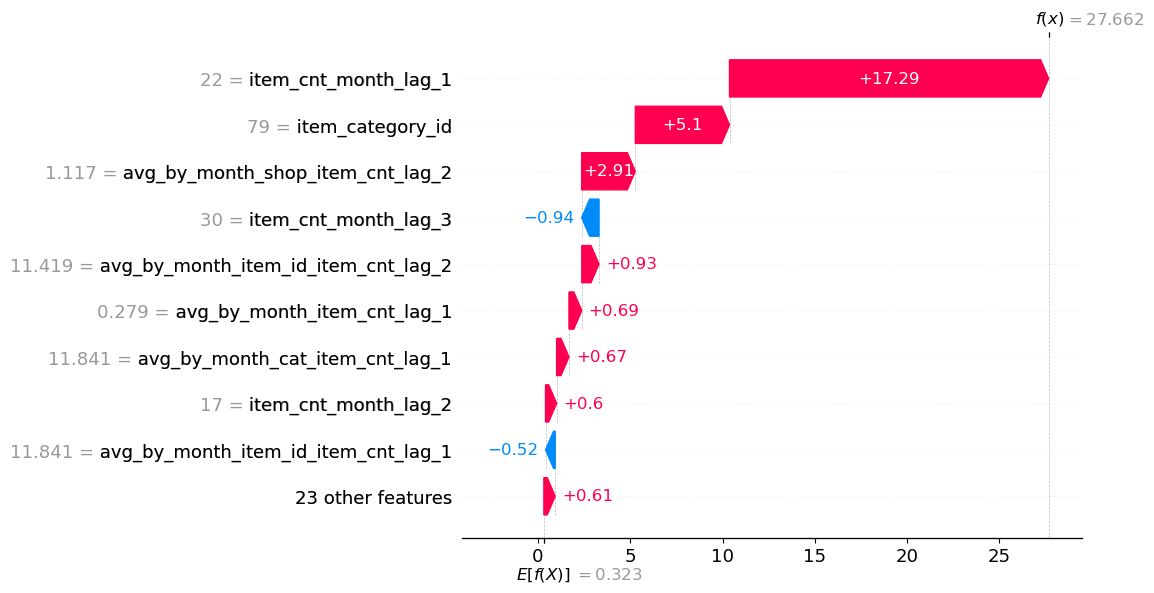

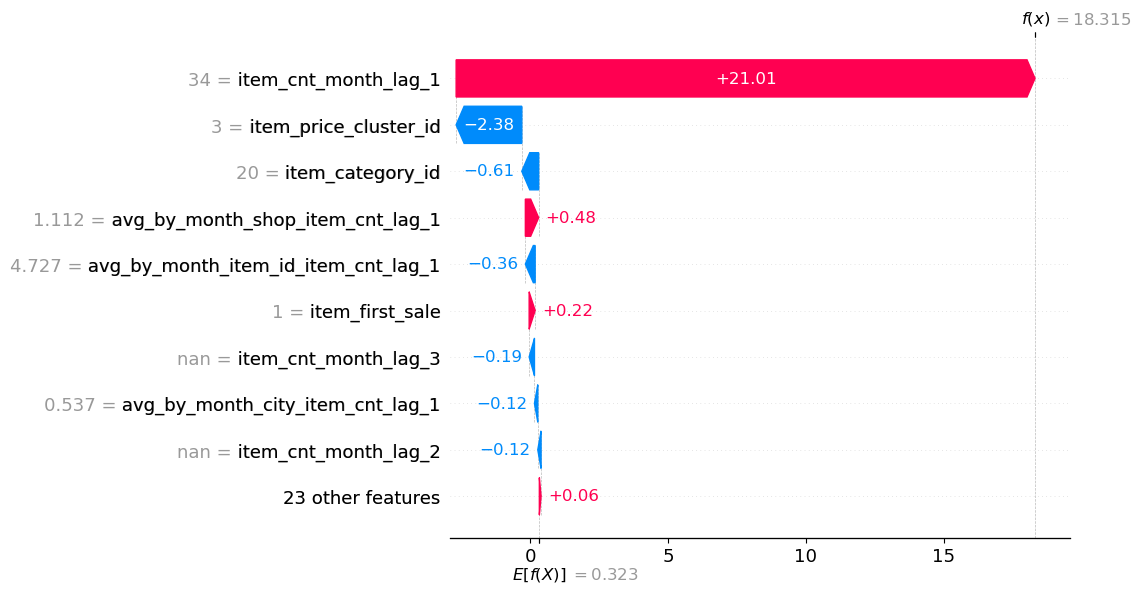

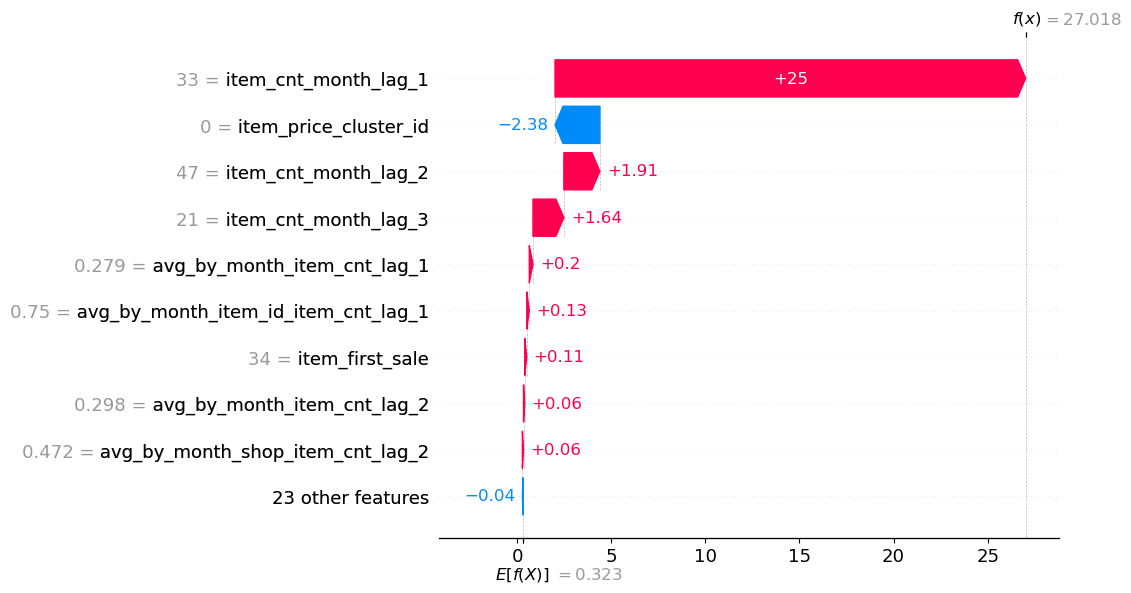

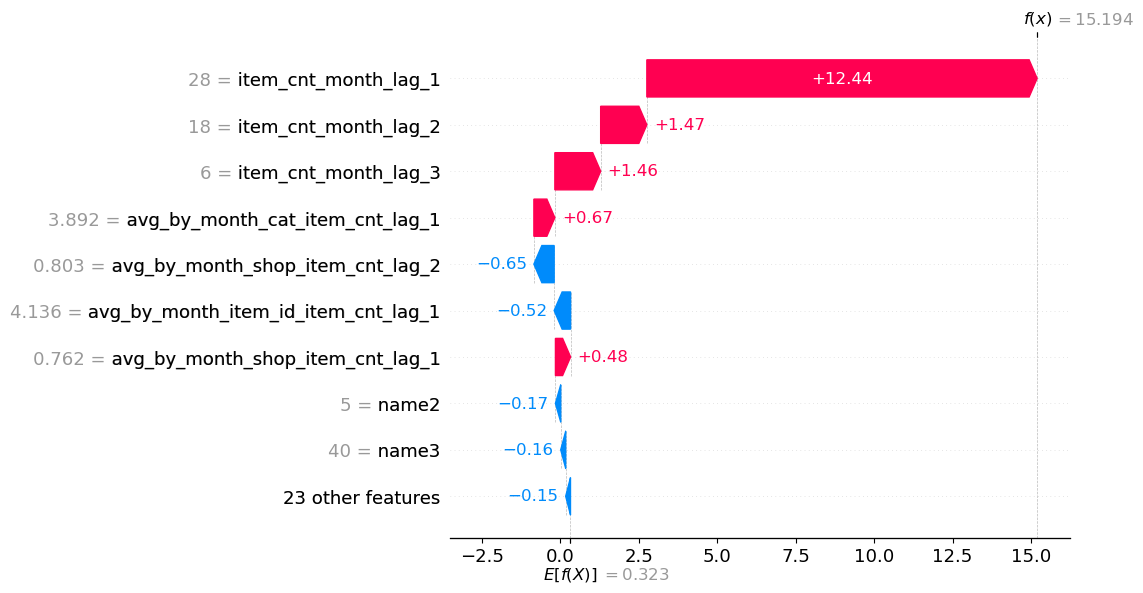

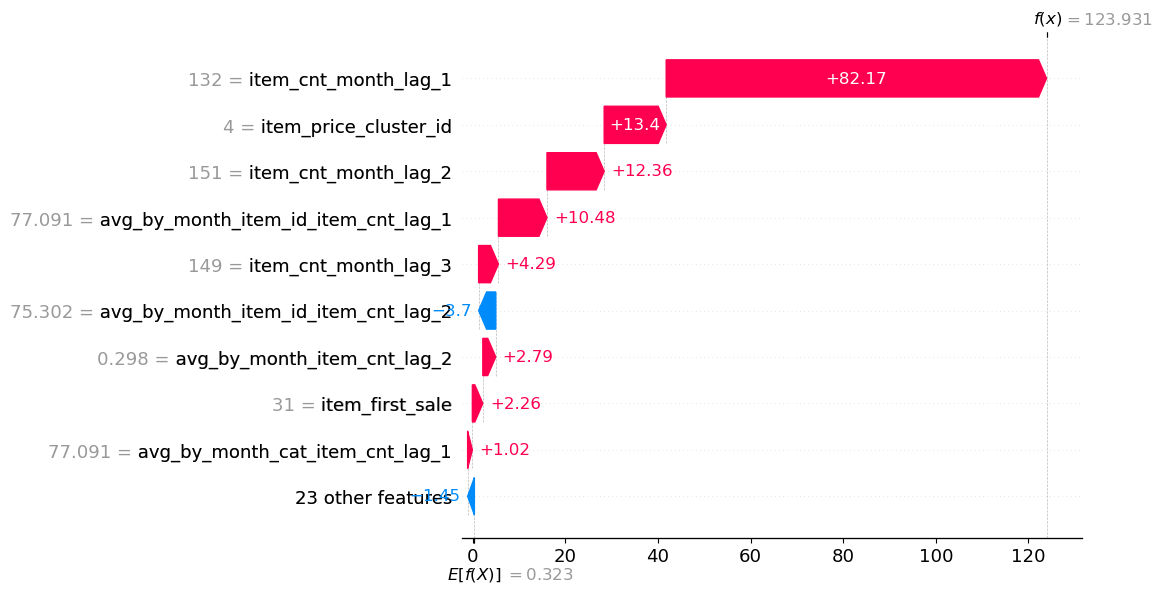

CPU times: total: 3min 41s
Wall time: 3min 6s


,ID,item_cnt_month
0,0,0.40
1,1,0.00
2,2,0.95
3,3,0.21
4,4,0.00
...,...,...
214195,214195,0.25
214196,214196,0.12
214197,214197,0.06
214198,214198,0.08


In [22]:
%%time
CatBoostSHAPTest.evaluate()

#### Error analysis layer test

In [10]:
%%time
optimal_params = {'learning_rate': 0.03259045124467292, 
                  'depth': 1,
                  'subsample': 0.33601321934039546, 
                  'colsample_bylevel': 0.7099208173278161,
                  'min_data_in_leaf': 56
                 }

CatBoostTestError = Pipeline(train_data=data['train_data'],
                 test_data=data['test_data'],
                 submission_example=data['submission_example'],
                 metrics=['rmse'],
                 model = cb.CatBoostRegressor(iterations=1000, random_state=42, **optimal_params, silent=True),
                 check_nans=False,
                 error_analysis_layer=True
                )

Data is not sorted by time (18781 rows), it will be further sorted automatically
CPU times: total: 5.84 s
Wall time: 6.45 s


In [11]:
%%time
error_analysis, predictions = CatBoostTestError.evaluate()

0:	learn: 2.2382793	total: 812ms	remaining: 13m 31s
1:	learn: 2.2173844	total: 1.02s	remaining: 8m 29s
2:	learn: 2.1976443	total: 1.21s	remaining: 6m 42s
3:	learn: 2.1789771	total: 1.41s	remaining: 5m 50s
4:	learn: 2.1610597	total: 1.6s	remaining: 5m 18s
5:	learn: 2.1441115	total: 1.8s	remaining: 4m 57s
6:	learn: 2.1367495	total: 2s	remaining: 4m 44s
7:	learn: 2.1206492	total: 2.2s	remaining: 4m 32s
8:	learn: 2.1069262	total: 2.4s	remaining: 4m 24s
9:	learn: 2.0949194	total: 2.6s	remaining: 4m 17s
10:	learn: 2.0804201	total: 2.78s	remaining: 4m 10s
11:	learn: 2.0665921	total: 2.97s	remaining: 4m 4s
12:	learn: 2.0534509	total: 3.16s	remaining: 3m 59s
13:	learn: 2.0406085	total: 3.35s	remaining: 3m 56s
14:	learn: 2.0285092	total: 3.56s	remaining: 3m 53s
15:	learn: 2.0167197	total: 3.76s	remaining: 3m 51s
16:	learn: 2.0055896	total: 3.99s	remaining: 3m 50s
17:	learn: 1.9959257	total: 4.25s	remaining: 3m 52s
18:	learn: 1.9867656	total: 4.48s	remaining: 3m 51s
19:	learn: 1.9765696	total: 4.

158:	learn: 1.5493295	total: 32s	remaining: 2m 49s
159:	learn: 1.5486525	total: 32.2s	remaining: 2m 48s
160:	learn: 1.5479304	total: 32.3s	remaining: 2m 48s
161:	learn: 1.5472173	total: 32.5s	remaining: 2m 48s
162:	learn: 1.5465126	total: 32.7s	remaining: 2m 47s
163:	learn: 1.5458216	total: 32.9s	remaining: 2m 47s
164:	learn: 1.5451610	total: 33.1s	remaining: 2m 47s
165:	learn: 1.5444969	total: 33.2s	remaining: 2m 46s
166:	learn: 1.5438802	total: 33.4s	remaining: 2m 46s
167:	learn: 1.5432515	total: 33.6s	remaining: 2m 46s
168:	learn: 1.5426365	total: 33.8s	remaining: 2m 46s
169:	learn: 1.5420172	total: 34s	remaining: 2m 46s
170:	learn: 1.5414286	total: 34.2s	remaining: 2m 45s
171:	learn: 1.5408552	total: 34.4s	remaining: 2m 45s
172:	learn: 1.5402669	total: 34.6s	remaining: 2m 45s
173:	learn: 1.5396914	total: 34.8s	remaining: 2m 45s
174:	learn: 1.5391329	total: 35s	remaining: 2m 44s
175:	learn: 1.5385629	total: 35.2s	remaining: 2m 44s
176:	learn: 1.5380170	total: 35.4s	remaining: 2m 44s

314:	learn: 1.5012742	total: 1m 3s	remaining: 2m 18s
315:	learn: 1.5011423	total: 1m 3s	remaining: 2m 18s
316:	learn: 1.5010134	total: 1m 4s	remaining: 2m 18s
317:	learn: 1.5008902	total: 1m 4s	remaining: 2m 18s
318:	learn: 1.5007651	total: 1m 4s	remaining: 2m 17s
319:	learn: 1.5006379	total: 1m 4s	remaining: 2m 17s
320:	learn: 1.5005157	total: 1m 5s	remaining: 2m 17s
321:	learn: 1.5003921	total: 1m 5s	remaining: 2m 17s
322:	learn: 1.5002714	total: 1m 5s	remaining: 2m 17s
323:	learn: 1.5001524	total: 1m 5s	remaining: 2m 16s
324:	learn: 1.5000368	total: 1m 5s	remaining: 2m 16s
325:	learn: 1.4999191	total: 1m 6s	remaining: 2m 16s
326:	learn: 1.4997975	total: 1m 6s	remaining: 2m 16s
327:	learn: 1.4996870	total: 1m 6s	remaining: 2m 16s
328:	learn: 1.4995717	total: 1m 6s	remaining: 2m 16s
329:	learn: 1.4994554	total: 1m 6s	remaining: 2m 15s
330:	learn: 1.4993405	total: 1m 7s	remaining: 2m 15s
331:	learn: 1.4992243	total: 1m 7s	remaining: 2m 15s
332:	learn: 1.4991117	total: 1m 7s	remaining: 

468:	learn: 1.4897305	total: 1m 34s	remaining: 1m 47s
469:	learn: 1.4896897	total: 1m 34s	remaining: 1m 46s
470:	learn: 1.4896500	total: 1m 34s	remaining: 1m 46s
471:	learn: 1.4896132	total: 1m 35s	remaining: 1m 46s
472:	learn: 1.4895741	total: 1m 35s	remaining: 1m 46s
473:	learn: 1.4895345	total: 1m 35s	remaining: 1m 45s
474:	learn: 1.4894961	total: 1m 35s	remaining: 1m 45s
475:	learn: 1.4894575	total: 1m 35s	remaining: 1m 45s
476:	learn: 1.4894186	total: 1m 36s	remaining: 1m 45s
477:	learn: 1.4893803	total: 1m 36s	remaining: 1m 45s
478:	learn: 1.4893427	total: 1m 36s	remaining: 1m 44s
479:	learn: 1.4893054	total: 1m 36s	remaining: 1m 44s
480:	learn: 1.4892688	total: 1m 36s	remaining: 1m 44s
481:	learn: 1.4892316	total: 1m 37s	remaining: 1m 44s
482:	learn: 1.4891939	total: 1m 37s	remaining: 1m 44s
483:	learn: 1.4891578	total: 1m 37s	remaining: 1m 43s
484:	learn: 1.4891231	total: 1m 37s	remaining: 1m 43s
485:	learn: 1.4890864	total: 1m 37s	remaining: 1m 43s
486:	learn: 1.4890515	total:

621:	learn: 1.4858686	total: 2m 5s	remaining: 1m 15s
622:	learn: 1.4858526	total: 2m 5s	remaining: 1m 15s
623:	learn: 1.4858364	total: 2m 5s	remaining: 1m 15s
624:	learn: 1.4858203	total: 2m 5s	remaining: 1m 15s
625:	learn: 1.4858046	total: 2m 5s	remaining: 1m 15s
626:	learn: 1.4857889	total: 2m 5s	remaining: 1m 14s
627:	learn: 1.4857732	total: 2m 6s	remaining: 1m 14s
628:	learn: 1.4857572	total: 2m 6s	remaining: 1m 14s
629:	learn: 1.4857410	total: 2m 6s	remaining: 1m 14s
630:	learn: 1.4857255	total: 2m 6s	remaining: 1m 14s
631:	learn: 1.4857100	total: 2m 6s	remaining: 1m 13s
632:	learn: 1.4856957	total: 2m 7s	remaining: 1m 13s
633:	learn: 1.4856801	total: 2m 7s	remaining: 1m 13s
634:	learn: 1.4856649	total: 2m 7s	remaining: 1m 13s
635:	learn: 1.4856495	total: 2m 7s	remaining: 1m 13s
636:	learn: 1.4856340	total: 2m 7s	remaining: 1m 12s
637:	learn: 1.4856188	total: 2m 8s	remaining: 1m 12s
638:	learn: 1.4856037	total: 2m 8s	remaining: 1m 12s
639:	learn: 1.4855888	total: 2m 8s	remaining: 

777:	learn: 1.4840274	total: 2m 36s	remaining: 44.8s
778:	learn: 1.4840190	total: 2m 37s	remaining: 44.6s
779:	learn: 1.4840107	total: 2m 37s	remaining: 44.4s
780:	learn: 1.4840024	total: 2m 37s	remaining: 44.2s
781:	learn: 1.4839939	total: 2m 37s	remaining: 44s
782:	learn: 1.4839856	total: 2m 38s	remaining: 43.8s
783:	learn: 1.4839771	total: 2m 38s	remaining: 43.6s
784:	learn: 1.4839689	total: 2m 38s	remaining: 43.4s
785:	learn: 1.4839607	total: 2m 38s	remaining: 43.2s
786:	learn: 1.4839527	total: 2m 38s	remaining: 43s
787:	learn: 1.4839451	total: 2m 39s	remaining: 42.8s
788:	learn: 1.4839369	total: 2m 39s	remaining: 42.6s
789:	learn: 1.4839289	total: 2m 39s	remaining: 42.4s
790:	learn: 1.4839207	total: 2m 39s	remaining: 42.2s
791:	learn: 1.4839126	total: 2m 40s	remaining: 42s
792:	learn: 1.4839049	total: 2m 40s	remaining: 41.9s
793:	learn: 1.4838968	total: 2m 40s	remaining: 41.7s
794:	learn: 1.4838888	total: 2m 40s	remaining: 41.5s
795:	learn: 1.4838808	total: 2m 41s	remaining: 41.3s

934:	learn: 1.4830055	total: 3m 10s	remaining: 13.2s
935:	learn: 1.4830005	total: 3m 10s	remaining: 13s
936:	learn: 1.4829955	total: 3m 10s	remaining: 12.8s
937:	learn: 1.4829906	total: 3m 10s	remaining: 12.6s
938:	learn: 1.4829857	total: 3m 11s	remaining: 12.4s
939:	learn: 1.4829808	total: 3m 11s	remaining: 12.2s
940:	learn: 1.4829758	total: 3m 11s	remaining: 12s
941:	learn: 1.4829710	total: 3m 11s	remaining: 11.8s
942:	learn: 1.4829660	total: 3m 11s	remaining: 11.6s
943:	learn: 1.4829611	total: 3m 12s	remaining: 11.4s
944:	learn: 1.4829563	total: 3m 12s	remaining: 11.2s
945:	learn: 1.4829514	total: 3m 12s	remaining: 11s
946:	learn: 1.4829465	total: 3m 12s	remaining: 10.8s
947:	learn: 1.4829417	total: 3m 12s	remaining: 10.6s
948:	learn: 1.4829369	total: 3m 13s	remaining: 10.4s
949:	learn: 1.4829320	total: 3m 13s	remaining: 10.2s
950:	learn: 1.4829271	total: 3m 13s	remaining: 9.97s
951:	learn: 1.4829222	total: 3m 13s	remaining: 9.77s
952:	learn: 1.4829174	total: 3m 14s	remaining: 9.57s

91:	learn: 1.6623494	total: 14.9s	remaining: 2m 26s
92:	learn: 1.6601797	total: 15s	remaining: 2m 26s
93:	learn: 1.6584039	total: 15.2s	remaining: 2m 26s
94:	learn: 1.6563110	total: 15.3s	remaining: 2m 26s
95:	learn: 1.6542858	total: 15.5s	remaining: 2m 25s
96:	learn: 1.6522959	total: 15.6s	remaining: 2m 25s
97:	learn: 1.6506044	total: 15.8s	remaining: 2m 25s
98:	learn: 1.6487461	total: 16s	remaining: 2m 25s
99:	learn: 1.6469351	total: 16.1s	remaining: 2m 24s
100:	learn: 1.6450653	total: 16.3s	remaining: 2m 24s
101:	learn: 1.6434931	total: 16.4s	remaining: 2m 24s
102:	learn: 1.6418326	total: 16.6s	remaining: 2m 24s
103:	learn: 1.6400435	total: 16.7s	remaining: 2m 24s
104:	learn: 1.6384897	total: 16.9s	remaining: 2m 24s
105:	learn: 1.6367962	total: 17.1s	remaining: 2m 23s
106:	learn: 1.6353156	total: 17.2s	remaining: 2m 23s
107:	learn: 1.6336745	total: 17.4s	remaining: 2m 23s
108:	learn: 1.6323043	total: 17.5s	remaining: 2m 23s
109:	learn: 1.6306231	total: 17.7s	remaining: 2m 23s
110:	l

249:	learn: 1.5434083	total: 40.6s	remaining: 2m 1s
250:	learn: 1.5431733	total: 40.7s	remaining: 2m 1s
251:	learn: 1.5429457	total: 40.9s	remaining: 2m 1s
252:	learn: 1.5427629	total: 41.1s	remaining: 2m 1s
253:	learn: 1.5425323	total: 41.3s	remaining: 2m 1s
254:	learn: 1.5423066	total: 41.4s	remaining: 2m 1s
255:	learn: 1.5420867	total: 41.6s	remaining: 2m
256:	learn: 1.5418690	total: 41.8s	remaining: 2m
257:	learn: 1.5416483	total: 42s	remaining: 2m
258:	learn: 1.5414275	total: 42.1s	remaining: 2m
259:	learn: 1.5412101	total: 42.3s	remaining: 2m
260:	learn: 1.5410149	total: 42.5s	remaining: 2m
261:	learn: 1.5408085	total: 42.6s	remaining: 2m
262:	learn: 1.5405972	total: 42.8s	remaining: 1m 59s
263:	learn: 1.5404037	total: 42.9s	remaining: 1m 59s
264:	learn: 1.5401934	total: 43.1s	remaining: 1m 59s
265:	learn: 1.5399825	total: 43.2s	remaining: 1m 59s
266:	learn: 1.5397769	total: 43.4s	remaining: 1m 59s
267:	learn: 1.5395758	total: 43.5s	remaining: 1m 58s
268:	learn: 1.5394157	total: 

405:	learn: 1.5232987	total: 1m 6s	remaining: 1m 36s
406:	learn: 1.5232300	total: 1m 6s	remaining: 1m 36s
407:	learn: 1.5231601	total: 1m 6s	remaining: 1m 36s
408:	learn: 1.5230908	total: 1m 6s	remaining: 1m 36s
409:	learn: 1.5230213	total: 1m 6s	remaining: 1m 36s
410:	learn: 1.5229534	total: 1m 6s	remaining: 1m 35s
411:	learn: 1.5228997	total: 1m 7s	remaining: 1m 35s
412:	learn: 1.5228351	total: 1m 7s	remaining: 1m 35s
413:	learn: 1.5227693	total: 1m 7s	remaining: 1m 35s
414:	learn: 1.5227017	total: 1m 7s	remaining: 1m 35s
415:	learn: 1.5226363	total: 1m 7s	remaining: 1m 34s
416:	learn: 1.5225705	total: 1m 7s	remaining: 1m 34s
417:	learn: 1.5225198	total: 1m 7s	remaining: 1m 34s
418:	learn: 1.5224561	total: 1m 8s	remaining: 1m 34s
419:	learn: 1.5223937	total: 1m 8s	remaining: 1m 34s
420:	learn: 1.5223316	total: 1m 8s	remaining: 1m 34s
421:	learn: 1.5222684	total: 1m 8s	remaining: 1m 33s
422:	learn: 1.5222068	total: 1m 8s	remaining: 1m 33s
423:	learn: 1.5221517	total: 1m 8s	remaining: 

559:	learn: 1.5166983	total: 1m 32s	remaining: 1m 12s
560:	learn: 1.5166720	total: 1m 32s	remaining: 1m 12s
561:	learn: 1.5166459	total: 1m 32s	remaining: 1m 12s
562:	learn: 1.5166200	total: 1m 33s	remaining: 1m 12s
563:	learn: 1.5165944	total: 1m 33s	remaining: 1m 12s
564:	learn: 1.5165685	total: 1m 33s	remaining: 1m 11s
565:	learn: 1.5165435	total: 1m 33s	remaining: 1m 11s
566:	learn: 1.5165172	total: 1m 33s	remaining: 1m 11s
567:	learn: 1.5164918	total: 1m 33s	remaining: 1m 11s
568:	learn: 1.5164663	total: 1m 34s	remaining: 1m 11s
569:	learn: 1.5164414	total: 1m 34s	remaining: 1m 11s
570:	learn: 1.5164162	total: 1m 34s	remaining: 1m 10s
571:	learn: 1.5163918	total: 1m 34s	remaining: 1m 10s
572:	learn: 1.5163669	total: 1m 34s	remaining: 1m 10s
573:	learn: 1.5163428	total: 1m 34s	remaining: 1m 10s
574:	learn: 1.5163187	total: 1m 35s	remaining: 1m 10s
575:	learn: 1.5162943	total: 1m 35s	remaining: 1m 10s
576:	learn: 1.5162736	total: 1m 35s	remaining: 1m 9s
577:	learn: 1.5162495	total: 

714:	learn: 1.5138286	total: 1m 59s	remaining: 47.8s
715:	learn: 1.5138153	total: 2m	remaining: 47.6s
716:	learn: 1.5138021	total: 2m	remaining: 47.5s
717:	learn: 1.5137883	total: 2m	remaining: 47.3s
718:	learn: 1.5137750	total: 2m	remaining: 47.2s
719:	learn: 1.5137620	total: 2m	remaining: 47s
720:	learn: 1.5137488	total: 2m 1s	remaining: 46.8s
721:	learn: 1.5137354	total: 2m 1s	remaining: 46.7s
722:	learn: 1.5137221	total: 2m 1s	remaining: 46.5s
723:	learn: 1.5137100	total: 2m 1s	remaining: 46.4s
724:	learn: 1.5136968	total: 2m 1s	remaining: 46.2s
725:	learn: 1.5136838	total: 2m 1s	remaining: 46s
726:	learn: 1.5136708	total: 2m 2s	remaining: 45.9s
727:	learn: 1.5136580	total: 2m 2s	remaining: 45.7s
728:	learn: 1.5136451	total: 2m 2s	remaining: 45.6s
729:	learn: 1.5136325	total: 2m 2s	remaining: 45.4s
730:	learn: 1.5136198	total: 2m 2s	remaining: 45.2s
731:	learn: 1.5136070	total: 2m 3s	remaining: 45.1s
732:	learn: 1.5135943	total: 2m 3s	remaining: 44.9s
733:	learn: 1.5135843	total: 2

872:	learn: 1.5122477	total: 2m 28s	remaining: 21.5s
873:	learn: 1.5122403	total: 2m 28s	remaining: 21.4s
874:	learn: 1.5122327	total: 2m 28s	remaining: 21.2s
875:	learn: 1.5122252	total: 2m 28s	remaining: 21s
876:	learn: 1.5122176	total: 2m 28s	remaining: 20.9s
877:	learn: 1.5122100	total: 2m 28s	remaining: 20.7s
878:	learn: 1.5122025	total: 2m 29s	remaining: 20.5s
879:	learn: 1.5121951	total: 2m 29s	remaining: 20.4s
880:	learn: 1.5121876	total: 2m 29s	remaining: 20.2s
881:	learn: 1.5121803	total: 2m 29s	remaining: 20s
882:	learn: 1.5121728	total: 2m 29s	remaining: 19.9s
883:	learn: 1.5121655	total: 2m 30s	remaining: 19.7s
884:	learn: 1.5121582	total: 2m 30s	remaining: 19.5s
885:	learn: 1.5121511	total: 2m 30s	remaining: 19.3s
886:	learn: 1.5121436	total: 2m 30s	remaining: 19.2s
887:	learn: 1.5121364	total: 2m 30s	remaining: 19s
888:	learn: 1.5121292	total: 2m 30s	remaining: 18.8s
889:	learn: 1.5121222	total: 2m 31s	remaining: 18.7s
890:	learn: 1.5121151	total: 2m 31s	remaining: 18.5s

In [14]:
error_analysis['high_error_predictions']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
6518021,32.00,332.00,299.87,27,25,20949,71,11,59,13,...,0.51,13.27,0.01,4,4,2,24,24,0.10,10.38
6517987,271.00,1.00,270.85,26,42,20949,71,11,59,19,...,0.65,30.67,0.01,4,4,4,23,23,271.00,0.00
6518026,110.00,371.00,261.20,27,31,20949,71,11,59,13,...,0.51,13.27,0.01,4,4,2,24,24,0.30,3.37
10857175,36.00,254.00,218.00,32,55,9255,8,3,27,27,...,0.39,1.92,-0.03,3,0,3,5,5,0.14,7.06
10857961,94.00,300.00,205.83,32,55,9247,8,3,27,27,...,0.39,1.92,-0.01,3,0,3,5,5,0.31,3.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10839272,4.00,73.00,69.07,32,22,9250,80,13,26,13,...,0.53,1.92,-0.06,4,3,3,5,5,0.05,18.25
10916848,1.00,69.00,68.45,28,55,10208,31,6,62,27,...,NaN,NaN,0.00,4,3,3,0,0,0.01,69.00
10807315,1.00,69.00,68.27,27,14,3731,30,6,56,8,...,NaN,NaN,0.00,4,3,3,0,0,0.01,69.00
10807345,1.00,69.00,68.25,27,52,3731,30,6,56,25,...,NaN,NaN,0.00,4,3,3,0,0,0.01,69.00


In [16]:
error_analysis['poorly_small_dynamic']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
6517987,271.00,1.00,270.85,26,42,20949,71,11,59,19,...,0.65,30.67,0.01,4,4,4,23,23,271.00,0.00
6517927,205.00,1.00,205.01,25,25,20949,71,11,59,13,...,0.59,90.42,0.01,4,4,2,22,22,205.00,0.00
6518001,197.00,1.00,196.52,26,57,20949,71,11,59,29,...,0.49,30.67,0.01,4,4,4,23,23,197.00,0.01
6517976,191.00,1.00,190.90,26,27,20949,71,11,59,13,...,0.47,30.67,0.01,4,4,4,23,23,191.00,0.01
6517979,190.00,1.00,189.69,26,31,20949,71,11,59,13,...,0.47,30.67,0.01,4,4,2,23,23,190.00,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6019780,11.00,1.00,11.08,28,59,6738,30,6,56,30,...,0.18,1.13,0.25,4,0,3,26,26,11.00,0.09
718981,11.00,1.00,11.27,25,24,7856,28,6,33,13,...,0.59,1.03,-0.02,0,0,0,25,25,11.00,0.09
9982707,11.00,1.00,11.45,24,27,6504,29,6,37,13,...,0.85,1.12,0.02,4,3,4,4,4,11.00,0.09
10807360,63.00,6.00,57.42,28,12,3731,30,6,56,7,...,0.33,1.13,-0.05,4,3,0,1,1,10.50,0.10


In [17]:
error_analysis['poorly_high_dynamic']

,y_pred,y_test,error,date_block_num,shop_id,item_id,item_category_id,type_code,subtype_code,shop_city,...,avg_by_month_city_item_cnt_lag_1,avg_by_month_cat_item_cnt_lag_1,delta_price_lag,category_cluster_id,item_price_cluster_id,cluster_id,item_shop_first_sale,item_first_sale,error_type_1,error_type_2
10807336,1.00,112.00,111.15,27,42,3731,30,6,56,19,...,NaN,NaN,0.00,4,3,4,0,0,0.01,112.00
10807310,1.00,111.00,110.27,27,6,3731,30,6,56,4,...,NaN,NaN,0.00,4,3,0,0,0,0.01,111.00
10861167,1.00,111.00,110.45,27,55,3729,31,6,62,27,...,NaN,NaN,0.00,4,3,3,0,0,0.01,111.00
10807314,1.00,102.00,101.27,27,12,3731,30,6,56,7,...,NaN,NaN,0.00,4,3,0,0,0,0.01,102.00
10807323,1.00,101.00,100.25,27,25,3731,30,6,56,13,...,NaN,NaN,0.00,4,3,2,0,0,0.01,101.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2920577,2.00,21.00,18.98,27,47,5361,30,6,56,22,...,0.33,0.84,-0.74,4,0,0,27,27,0.10,10.50
6518021,32.00,332.00,299.87,27,25,20949,71,11,59,13,...,0.51,13.27,0.01,4,4,2,24,24,0.10,10.38
9977186,3.00,31.00,28.32,28,42,3342,20,6,11,19,...,0.74,1.00,0.10,0,3,4,8,8,0.10,10.33
6518078,3.00,31.00,27.65,28,41,20949,71,11,59,18,...,0.13,75.62,0.01,4,4,3,25,25,0.10,10.33


In [18]:
error_analysis['percentage_of_big_small_poor_predictions']

'0.09391975089253572 %'

In [19]:
error_analysis['items_most_often_errors_occur']

{'small_dynamic': Index([3731, 20949], dtype='int64', name='item_id'),
 'big_dynamic': Index([ 3731, 10209, 10210,  4894, 16825, 10201,  1814,  3351, 10202, 10207,
         4719,  1969,  7223,  5361,  4892, 11354,  3352,  3350,  4721,  1583,
        15346,  6507, 12021,  3688,  4840,  1971,  1568, 10212, 12020,  2969,
         7087,  7224, 22102,  4896,  3243,  9250,  4838, 16826],
       dtype='int64', name='item_id')}